# 2. Le + AQC

Pipeline: Isabel's code, tranform to quantum cirucit, mapping to qubits

1. Construct Hamiltonian

In [2]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms

method = 'hybrid'
num_sites = 6
degree = 2
n_repetitions = 5
n_id_layers = 0

In [3]:
# Ising-1d
J=1.
t = 2.0
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

2. Get Trotterised brickwall gates

In [37]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain
import numpy as np

gates_ising = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, g=g, h=h)
print(np.array(gates_ising).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 4, 4)


In [38]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates

gates_initial = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, g=g, h=h)
print(np.array(gates_initial).shape) 

(28, 4, 4)


3. View Initial Circuit

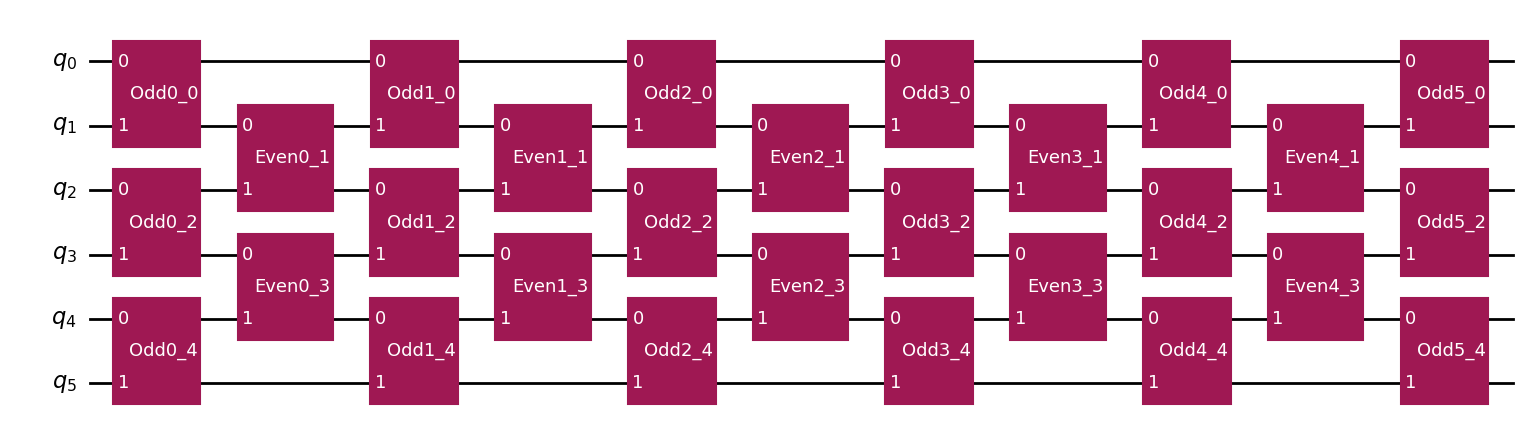

In [39]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_initial, pauli_terms=terms)
depth = qc_initial.depth()
qc_initial.draw('mpl')

In [40]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, g=g, h=h)
print(np.array(gates).shape)  # Should be (N, 4, 4) for 2-qubit gates


(28, 2, 2, 2, 2)


Load Reference unitary - to be modified if n_repetitions changes

In [41]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, g, h= load_reference(config['reference_dir'], config['n_sites'], config['n_repetitions'], config['t'])

QR sweep on U_ref

In [42]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 64), (64, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


4. Optimisation of Frobenius norm

Start Riemannian ADAM optimization ...
	 0 	Current cost:  0.9968801045731941
	 1 	Current cost:  0.5512989587388515
	 2 	Current cost:  0.22918740933452741
	 3 	Current cost:  0.09537576079704246
	 4 	Current cost:  0.11128774237577121
	 5 	Current cost:  0.17051142431171717
	 6 	Current cost:  0.19782832255277638
	 7 	Current cost:  0.17945712773788003
	 8 	Current cost:  0.1333571611997777
	 9 	Current cost:  0.08470576460282109
	 10 	Current cost:  0.05343468965511278
	 11 	Current cost:  0.04708529098468839
	 12 	Current cost:  0.05938954436930555
	 13 	Current cost:  0.07613532379756638
	 14 	Current cost:  0.08442160893168649
	 15 	Current cost:  0.07877918102148085
	 16 	Current cost:  0.061767352807724496
	 17 	Current cost:  0.040926666557870695
	 18 	Current cost:  0.02448361172615998
	 19 	Current cost:  0.017479944187817953
	 20 	Current cost:  0.01975934275288571
	 21 	Current cost:  0.0267181596483419
	 22 	Current cost:  0.0323164349731373
	 23 	Current cost:  0.0324532

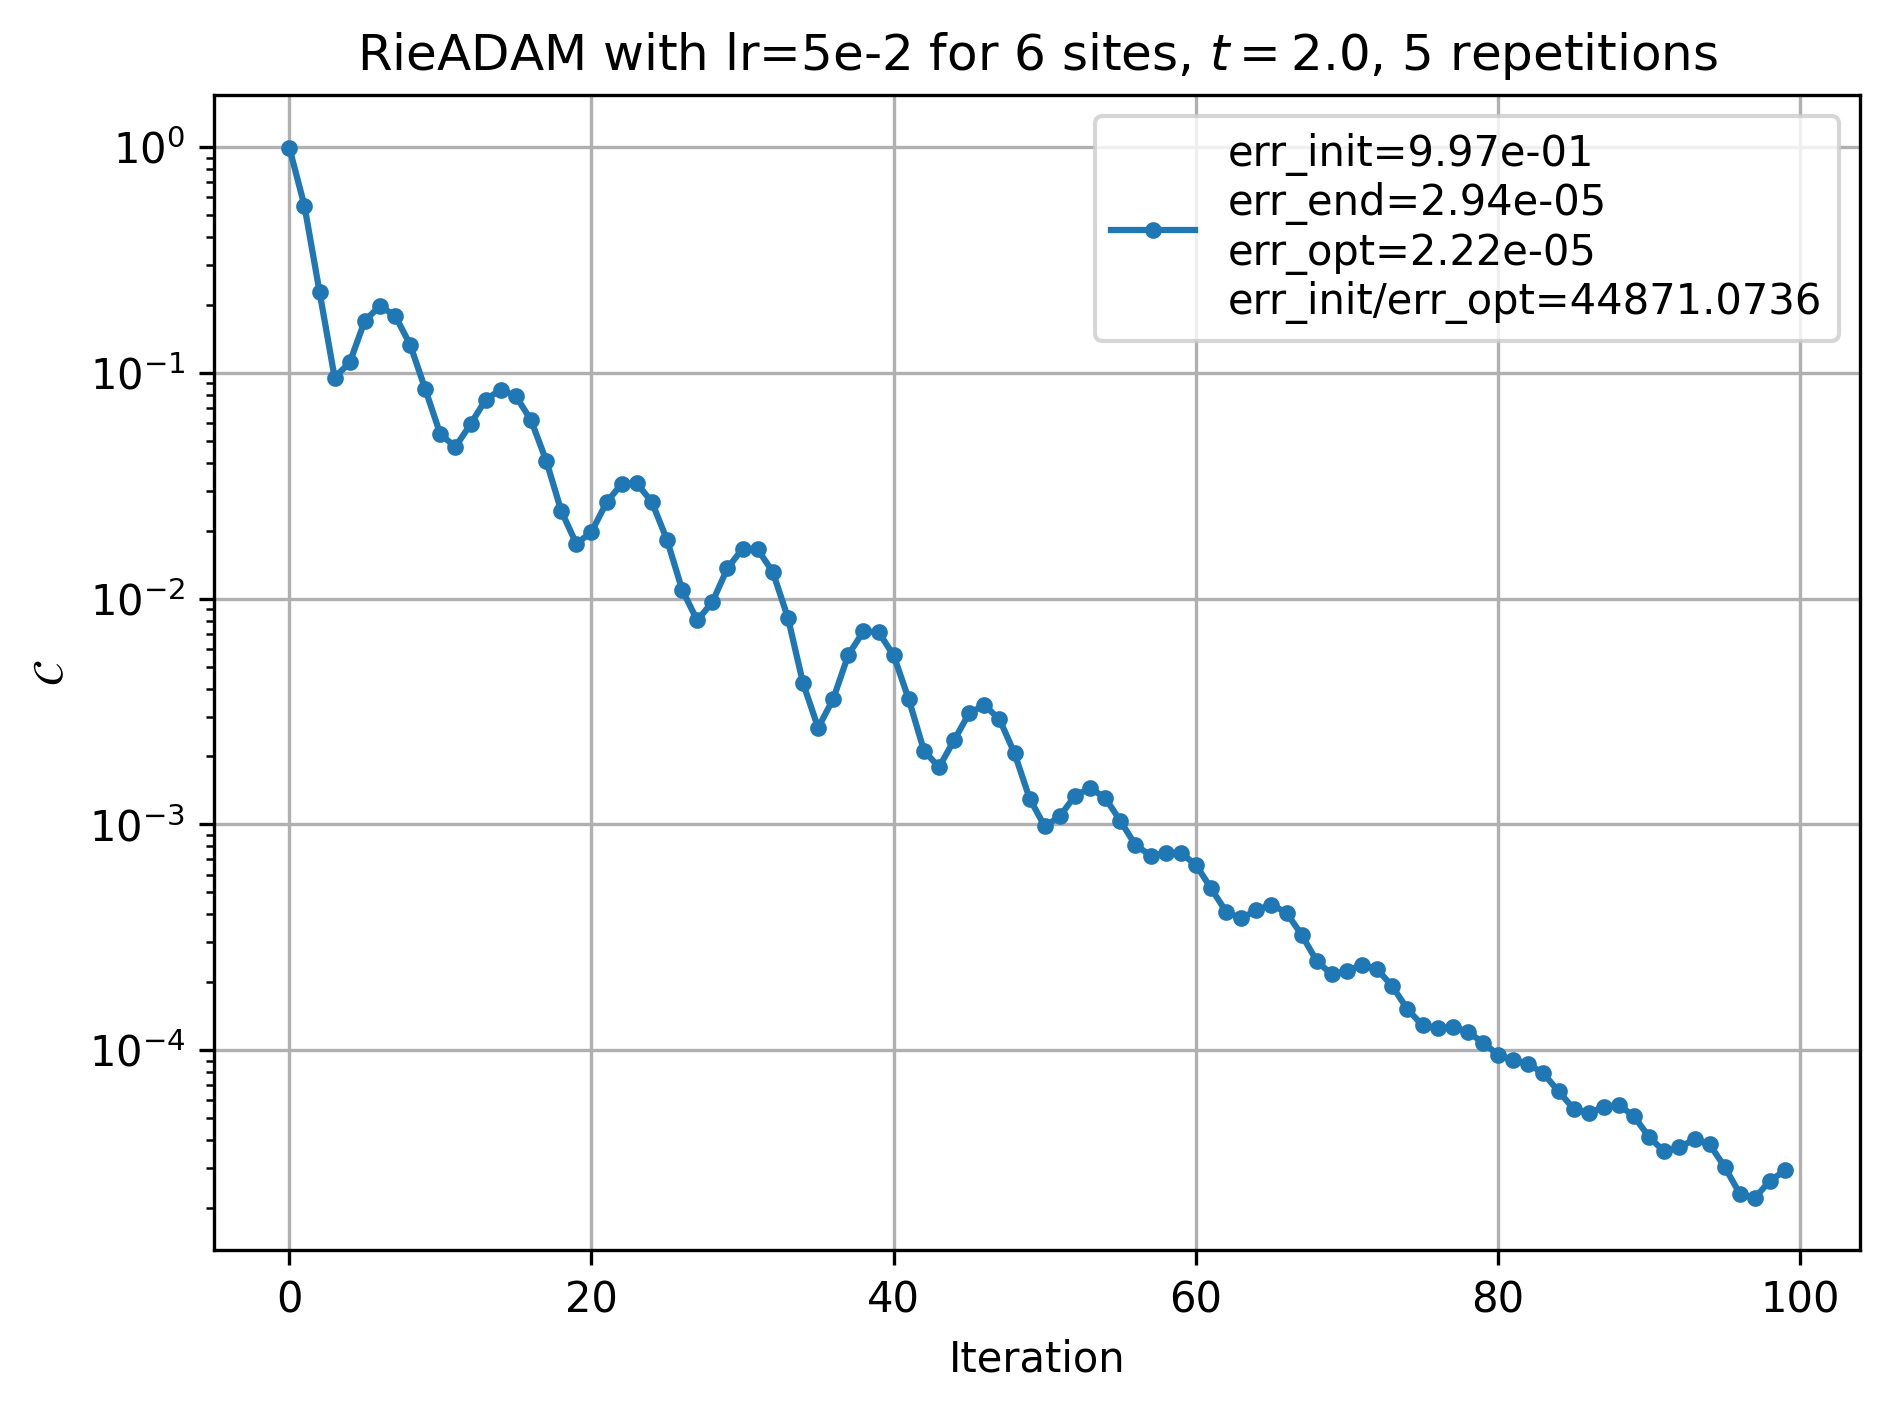

In [43]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM

gates_optimised, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates)

In [44]:
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import Statevector
# from ropt_aqc.comparison_methods import compress_HS

# N_vals = range(1,depth)

# df, gates_optimised_reshaped = compress_HS(gates, config, U_ref, N_vals, qc_initial)

In [45]:
# from ropt_aqc.brickwall_opt import plot_fidelity

# elbow_N, plateau_N = plot_fidelity(df, 'statevector_fidelity', n_repetitions, 1e-3, method, system)

In [46]:
# # Compress circuit
# N_vals = [int(elbow_N)]
# df_compressed, gates_optimised_reshaped_compressed = compress_HS(gates, config, U_ref, N_vals, qc_initial)

Visualise optimised cirucit

(28, 4, 4)
11


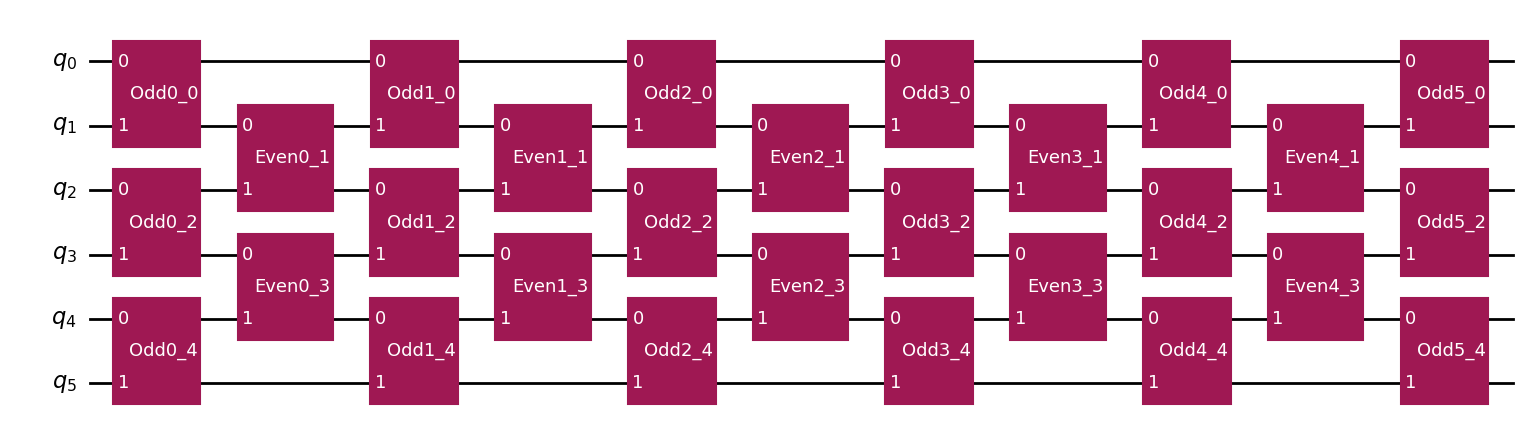

In [47]:
gates_optimised = gates_optimised.reshape((len(gates_optimised), 4, 4))
print(gates_optimised.shape)

qc_opt = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_optimised, pauli_terms=terms)
depth_opt = qc_opt.depth()
print(depth_opt)
qc_opt.draw('mpl')

In [48]:
np.allclose(gates_optimised, gates_initial)  # Should be False

False

In [49]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_observable

H_sparse = hamiltonian_to_sparse_observable(terms, num_qubits=num_sites)
print(H_sparse)

<SparseObservable with 17 terms on 6 qubits: (1+0j)(Z_5 Z_4) + (1+0j)(Z_4 Z_3) + (1+0j)(Z_3 Z_2) + (1+0j)(Z_2 Z_1) + (1+0j)(Z_1 Z_0) + (0.6+0j)(Z_5) + (0.75+0j)(X_5) + (0.6+0j)(Z_4) + (0.75+0j)(X_4) + (0.6+0j)(Z_3) + (0.75+0j)(X_3) + (0.6+0j)(Z_2) + (0.75+0j)(X_2) + (0.6+0j)(Z_1) + (0.75+0j)(X_1) + (0.6+0j)(Z_0) + (0.75+0j)(X_0)>


In [50]:
# construct initial state
from qiskit import QuantumCircuit

initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)

In [51]:
# Generate the AQC target circuit (initial segment)
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

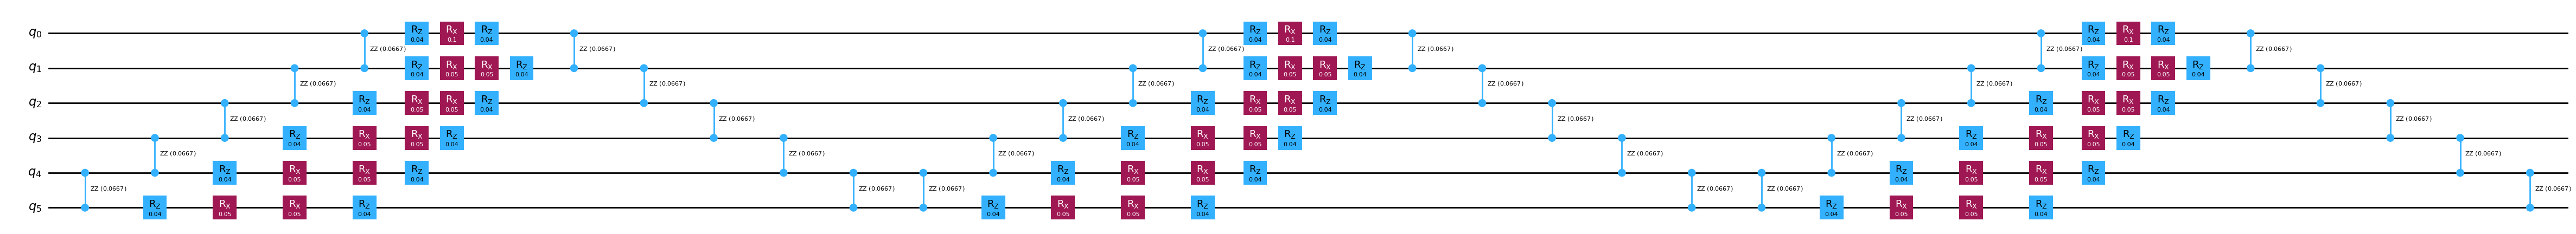

In [52]:
# Generate the subsequent circuit
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )
subsequent_circuit.draw("mpl", fold=-1)

In [53]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)

aqc_comparison_circuit = generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
        time=aqc_evolution_time,
    )

In [54]:
# correct choice for reference circuit, should reflect the same physical system as the initial cirucit optimised with HS
from ropt_aqc.circuit_building import decompose_unitary_gate
ref_gates = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=200,
                                                   hamiltonian=system, degree=degree, J=J, g=g, h=h)

ref_circuit = transform_to_bw_qc_unitarygate(num_sites=num_sites, system=system, gates=ref_gates)
native_ref_circuit = decompose_unitary_gate(ref_circuit)

In [55]:
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit import transpile

native_ref_circuit_transpiled = transpile(
    native_ref_circuit,
    basis_gates=['rx', 'ry', 'rz', 'cx'],
    optimization_level=3
)

simulator_settings = QuimbSimulator(qtn.CircuitMPS, autodiff_backend="jax")
aqc_target_mps = tensornetwork_from_circuit(native_ref_circuit_transpiled, simulator_settings)


In [56]:
from ropt_aqc.comparison_methods import compress_HS_AQC

N_vals = range(1, 24)
df, aqc_ansatz, aqc_initial_parameters, aqc_final_parameters = compress_HS_AQC(gates_optimised, config, simulator_settings, aqc_target_mps, aqc_comparison_circuit, aqc_target_circuit, N_vals, terms)

Starting fidelity: 0.8671937001815497
AQC Comparison circuit: depth 42
Target circuit:         depth 449
Hybrid ansatz circuit:  depth 23, with 270 parameters

=== Optimizing with N = 1 layers ===
2025-05-12 10:34:13.511480 Intermediate result: Fidelity 0.59284799
2025-05-12 10:34:13.512443 Intermediate result: Fidelity 0.65539461
2025-05-12 10:34:13.514035 Intermediate result: Fidelity 0.93392195
2025-05-12 10:34:13.514359 Intermediate result: Fidelity 0.94807940
2025-05-12 10:34:13.514677 Intermediate result: Fidelity 0.95766691
2025-05-12 10:34:13.514974 Intermediate result: Fidelity 0.95878927
2025-05-12 10:34:13.515263 Intermediate result: Fidelity 0.95963448
2025-05-12 10:34:13.515547 Intermediate result: Fidelity 0.96142153
2025-05-12 10:34:13.515826 Intermediate result: Fidelity 0.96214637
2025-05-12 10:34:13.516370 Intermediate result: Fidelity 0.96222754
2025-05-12 10:34:13.516648 Intermediate result: Fidelity 0.96228042
2025-05-12 10:34:13.516922 Intermediate result: Fidelit

=== Complete Optimised Circuit ===


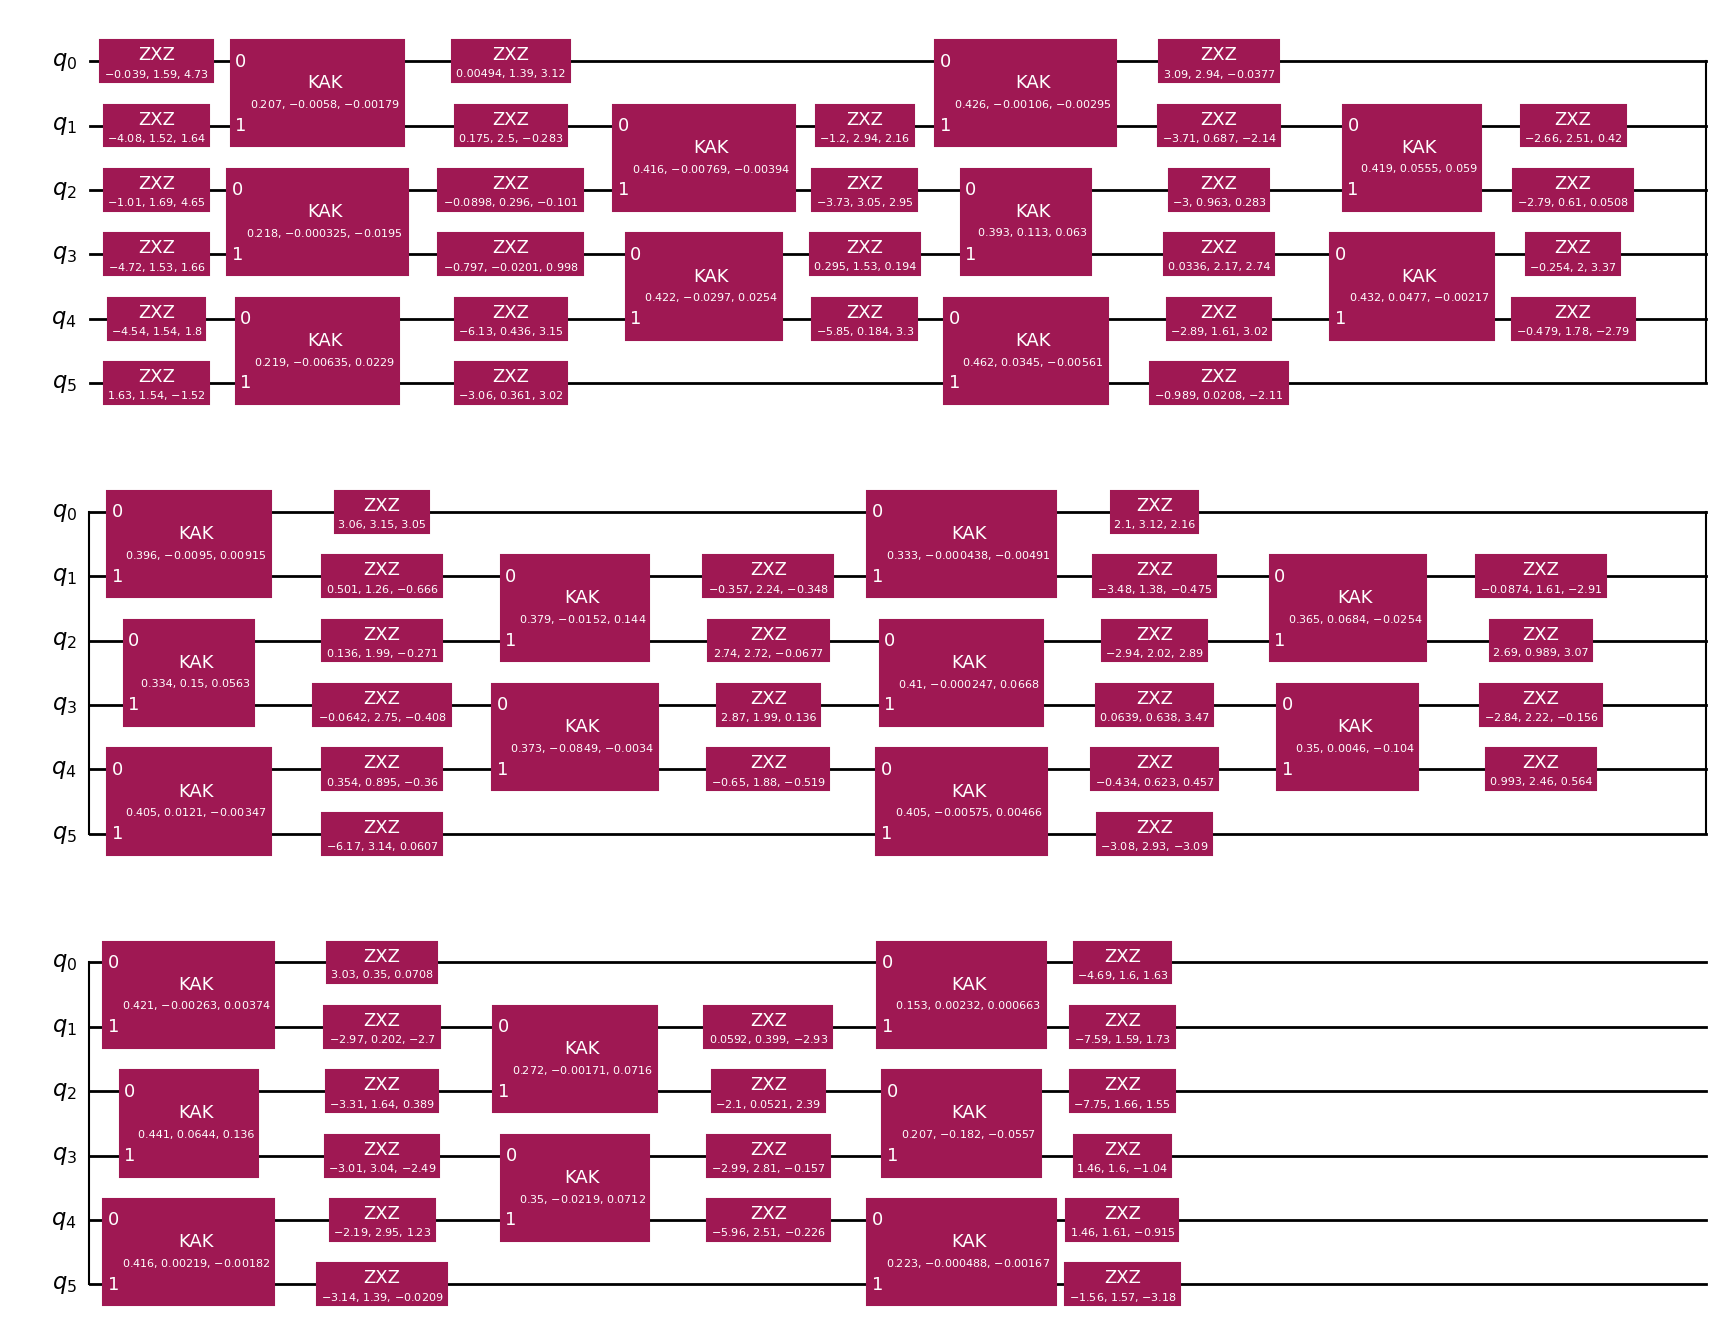

In [57]:
# from the optimised circuit 
aqc_optimised_block = aqc_ansatz.assign_parameters(aqc_final_parameters)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block.draw("mpl")

In [58]:
import pandas as pd
file_path_ising = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/hybrid_initial_Ising_results_{t}.csv'

df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)

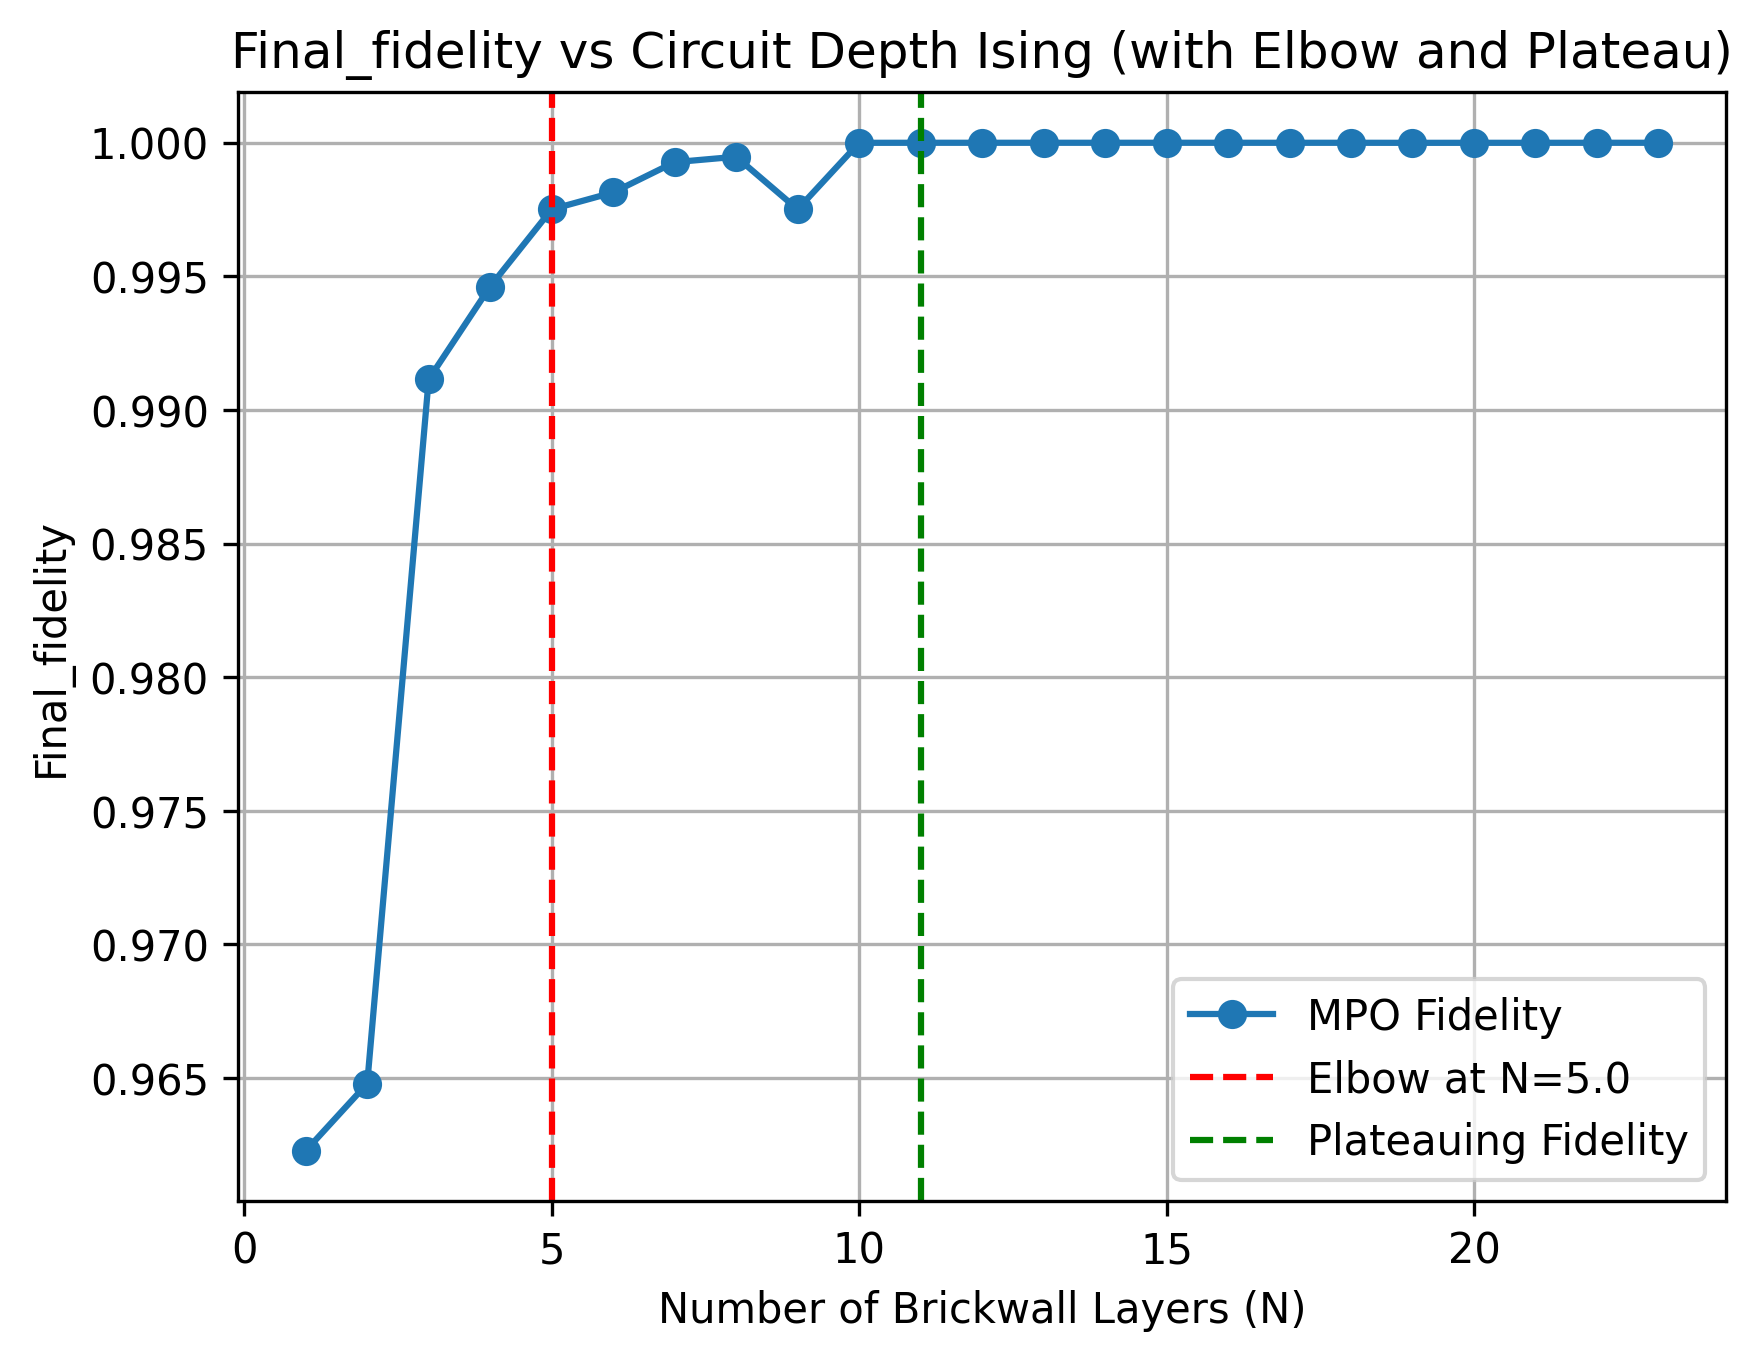


🔍 Suggested optimal compression depth: N = 11.0


In [65]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', t, 1e-3, method, system, save_path=True)

In [60]:
# Compress circuit
N_vals = [int(plateau_N)]
df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_HS_AQC(gates_optimised, config, simulator_settings, aqc_target_mps, aqc_comparison_circuit, aqc_target_circuit, N_vals, terms)

Starting fidelity: 0.8671937001815497
AQC Comparison circuit: depth 42
Target circuit:         depth 449
Hybrid ansatz circuit:  depth 23, with 270 parameters

=== Optimizing with N = 11 layers ===
2025-05-12 10:36:03.403979 Intermediate result: Fidelity 0.08979024
2025-05-12 10:36:03.409178 Intermediate result: Fidelity 0.08991437
2025-05-12 10:36:03.415603 Intermediate result: Fidelity 0.45678235
2025-05-12 10:36:03.420721 Intermediate result: Fidelity 0.50828033
2025-05-12 10:36:03.422388 Intermediate result: Fidelity 0.67262050
2025-05-12 10:36:03.424005 Intermediate result: Fidelity 0.82457833
2025-05-12 10:36:03.425620 Intermediate result: Fidelity 0.92788683
2025-05-12 10:36:03.427232 Intermediate result: Fidelity 0.95573165
2025-05-12 10:36:03.428820 Intermediate result: Fidelity 0.97228956
2025-05-12 10:36:03.430411 Intermediate result: Fidelity 0.98098942
2025-05-12 10:36:03.432000 Intermediate result: Fidelity 0.98436774
2025-05-12 10:36:03.433551 Intermediate result: Fideli

=== Compressed Optimised Circuit ===


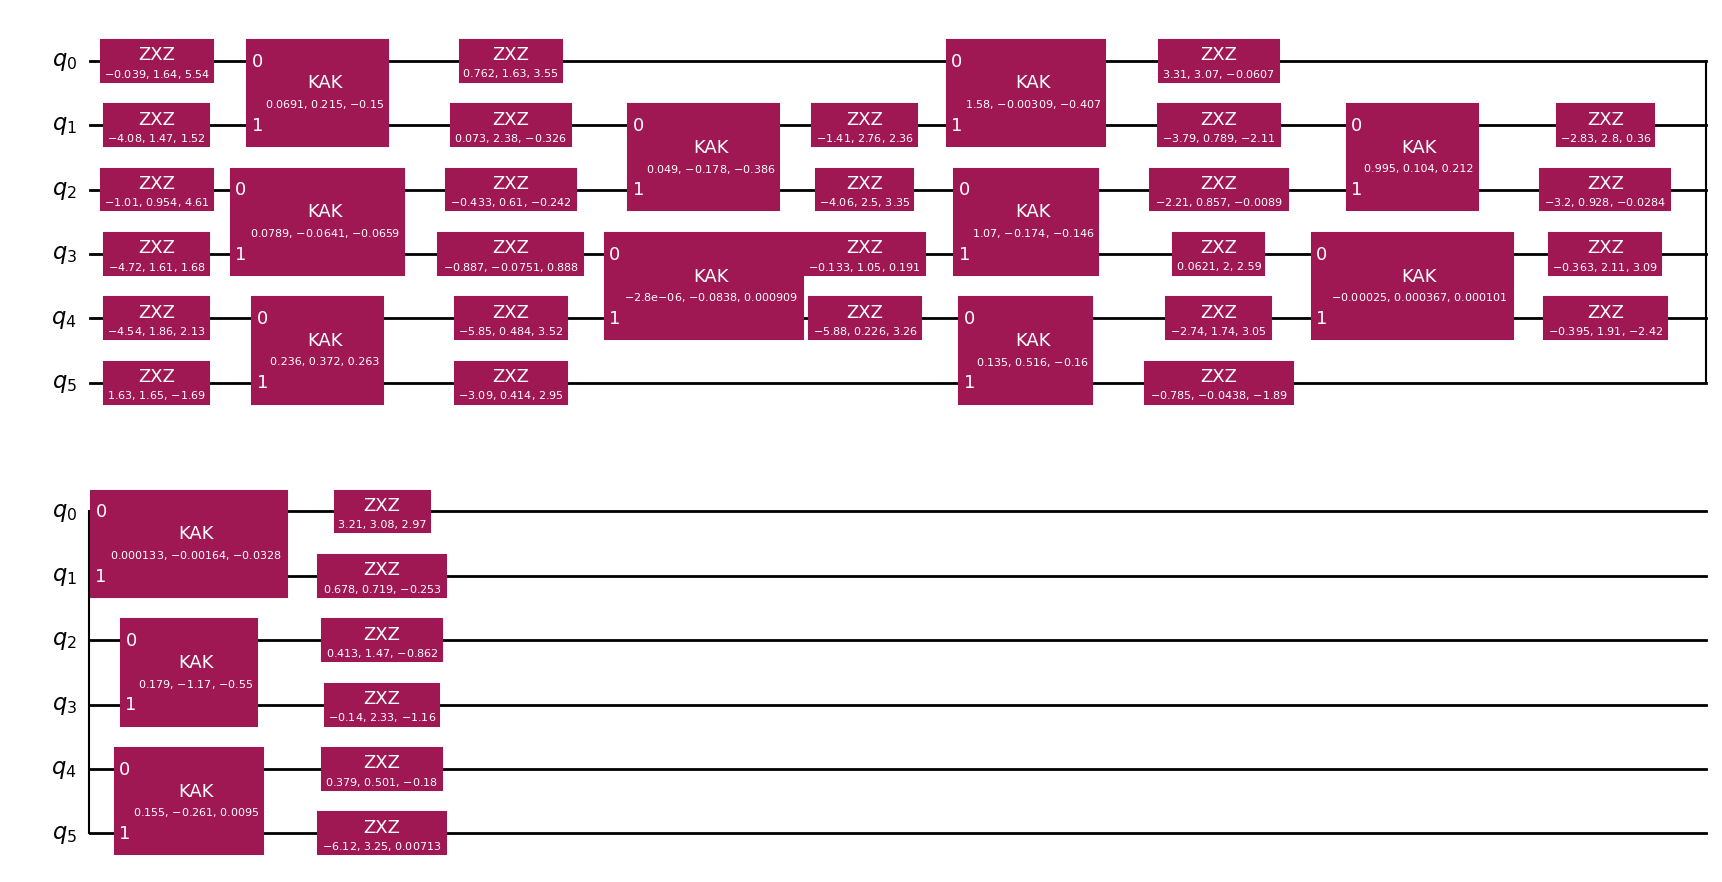

In [61]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(aqc_final_parameters_compressed)
aqc_optimised_compressed.draw("mpl")

In [62]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_hybrid_initial_parameters_Ising.csv', index=False)


=== Compressed Optimised Parameters ===
theta[0]: -0.038975
theta[1]: 1.635085
theta[2]: 5.542135
theta[3]: -4.075217
theta[4]: 1.466588
theta[5]: 1.524569
theta[6]: -1.012941
theta[7]: 0.954151
theta[8]: 4.612653
theta[9]: -4.721601
theta[10]: 1.607393
theta[11]: 1.677405
theta[12]: -4.543595
theta[13]: 1.860801
theta[14]: 2.132338
theta[15]: 1.631985
theta[16]: 1.647890
theta[17]: -1.689615
theta[18]: 0.069105
theta[19]: 0.214953
theta[20]: -0.149780
theta[21]: 0.762323
theta[22]: 1.633121
theta[23]: 3.550952
theta[24]: 0.073030
theta[25]: 2.381689
theta[26]: -0.326456
theta[27]: 0.078922
theta[28]: -0.064070
theta[29]: -0.065872
theta[30]: -0.433470
theta[31]: 0.610056
theta[32]: -0.242213
theta[33]: -0.887460
theta[34]: -0.075092
theta[35]: 0.888193
theta[36]: 0.236271
theta[37]: 0.372317
theta[38]: 0.263323
theta[39]: -5.850236
theta[40]: 0.484496
theta[41]: 3.517215
theta[42]: -3.091658
theta[43]: 0.413745
theta[44]: 2.951267
theta[45]: 0.048955
theta[46]: -0.177995
theta[47]: -

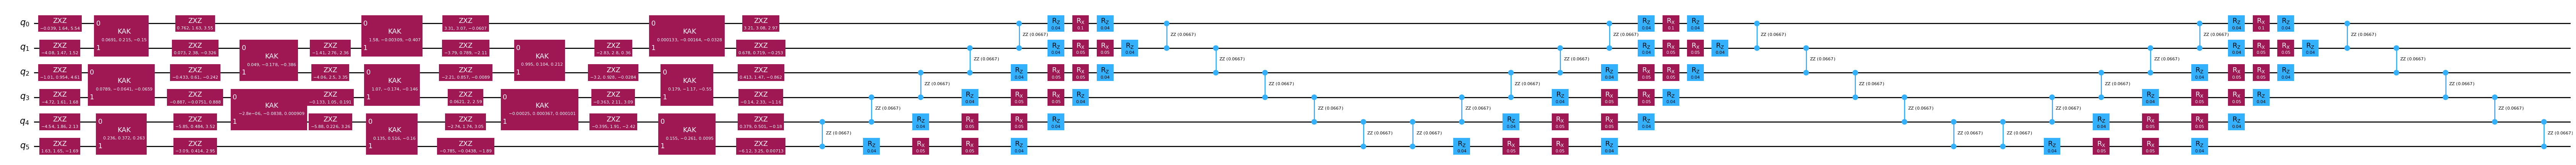

In [63]:
intermediate_composed_circuit = aqc_optimised_compressed.compose(subsequent_circuit)
intermediate_composed_circuit.draw("mpl", fold=-1)

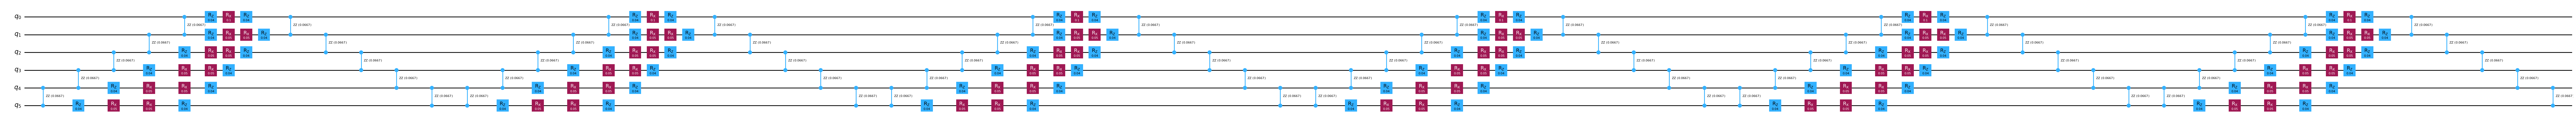

In [64]:
# merge comparison circuit with remaining time evolution circuit also
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

In [32]:
print(f"AQC Comparison circuit:    depth {aqc_comparison_circuit.depth()}")
print(f"Subsequent circuit:        depth {subsequent_circuit.depth()}")
print(f"Truncated Ansatz circuit:  depth {intermediate_composed_circuit.depth()}")

AQC Comparison circuit:    depth 84
Subsequent circuit:        depth 42
Truncated Ansatz circuit:  depth 44


In [33]:
import numpy as np
import jax.numpy as jnp
from qiskit.quantum_info import Operator

subsequent_gates = []

for instruction in subsequent_circuit.data:
    gate_matrix = Operator(instruction.operation).data
    qubits = [subsequent_circuit.find_bit(q).index for q in instruction.qubits]

    if len(qubits) == 2:
        # Already a 2-qubit gate
        gate_tensor = gate_matrix.reshape(2, 2, 2, 2)
        subsequent_gates.append(gate_tensor)

    elif len(qubits) == 1:
        # Promote to 2-qubit by acting on qubit + dummy
        q = qubits[0]
        dummy = (q + 1) % num_sites if num_sites > 1 else 0  # wrap around if needed

        if q < dummy:
            promoted = np.kron(gate_matrix, np.eye(2))  # acts on q first
        else:
            promoted = np.kron(np.eye(2), gate_matrix)  # acts on q second

        gate_tensor = promoted.reshape(2, 2, 2, 2)
        subsequent_gates.append(gate_tensor)

    else:
        raise ValueError("Only 1- or 2-qubit gates are supported.")


print("Total gates in circuit:", len(subsequent_circuit.data))
print("Total 2-qubit gates:", sum(1 for instr in subsequent_circuit.data if len(instr.qubits) == 2))

subsequent_gates = np.array(subsequent_gates)  # shape: (N_gates, 2, 2, 2, 2)
print("Gates shape:", subsequent_gates.shape)
print("Gate[0] norm:", jnp.linalg.norm(subsequent_gates[0].reshape(4, 4)))

Total gates in circuit: 99
Total 2-qubit gates: 30
Gates shape: (99, 2, 2, 2, 2)
Gate[0] norm: 2.0


In [34]:
from qiskit.quantum_info import Operator
reference_unitary = Operator(subsequent_circuit).data
print(reference_unitary.shape)

(64, 64)


In [29]:
import cotengra as ctg
import quimb.tensor as qtn

def matrix_gate(mat, qubits, gate_id):
    if len(qubits) == 1:
        inds = [f'q{qubits[0]}_in_{gate_id}', f'q{qubits[0]}_out_{gate_id}']
        tags = ['GATE', f'I{qubits[0]}']
    elif len(qubits) == 2:
        mat = mat.reshape(2, 2, 2, 2)
        inds = [
            f'q{qubits[0]}_in_{gate_id}', f'q{qubits[1]}_in_{gate_id}',
            f'q{qubits[0]}_out_{gate_id}', f'q{qubits[1]}_out_{gate_id}'
        ]
        tags = ['GATE', f'I{qubits[0]}', f'I{qubits[1]}']
    else:
        raise ValueError("Only 1- or 2-qubit gates are supported.")
    return qtn.Tensor(data=mat, inds=inds, tags=tags)

# Step 1: Build tensor list
gates_sub = []
for gate_id, instruction in enumerate(subsequent_circuit.data):
    gate_matrix = Operator(instruction.operation).data
    qubits = [subsequent_circuit.find_bit(q).index for q in instruction.qubits]
    gates_sub.append(matrix_gate(gate_matrix, qubits, gate_id))

print(f"Extracted {len(gates_sub)} total gates")

# Step 2: Build TN and tag by site
tn = qtn.TensorNetwork(gates_sub)
for i in range(num_sites):
    tn.add_tag(f"I{i}")

# Step 3: Contract site-wise (not fully) using optimizer
opt = ctg.HyperOptimizer(max_repeats=32, progbar=True)
for i in range(num_sites):
    tn.contract_tags(f"I{i}", optimize=opt)

tn.fuse_multibonds_()

# Step 4: View as MPO
U_ref_sub = tn.view_as_(
    qtn.MatrixProductOperator,
    cyclic=False,
    L=num_sites,
)
U_ref_sub.left_canonize(normalize=config['normalize_reference'])

print("✅ U_ref shape:", [t.shape for t in U_ref_sub])


Extracted 99 total gates


  0%|          | 0/32 [00:00<?, ?it/s]/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely

KeyboardInterrupt: 

In [35]:
import quimb.tensor as qtn

U_ref_sub_dense = U_ref_sub.to_dense()

# Compute the normalized Frobenius norm of the difference
diff_norm = np.linalg.norm(U_ref_sub_dense - reference_unitary) / np.linalg.norm(reference_unitary)
print(f"Normalized difference: {diff_norm}")

Normalized difference: 6.615064280482678e-15
U_ref shape: [(64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,), (64,)]


In [36]:
from qiskit_quimb import quimb_circuit

# Build the circuit directly
quimb_circ = quimb_circuit(subsequent_circuit)

# Get the unitary as an MPO directly (no need for contraction per site!)
U_ref_sub = quimb_circ.uni_mpo(normalize=config['normalize_reference'])

# Check the shape
print("U_ref shape:", [t.shape for t in U_ref_sub])


AttributeError: 'Circuit' object has no attribute 'uni_mpo'

In [33]:
from ropt_aqc.brickwall_opt import optimize_generic_circuit_RieADAM

gates_optimised, err_iter = optimize_generic_circuit_RieADAM(config, U_ref_sub, subsequent_gates)

Start Riemannian ADAM optimization ...


/Users/aag/Documents/ropt-aqc/ropt_aqc/util.py:138: SyntaxWarning: invalid escape sequence '\l'
  '''


AttributeError: 'list' object has no attribute '_last_gate_site'

# 2. Le + AQC

Pipeline: Isabel's code, tranform to quantum cirucit, mapping to qubits

1. Construct Hamiltonian

In [66]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms

num_sites = 6
degree = 2
n_repetitions = 5
n_id_layers = 0

In [111]:
# Ising-1d
J=1.
t = 0.25
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

2. Get Trotterised brickwall gates

In [112]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain
import numpy as np

gates_ising = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, g=g, h=h)
print(np.array(gates_ising).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 4, 4)


In [113]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates

gates_initial = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, g=g, h=h)
print(np.array(gates_initial).shape) 

(28, 4, 4)


3. View Initial Circuit

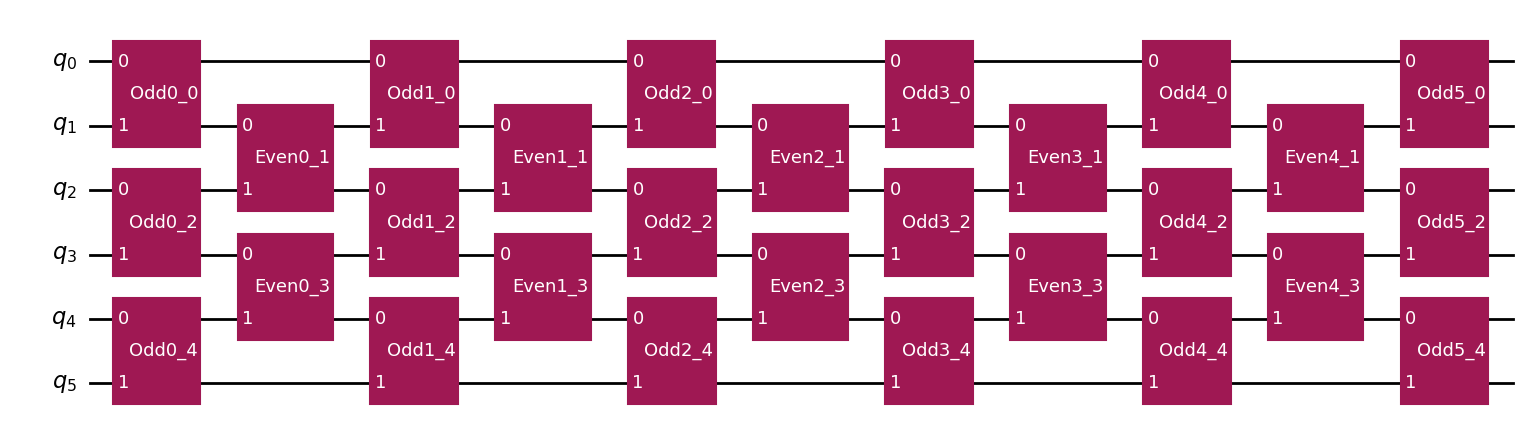

In [114]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_initial, pauli_terms=terms)
qc_initial.draw('mpl')

In [115]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, g=g, h=h)
print(np.array(gates).shape)  # Should be (N, 4, 4) for 2-qubit gates


(28, 2, 2, 2, 2)


Load Reference unitary - to be modified if n_repetitions changes

In [116]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, g, h= load_reference(config['reference_dir'], config['n_sites'], config['n_repetitions'], config['t'])

QR sweep on U_ref

In [117]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 64), (64, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


4. Optimisation of Frobenius norm

Start Riemannian ADAM optimization ...
	 0 	Current cost:  2.008498890685386
	 1 	Current cost:  1.9078233321622078
	 2 	Current cost:  1.823177689313328
	 3 	Current cost:  1.750742882658882
	 4 	Current cost:  1.6787583378122797
	 5 	Current cost:  1.5940984684980288
	 6 	Current cost:  1.4930502046378744
	 7 	Current cost:  1.381220807986079
	 8 	Current cost:  1.2656368211035818
	 9 	Current cost:  1.1518996882649524
	 10 	Current cost:  1.0463388241429779
	 11 	Current cost:  0.9579248493107788
	 12 	Current cost:  0.8979830115419816
	 13 	Current cost:  0.8737301435282898
	 14 	Current cost:  0.8777472010862049
	 15 	Current cost:  0.890267445707976
	 16 	Current cost:  0.8934184154279872
	 17 	Current cost:  0.8784240375976604
	 18 	Current cost:  0.8454695938533205
	 19 	Current cost:  0.8022391750505284
	 20 	Current cost:  0.7606761810762706
	 21 	Current cost:  0.7309660856407378
	 22 	Current cost:  0.7154873273686289
	 23 	Current cost:  0.708417223931012
	 24 	Current cos

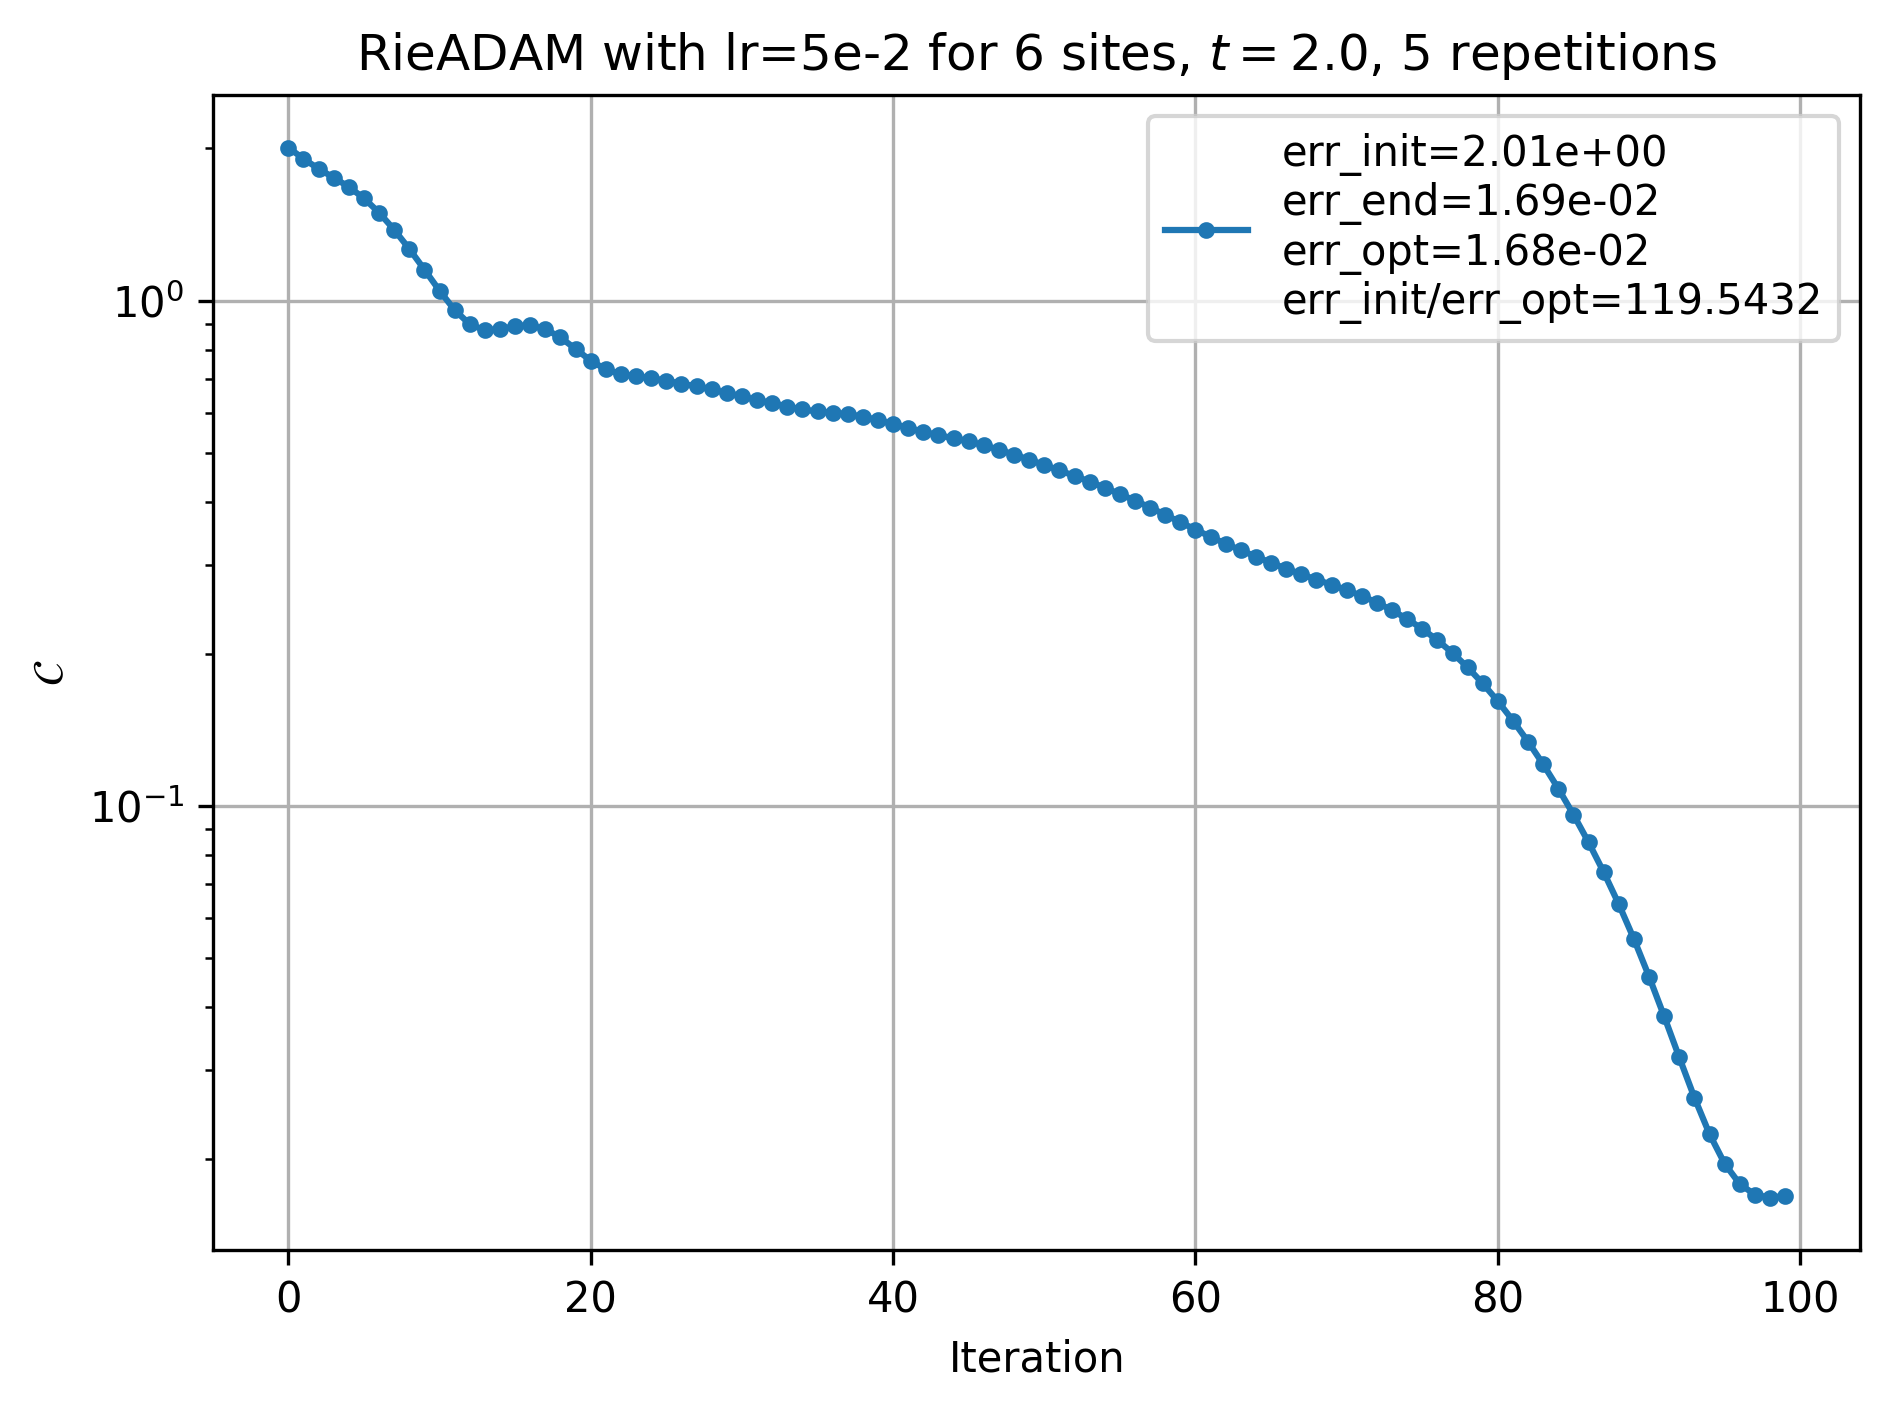

In [118]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM
import pdb

gates_optimised, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates)

Visualise optimised cirucit

In [119]:
gates_optimised = gates_optimised.reshape((len(gates_optimised), 4, 4))

In [120]:
np.allclose(gates_optimised, gates_initial)  # Should be False

False

In [121]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_observable

H_sparse = hamiltonian_to_sparse_observable(terms, num_qubits=num_sites)
print(H_sparse)

<SparseObservable with 17 terms on 6 qubits: (1+0j)(Z_5 Z_4) + (1+0j)(Z_4 Z_3) + (1+0j)(Z_3 Z_2) + (1+0j)(Z_2 Z_1) + (1+0j)(Z_1 Z_0) + (0.6+0j)(Z_5) + (0.75+0j)(X_5) + (0.6+0j)(Z_4) + (0.75+0j)(X_4) + (0.6+0j)(Z_3) + (0.75+0j)(X_3) + (0.6+0j)(Z_2) + (0.75+0j)(X_2) + (0.6+0j)(Z_1) + (0.75+0j)(X_1) + (0.6+0j)(Z_0) + (0.75+0j)(X_0)>


In [122]:
# construct initial state
from qiskit import QuantumCircuit

initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)

In [123]:
# Generate the AQC target circuit (initial segment)
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit = initial_state.copy()
aqc_target_circuit.compose(
    generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

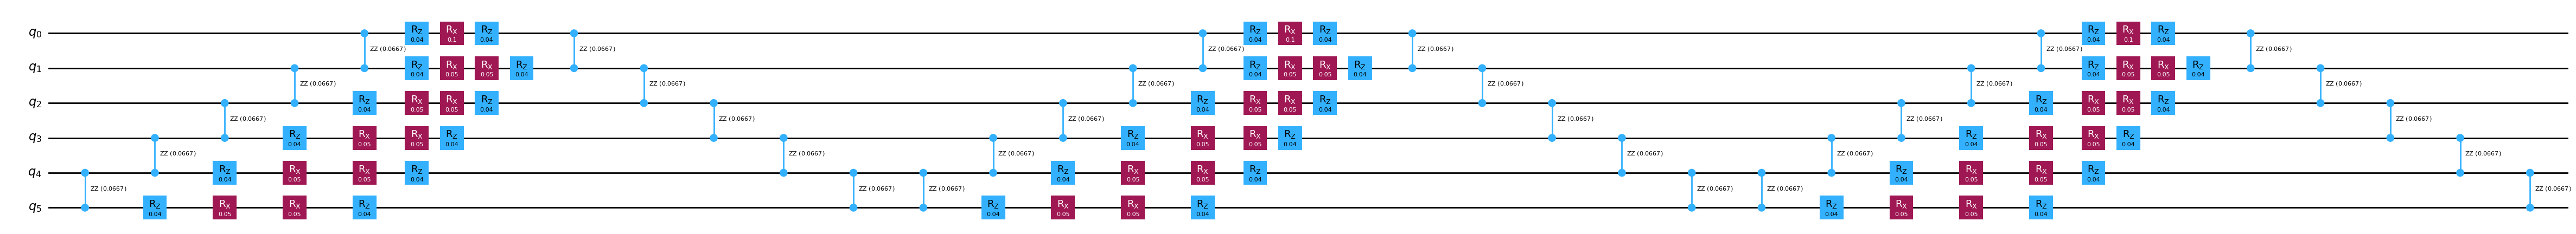

In [124]:
# Generate the subsequent circuit
subsequent_num_trotter_steps = 3
subsequent_evolution_time = 0.2

subsequent_circuit = generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
        time=subsequent_evolution_time,
    )
subsequent_circuit.draw("mpl", fold=-1)

In [125]:
# Generate the AQC comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps / subsequent_evolution_time * aqc_evolution_time
)

aqc_comparison_circuit = generate_time_evolution_circuit(
        H_sparse,
        synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
        time=aqc_evolution_time,
    )

In [126]:
# correct choice for reference circuit, should reflect the same physical system as the initial cirucit optimised with HS
from ropt_aqc.circuit_building import decompose_unitary_gate
ref_gates = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=200,
                                                   hamiltonian=system, degree=degree, J=J, g=g, h=h)

ref_circuit = transform_to_bw_qc_unitarygate(num_sites=num_sites, system=system, gates=ref_gates)
native_ref_circuit = decompose_unitary_gate(ref_circuit)

In [127]:
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit import transpile

native_ref_circuit_transpiled = transpile(
    native_ref_circuit,
    basis_gates=['rx', 'ry', 'rz', 'cx'],
    optimization_level=3
)

simulator_settings = QuimbSimulator(qtn.CircuitMPS, autodiff_backend="jax")
aqc_target_mps = tensornetwork_from_circuit(native_ref_circuit_transpiled, simulator_settings)


In [128]:
from ropt_aqc.comparison_methods import compress_HS_AQC

N_vals = range(1,15)
df, aqc_ansatz, aqc_initial_parameters, aqc_final_parameters = compress_HS_AQC(gates_optimised, config, simulator_settings, aqc_target_mps, aqc_comparison_circuit, aqc_target_circuit, N_vals)


=== Optimizing with N = 1 layers ===
(3, 4, 4)
Starting fidelity: 0.3926402033272828
AQC Comparison circuit: depth 42
Target circuit:         depth 449
Hybrid ansatz circuit:  depth 3, with 45 parameters
2025-05-05 14:31:28.948717 Intermediate result: Fidelity 0.87343909
2025-05-05 14:31:28.950254 Intermediate result: Fidelity 0.93132821
2025-05-05 14:31:28.950892 Intermediate result: Fidelity 0.94351906
2025-05-05 14:31:28.951491 Intermediate result: Fidelity 0.94772821
2025-05-05 14:31:28.952095 Intermediate result: Fidelity 0.94895647
2025-05-05 14:31:28.952692 Intermediate result: Fidelity 0.95100273
2025-05-05 14:31:28.953320 Intermediate result: Fidelity 0.95337988
2025-05-05 14:31:28.953928 Intermediate result: Fidelity 0.95583912
2025-05-05 14:31:28.955178 Intermediate result: Fidelity 0.95660552
2025-05-05 14:31:28.955806 Intermediate result: Fidelity 0.95691917
2025-05-05 14:31:28.956417 Intermediate result: Fidelity 0.95696809
2025-05-05 14:31:28.957030 Intermediate result:

In [ ]:
import pandas as pd
file_path_ising = '/Users/aag/Documents/ropt-aqc/method_comparison/hybrid_Ising_results.csv'

# df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)

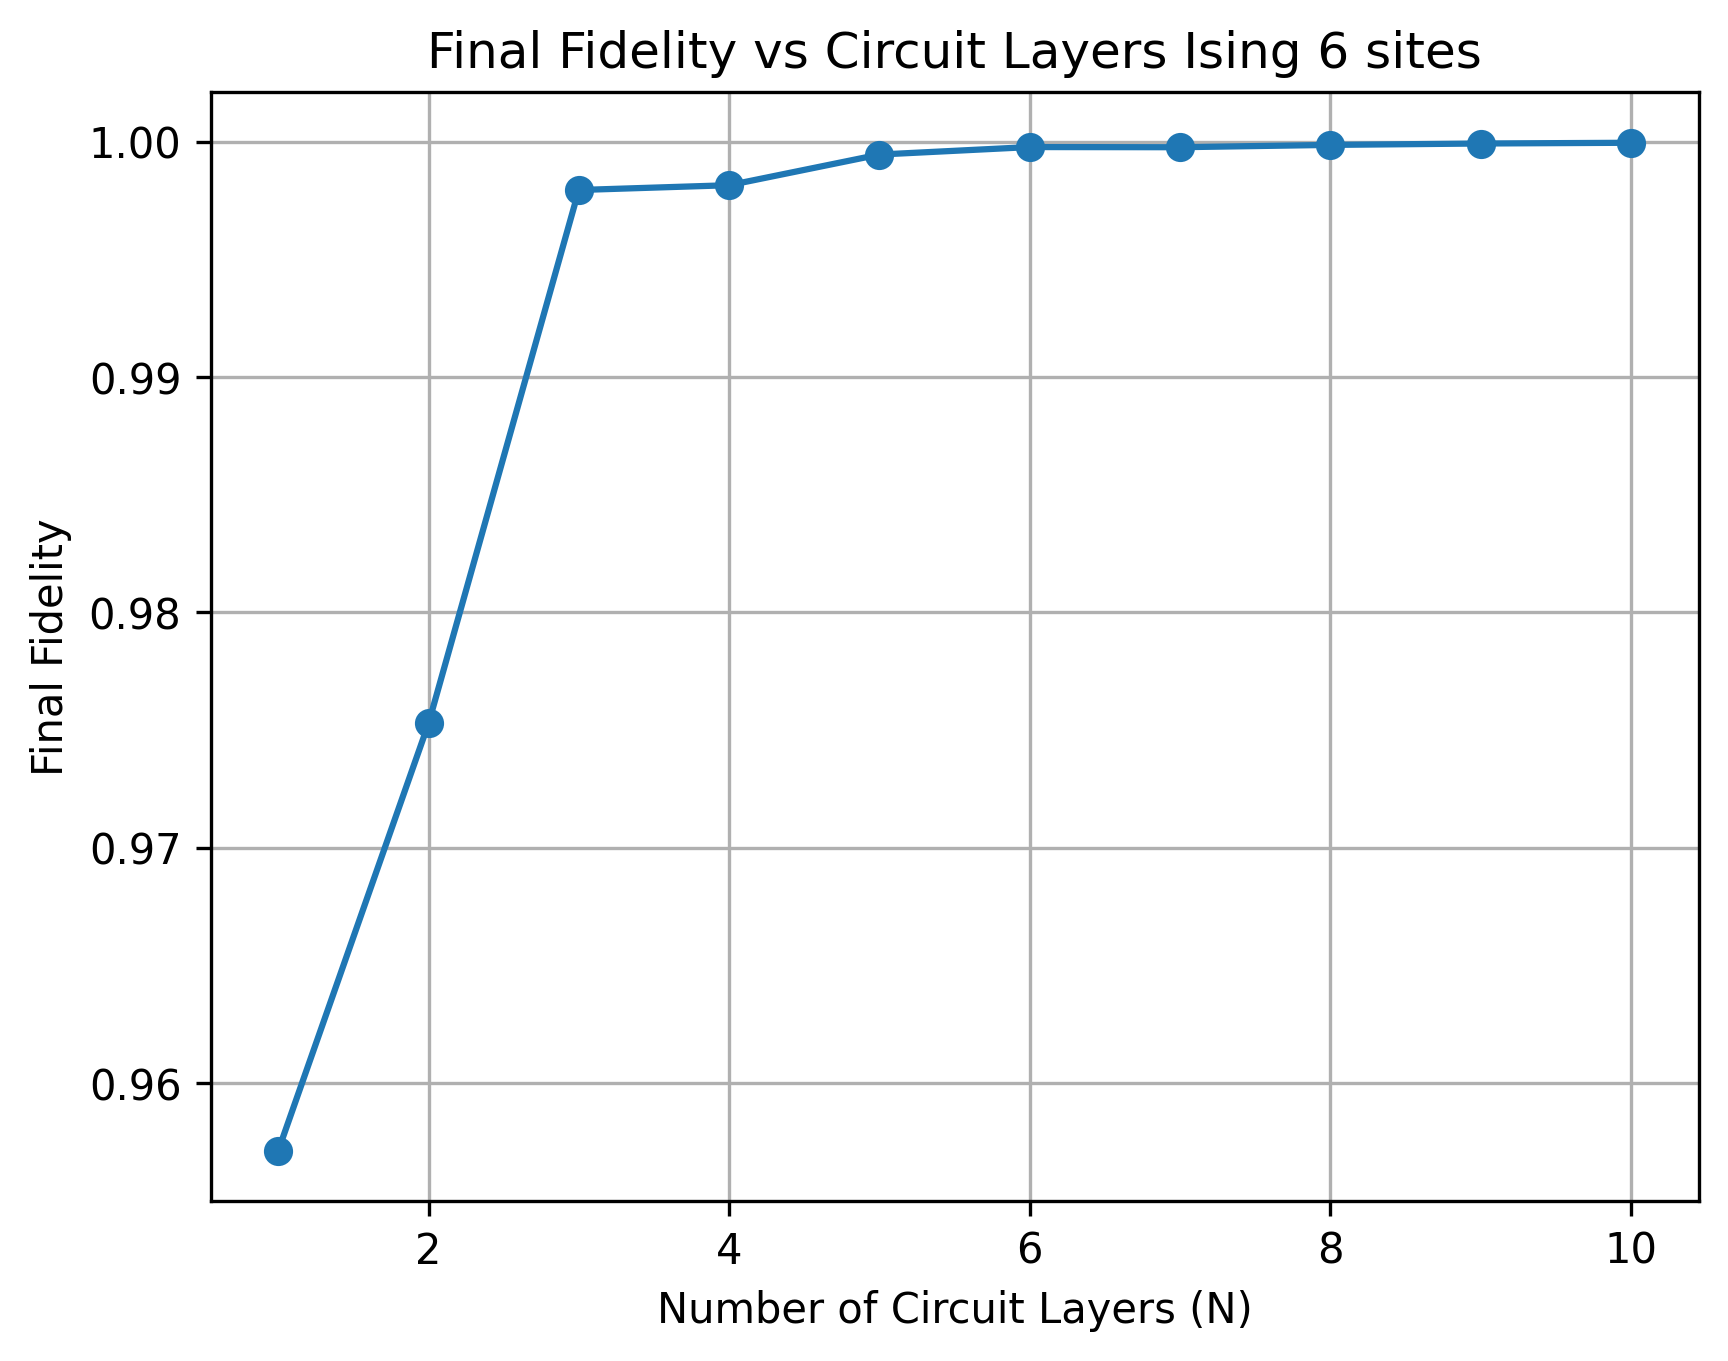

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv(file_path_ising)

# Plot MPO fidelity
plt.figure(dpi=300)
plt.plot(df['circuit_layers'], df['Final_fidelity'], marker='o')
plt.title('Final Fidelity vs Circuit Layers Ising 6 sites')
plt.xlabel('Number of Circuit Layers (N)')
plt.ylabel('Final Fidelity')
plt.grid(True)
plt.show()

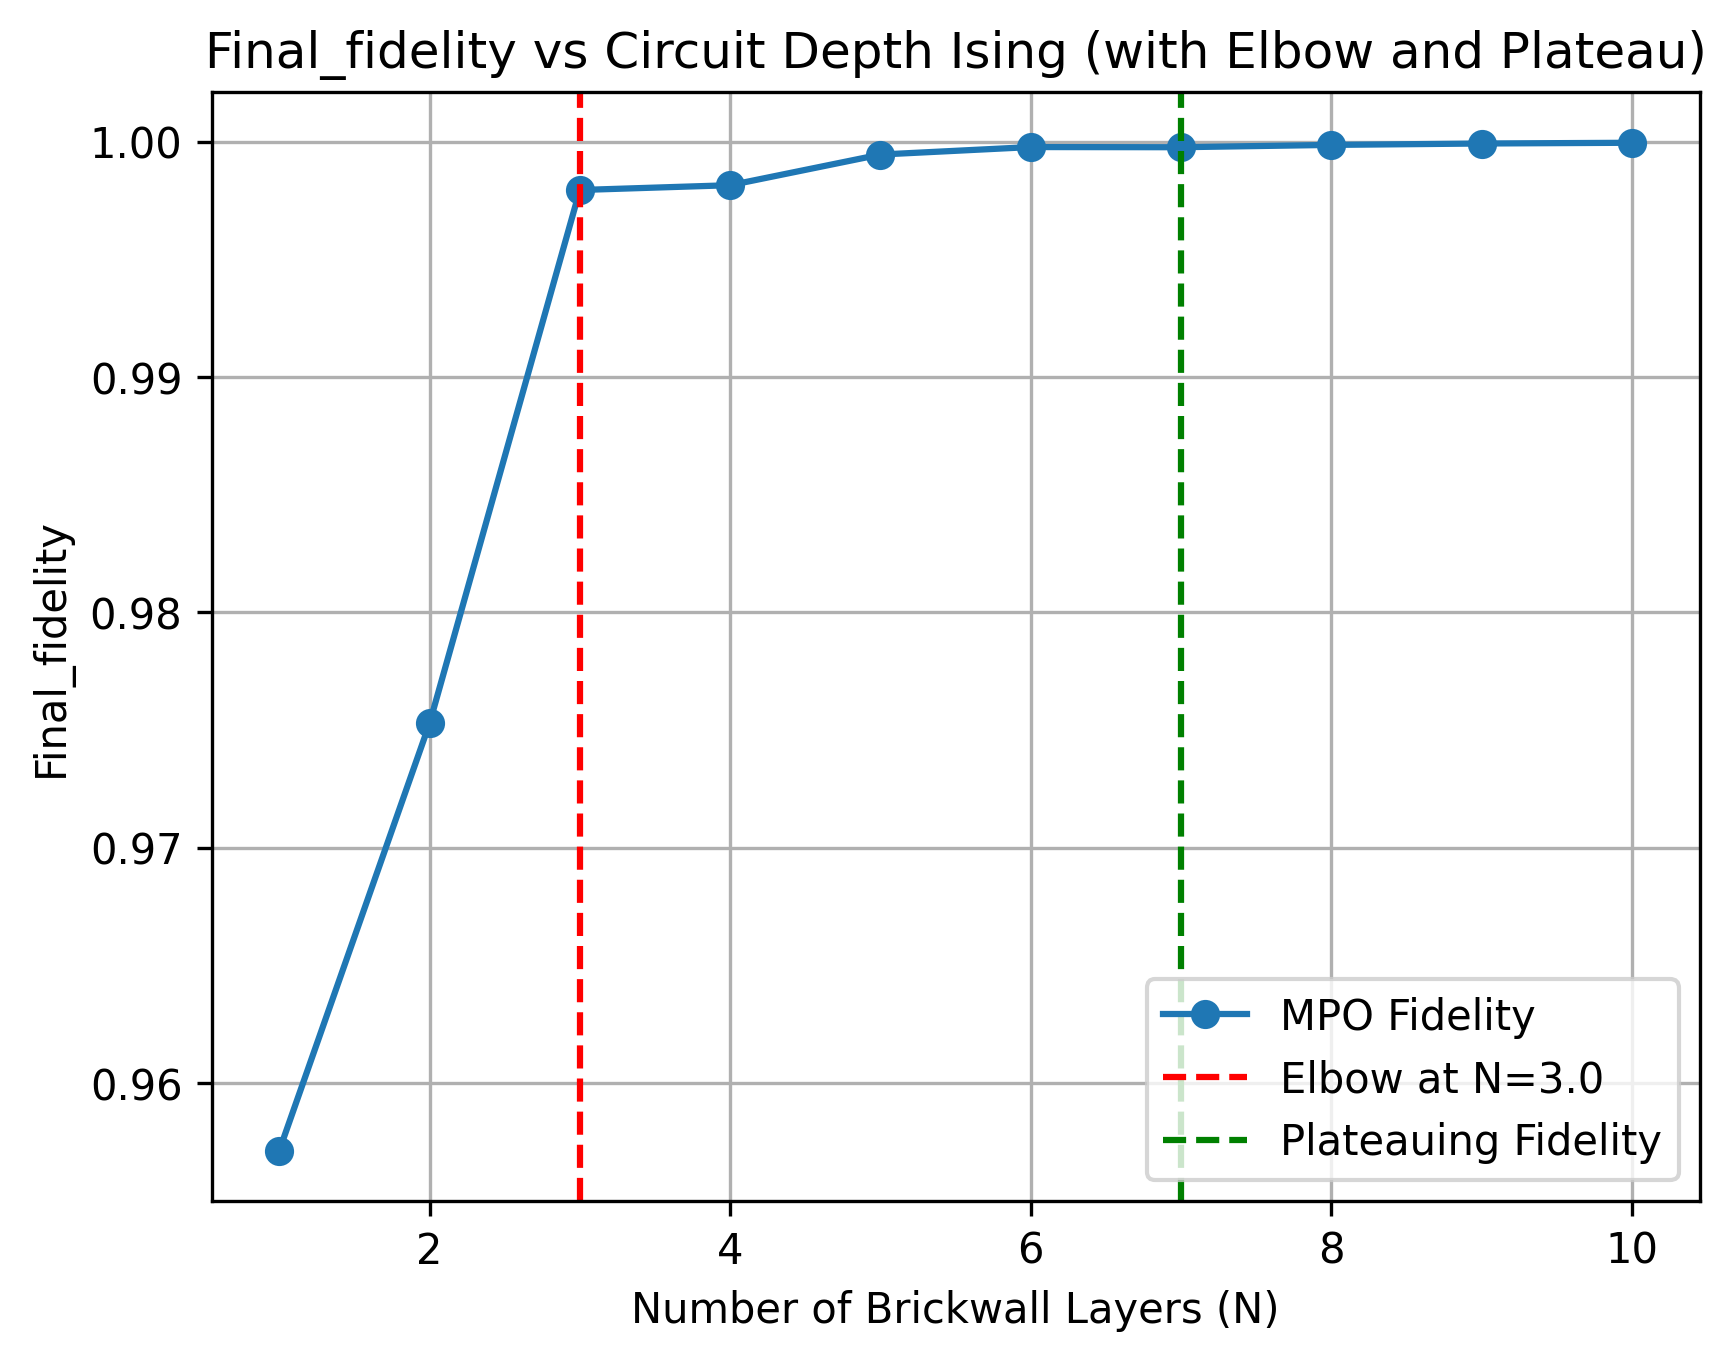


🔍 Suggested optimal compression depth: N = 7.0


In [ ]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', n_repetitions, method, system)

In [ ]:
parameters = [float(param) for param in aqc_final_parameters]
print("Final parameters:", parameters)

Final parameters: [-7.267144520498655, 1.6176385610576594, 1.613909403596058, -1.3475379655209585, 1.711776367373394, -1.7216105265229502, -1.4652731708040594, 1.508174208627659, 1.5095693953452003, 1.6763194827845012, 1.636620839102241, -1.5042591772133376, -4.489130619107897, 1.4251951877124631, -1.4178732595192067, -4.125551866905823, 1.5262884172968252, 1.5382337596392834, 0.2711232932610449, 0.0010734056569535336, 0.009279335392425881, -2.7853885574698873, 0.16425896670320922, 5.93193491935241, -0.16525642153921097, 3.0519171884791807, 0.005438329526982632, 0.11144338785057618, 0.010819926769047875, 0.0946859478039505, -2.99455271995859, 3.267449942351498, -2.739345221247918, -3.284243745361197, -0.12606210972748894, -2.734470066223743, 0.26685478883581815, -0.0018821641391242152, 0.006320058786695906, -2.97498744762209, 0.0867096586100942, 0.007186670232897586, -0.34613700161776134, 2.9702149228366657, 5.922567006508903, 0.09441536509288291, -0.15668247754911202, 0.11567849663546

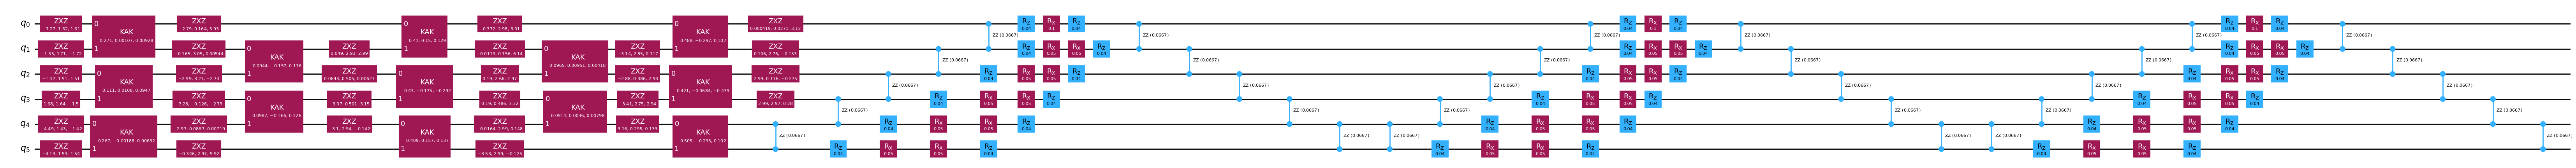

In [ ]:
from ropt_aqc.circuit_building import truncate_ansatz

# N = plateau_N, elbow_N, (plateau_N + elbow_N)//2
N_truncation = 6

aqc_circuit_optimised = aqc_ansatz.assign_parameters(aqc_final_parameters)
truncated_ansatz = truncate_ansatz(aqc_circuit_optimised, N_truncation)
intermediate_composed_circuit = truncated_ansatz.compose(subsequent_circuit)
intermediate_composed_circuit.draw("mpl", fold=-1)

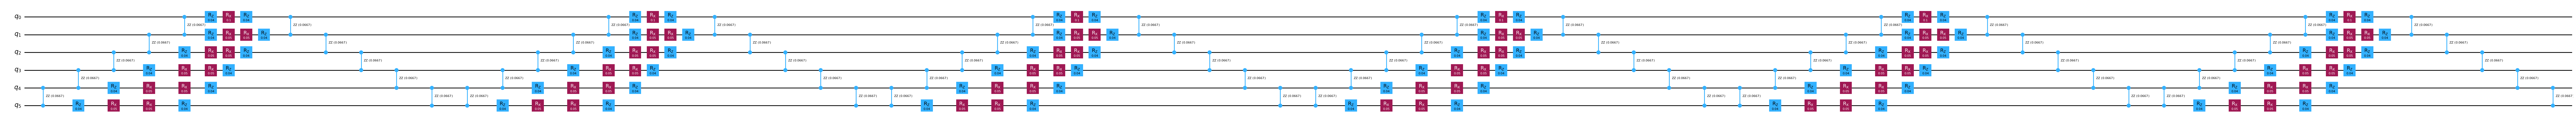

In [ ]:
# merge comparison circuit with remaining time evolution circuit also
aqc_comparison_circuit.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit.draw("mpl", fold=-1)

In [ ]:
print(f"AQC Comparison circuit:    depth {aqc_comparison_circuit.depth()}")
print(f"Subsequent circuit:        depth {subsequent_circuit.depth()}")
print(f"Truncated Ansatz circuit:  depth {intermediate_composed_circuit.depth()}")

AQC Comparison circuit:    depth 84
Subsequent circuit:        depth 42
Truncated Ansatz circuit:  depth 52


In [ ]:
import jax.numpy as jnp
from ropt_aqc.brickwall_circuit import get_gate_qubit_pairs

subsequent_gates = get_initial_gates(num_sites, t, n_repetitions, degree, system, n_id_layers, use_TN=True, J=J, g=g, h=h)

print("Gates shape:", subsequent_gates.shape)
print("Gate[0] norm:", jnp.linalg.norm(subsequent_gates[0].reshape(4, 4)))

Gates shape: (28, 2, 2, 2, 2)
Gate[0] norm: 2.0


In [ ]:
from qiskit.quantum_info import Operator
reference_unitary = Operator(subsequent_circuit).data
# reference_unitary = Operator(subsequent_circuit.reverse_bits()).data
# print(reference_unitary.shape)

In [ ]:
from quimb.tensor.tensor_1d import apply_gate

def apply_gate_to_mpo(mpo, gate_matrix, qubits):
    """
    Apply a 1- or 2-qubit unitary gate to a quimb MPO using `apply_gate`.
    """
    return apply_gate(mpo, gate_matrix, qubits, contract=True)



from quimb.tensor import MPO_identity
from qiskit.quantum_info import Operator

U_ref = MPO_identity(num_sites, phys_dim=2)

for instruction in subsequent_circuit.data:
    op = Operator(instruction.operation)
    qubits = [subsequent_circuit.find_bit(q).index for q in instruction.qubits]
    U_ref = apply_gate_to_mpo(U_ref, op.data, qubits)


ImportError: cannot import name 'apply_gate' from 'quimb.tensor.tensor_1d' (/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/quimb/tensor/tensor_1d.py)

In [ ]:
import jax.numpy as jnp

def apply_two_site_gate_to_mpo(mpo, gate, site1, site2, max_bondim=512):
    assert site2 == site1 + 1, "Only adjacent sites are supported."

    A1 = mpo[site1]
    A2 = mpo[site2]
    assert A1.shape[3] == A2.shape[0], "Bond mismatch"

    # Merge tensors
    T = jnp.einsum('lpqr,rmst->lpmqst', A1, A2).transpose(0, 1, 3, 2, 4, 5)
    T = T.reshape(A1.shape[0]*A2.shape[1], 4, A2.shape[2]*A2.shape[3])
    T = jnp.einsum('ij,ajk->aik', gate.reshape(4, 4), T).reshape(T.shape[0], -1)

    U, S, Vh = jnp.linalg.svd(T, full_matrices=False)
    chi = min(len(S), max_bondim)
    sqrt_S = jnp.sqrt(S[:chi])
    U = U[:, :chi] @ jnp.diag(sqrt_S)
    Vh = jnp.diag(sqrt_S) @ Vh[:chi, :]

    left_dim = A1.shape[0]
    right_dim = A2.shape[3]

    # --- A1 reshape ---
    try:
        A1_new = U.reshape(left_dim, 2, 2, chi)
    except Exception as e:
        print("⚠️ A1 reshape fallback — padding U")
        padded = jnp.zeros((left_dim * 4, chi), dtype=U.dtype)
        padded = padded.at[:U.shape[0], :U.shape[1]].set(U)
        A1_new = padded.reshape(left_dim, 2, 2, chi)

    # --- A2 reshape ---
    try:
        A2_new = Vh.reshape(chi, 2, 2, right_dim)
    except Exception as e:
        print("⚠️ A2 reshape fallback — padding Vh")
        required_size = chi * 2 * 2 * right_dim
        flat = Vh.flatten()

        padded = jnp.zeros((required_size,), dtype=Vh.dtype)
        padded = padded.at[:flat.size].set(flat[:min(flat.size, required_size)])  # Truncate if necessary
        A2_new = padded.reshape(chi, 2, 2, right_dim)


    return mpo[:site1] + [A1_new, A2_new] + mpo[site2+1:]


In [ ]:
from ropt_aqc.tn_brickwall_methods import get_id_mpo
from ropt_aqc.comparison_methods import compute_error_mpo

mpo = get_id_mpo(num_sites)  # (Dl, 2, 2, Dr) format

def compute_reference_from_circuit(config, circuit, ref_batch=0, ref_seed=0):
    from qiskit.quantum_info import Operator
    from ropt_aqc.tn_helpers import get_id_mpo, compress_mpo
    from ropt_aqc.save_model import save_reference

    import os
    from time import time
    tstart = time()

    n_sites = config["n_sites"]
    bond_dim = 128
    compress = config.get("compress", True)

    mpo = get_id_mpo(n_sites)  # Start from identity

    # Apply each gate in the circuit
    for inst in circuit.data:
        gate = inst.operation
        qubits = [circuit.find_bit(q).index for q in inst.qubits]

        if len(qubits) == 1:
            q0 = qubits[0]
            U = Operator(gate).data
            I = jnp.eye(2)
            if q0 < n_sites - 1:
                U_ext = jnp.kron(U, I).reshape(4, 4)
                mpo = apply_two_site_gate_to_mpo(mpo, U_ext, q0, q0+1, max_bondim=bond_dim)
            else:
                U_ext = jnp.kron(I, U).reshape(4, 4)
                mpo = apply_two_site_gate_to_mpo(mpo, U_ext, q0-1, q0, max_bondim=bond_dim)

        elif len(qubits) == 2:
            q0, q1 = sorted(qubits)
            assert q1 == q0 + 1, "Only adjacent 2-qubit gates are supported"
            U = Operator(gate).data
            mpo = apply_two_site_gate_to_mpo(mpo, U, q0, q1, max_bondim=bond_dim)

    # Compress
    if compress:
        mpo_comp = compress_mpo(mpo, bond_dim)
        err = compute_error_mpo(mpo, mpo_comp)
        print(f"Compression error: {err}")
        mpo = mpo_comp

    path = os.path.join(os.getcwd(), config['hamiltonian'], "reference")
    print("Saving to path:", path)
    # # _ = save_reference(path, mpo, config["t"], config["n_sites"], config["degree"], config["n_repetitions"],
    #                    err_threshold=None, hamiltonian=config["hamiltonian"],
    #                    H=None, ref_seed=ref_seed, ref_nbr=ref_batch)


    return mpo

U_ref_sub =compute_reference_from_circuit(config, subsequent_circuit)
print("U_ref shape:", [m.shape for m in U_ref_sub])


⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 

In [ ]:
from ropt_aqc.brickwall_circuit import get_gate_qubit_pairs

flat_gate_list, _ = get_gate_qubit_pairs(
    subsequent_gates,
    n_sites=num_sites,
    degree=degree,
    n_repetitions=n_repetitions,
    n_id_layers=n_id_layers,
    hamiltonian=system
)
print(flat_gate_list[:2])
flat_gate_list = [item for layer in flat_gate_list for item in layer]



[[(1, 2, Array([[[[ 0.91501807+0.36850438j, -0.0088359 +0.0727204j ],
         [-0.00880025+0.14621611j, -0.01108941-0.00074142j]],

        [[-0.0088359 +0.0727204j ,  0.97628002-0.13866466j],
         [-0.01108927+0.00074571j,  0.00894293+0.14859209j]]],


       [[[-0.00880025+0.14621611j, -0.01108927+0.00074571j],
         [ 0.95256573-0.2560946j ,  0.0089071 +0.07331182j]],

        [[-0.01108941-0.00074142j,  0.00894293+0.14859209j],
         [ 0.0089071 +0.07331182j,  0.98581921+0.02057714j]]]],      dtype=complex128)), (3, 4, Array([[[[ 0.94372307+0.31375063j, -0.00443844+0.07374533j],
         [-0.00443844+0.07374533j, -0.0055704 -0.00037228j]],

        [[-0.00443844+0.07374533j,  0.97449621-0.19829598j],
         [-0.00557037+0.00037335j,  0.00447421+0.07434098j]]],


       [[[-0.00443844+0.07374533j, -0.00557037+0.00037335j],
         [ 0.97449621-0.19829598j,  0.00447421+0.07434098j]],

        [[-0.0055704 -0.00037228j,  0.00447421+0.07434098j],
         [ 0.00447421+0.0

In [ ]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def convert_unitary_to_mpo_quimb(U, n_sites, max_bond_dim=None):
    """
    Convert a dense unitary to MPO format (Dl, 2, 2, Dr) using Quimb.

    Args:
        U: np.ndarray of shape (2^n, 2^n)
        n_sites: number of qubits
        max_bond_dim: optional max bond dim

    Returns:
        List of np.arrays shaped (Dl, 2, 2, Dr)
    """
    # Build MPO from dense unitary
    mpo = qtn.MatrixProductOperator.from_dense(U, dims=[2] * n_sites)

    if max_bond_dim:
        mpo.compress(max_bond=max_bond_dim)

    mpo_tensors = []
    for site in range(n_sites):
        A = mpo[site].data  # raw tensor
        shape = A.shape

        # Find positions of physical (2,2) and bond dimensions
        phys_inds = [i for i, s in enumerate(shape) if s == 2]
        bond_inds = [i for i, s in enumerate(shape) if s != 2]

        assert len(phys_inds) == 2, f"Site {site} should have exactly 2 physical legs"
        assert len(bond_inds) in [1, 2], f"Site {site} should have 1 or 2 bond legs"

        # If only one bond (at edge), prepend or append singleton
        if len(bond_inds) == 1:
            if bond_inds[0] < phys_inds[0]:  # bond is left
                bond_order = (bond_inds[0], phys_inds[0], phys_inds[1])
                A = A.transpose(bond_order).reshape(1, 2, 2, shape[bond_inds[0]])
            else:  # bond is right
                bond_order = (phys_inds[0], phys_inds[1], bond_inds[0])
                A = A.transpose(bond_order).reshape(shape[bond_inds[0]], 2, 2, 1)
        else:
            Dl, Dr = shape[bond_inds[0]], shape[bond_inds[1]]
            A = A.transpose(bond_inds[0], phys_inds[0], phys_inds[1], bond_inds[1]).reshape(Dl, 2, 2, Dr)

        mpo_tensors.append(A)

    return mpo_tensors


U_ref_sub = convert_unitary_to_mpo_quimb(reference_unitary, n_sites=6)
print("U_ref shape:", [m.shape for m in U_ref_sub])

U_ref shape: [(4, 2, 2, 1), (4, 2, 2, 4), (4, 2, 2, 4), (4, 2, 2, 4), (4, 2, 2, 4), (1, 2, 2, 4)]


In [ ]:
from ropt_aqc.brickwall_circuit import get_gates_per_layer
from ropt_aqc.tn_brickwall_methods import contract_layers_of_swap_network_with_mpo, get_id_mpo
from ropt_aqc.comparison_methods import compute_error_mpo

mpo_id = get_id_mpo(nsites=6)
gates_per_layer, layer_is_odd = get_gates_per_layer(
    gates, n_sites=num_sites, degree=degree, n_repetitions=n_repetitions, hamiltonian=system 
)

mpo_init = contract_layers_of_swap_network_with_mpo(
    mpo_id, gates_per_layer, layer_is_odd, layer_is_left=True, max_bondim=128, get_norm=False
)
err = compute_error_mpo(U_ref, mpo_init)
print(f"Initial MPO fidelity error: {err:.4e}")



Initial MPO fidelity error: 1.9898e+00


In [ ]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def convert_unitary_to_mpo_quimb_fixed(U, n_sites, max_bond_dim=None):
    """
    Convert a dense unitary matrix U into an MPO compatible with (Dl, 2, 2, Dr) format.
    Handles physical axis reordering and compression.

    Args:
        U: np.ndarray of shape (2^n, 2^n)
        n_sites: number of qubits
        max_bond_dim: optional max bond dim

    Returns:
        List of np.arrays shaped (Dl, 2, 2, Dr)
    """
    mpo = qtn.MatrixProductOperator.from_dense(U, dims=[2]*n_sites)

    if max_bond_dim:
        mpo.compress(max_bond=max_bond_dim)

    mpo_tensors = []

    for i, site in enumerate(mpo):
        A = site.data
        shape = A.shape

        if len(shape) == 3:
            # Boundary tensor: (2, 2, D)
            if shape[0] == 2 and shape[1] == 2:
                # left boundary
                A = A.transpose(2, 0, 1).reshape(1, 2, 2, shape[2])
            else:
                # right boundary
                A = A.transpose(0, 1, 2).reshape(shape[0], 2, 2, 1)

        elif len(shape) == 4:
            # Middle tensor: (Dl, 2, 2, Dr)
            if shape[1] == 2 and shape[2] == 2:
                pass  # correct order already
            else:
                raise ValueError(f"Unexpected tensor shape at site {i}: {shape}")
        else:
            raise ValueError(f"Invalid MPO tensor rank at site {i}: {shape}")

        mpo_tensors.append(A)

    return mpo_tensors


from ropt_aqc.tn_helpers import mpo_to_dense
U = Operator(subsequent_circuit).data
U_ref = convert_unitary_to_mpo_quimb_fixed(U, n_sites=6)

U_ref_sub = [jnp.asarray(A) for A in U_ref]
U_ref_dense = mpo_to_dense(U_ref_sub)

diff_norm = jnp.linalg.norm(U_ref_dense - U)
print("‖U_ref_dense - reference_unitary‖ =", diff_norm)

err_unitary = jnp.linalg.norm(U_ref_dense.conj().T @ U_ref_dense - jnp.eye(U_ref_dense.shape[0]))
print("‖U†U - I‖ =", err_unitary)

‖U_ref_dense - reference_unitary‖ = 7.7297986187921355
‖U†U - I‖ = 7.86497259258521


In [ ]:
import numpy as np
import jax.numpy as jnp

def convert_unitary_to_mpo_manual(U, n_sites, max_bond_dim=None):
    """
    Convert a unitary matrix U (2^n × 2^n) into an MPO: list of (Dl, 2, 2, Dr) tensors.
    Guaranteed unitary-preserving structure.
    """
    assert U.shape == (2**n_sites, 2**n_sites)

    # Step 1: reshape into 2n tensor (i0...in-1, j0...jn-1)
    U_tensor = U.reshape([2] * (2 * n_sites))

    # Interleave physical indices: (i0, j0, i1, j1, ..., in-1, jn-1)
    U_tensor = U_tensor.transpose(
        [i for pair in zip(range(n_sites), range(n_sites, 2 * n_sites)) for i in pair]
    )

    # Group into (1, 4, 4, ..., 4, 1)
    U_tensor = U_tensor.reshape((1,) + (4,) * n_sites + (1,))
    mpo = []
    tensor = U_tensor

    for i in range(n_sites - 1):
        Dl = tensor.shape[0]
        Dp = tensor.shape[1]
        Dr = int(np.prod(tensor.shape[2:]))

        tensor = tensor.reshape(Dl * Dp, Dr)

        # SVD
        U_svd, S, Vh = np.linalg.svd(tensor, full_matrices=False)
        chi = min(len(S), max_bond_dim or len(S))

        U_svd = U_svd[:, :chi]
        S = S[:chi]
        Vh = Vh[:chi, :]

        U_svd = U_svd @ np.diag(np.sqrt(S))
        Vh = np.diag(np.sqrt(S)) @ Vh

        # Reshape U_svd into MPO tensor
        A = U_svd.reshape(Dl, 2, 2, chi)
        mpo.append(jnp.asarray(A))

        # Reshape Vh to feed into next loop
        remaining_dim = tensor.shape[1]
        tensor = Vh.reshape(chi, *(tensor.shape[1:]))

    # Final site
    A_last = tensor.reshape(tensor.shape[0], 2, 2, 1)
    mpo.append(jnp.asarray(A_last))

    return mpo


U = Operator(subsequent_circuit).data
U_ref_mpo = convert_unitary_to_mpo_manual(U, n_sites=6)
U_dense = mpo_to_dense(U_ref_mpo)

print("‖U_dense - U_ref‖ =", jnp.linalg.norm(U_dense - U))
print("‖U†U - I‖ =", jnp.linalg.norm(U_dense.conj().T @ U_dense - jnp.eye(U.shape[0])))


ValueError: cannot reshape array of size 4096 into shape (4,2,2,1)

In [ ]:
from ropt_aqc.tn_helpers import get_id_mpo

mpo = get_id_mpo(num_sites)
for q0, q1, gate in flat_gate_list: 
    mpo = apply_two_site_gate_to_mpo(mpo, gate, q0, q1, 128)


⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh


/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:137: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


ValueError: Incompatible shapes for broadcasting: (16,) and requested shape (2, 4)

In [ ]:
from ropt_aqc.tn_helpers import inner_product_mps, get_left_canonical_mps, convert_mpo_to_mps

U_ref_mpo = convert_mpo_to_mps(mpo)

mps_ref_norm = inner_product_mps(
    get_left_canonical_mps(U_ref_mpo, normalize=True, get_norm=False),
    get_left_canonical_mps(U_ref_mpo, normalize=True, get_norm=False)
)
print("Reference MPO norm (should be ~1):", mps_ref_norm)


Reference MPO norm (should be ~1): (0.9999999999999998+1.5765149272957233e-17j)


In [ ]:
from ropt_aqc.tn_helpers import mpo_to_dense

# U_ref_fixed = U_ref[::-1]
# U_ref_sub = [jnp.asarray(A) for A in U_ref_fixed]
U_ref_dense = mpo_to_dense(U_ref_sub)

for i, A in enumerate(U_ref_sub):
    print(f"Site {i}: shape {A.shape}")

diff_norm = jnp.linalg.norm(U_ref_dense - reference_unitary)
print("‖U_ref_dense - reference_unitary‖ =", diff_norm)

err_unitary = jnp.linalg.norm(U_ref_dense.conj().T @ U_ref_dense - jnp.eye(U_ref_dense.shape[0]))
print("‖U†U - I‖ =", err_unitary)


Site 0: shape (1, 2, 2, 2)
Site 1: shape (2, 2, 2, 4)
Site 2: shape (4, 2, 2, 8)
Site 3: shape (8, 2, 2, 16)
Site 4: shape (16, 2, 2, 4)
Site 5: shape (4, 2, 2, 1)
‖U_ref_dense - reference_unitary‖ = 7.886990274991707
‖U†U - I‖ = 7.874070765685367


In [ ]:
U_dense = mpo_to_dense(U_ref_sub)
svals = jnp.linalg.svd(U_dense, compute_uv=False)
print("Singular values of U_ref_sub:", svals)


Singular values of U_ref_sub: [0.98881073 0.98881073 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  1.7080896092870717
	 1 	Current cost:  1.5469939737519898
	 2 	Current cost:  1.4590326842024375
	 3 	Current cost:  1.3679473259040908
	 4 	Current cost:  1.2736707160990246
	 5 	Current cost:  1.2208354580408698
	 6 	Current cost:  1.2029187214051973
	 7 	Current cost:  1.175104442600955
	 8 	Current cost:  1.1300531199142858
	 9 	Current cost:  1.0838616339775142
	 10 	Current cost:  1.0383649253442222
	 11 	Current cost:  0.9808340417743713
	 12 	Current cost:  0.9101597744983063
	 13 	Current cost:  0.8404653266648461
	 14 	Current cost:  0.7809073456351556
	 15 	Current cost:  0.7269733388881703
	 16 	Current cost:  0.6763435445193551
	 17 	Current cost:  0.6385919457084142
	 18 	Current cost:  0.6207743306475315
	 19 	Current cost:  0.6128301672405627
	 20 	Current cost:  0.5983358390698754
	 21 	Current cost:  0.5740173455543616
	 22 	Current cost:  0.5481666455233116
	 23 	Current cost:  0.5263683483344572
	 24 	Curren

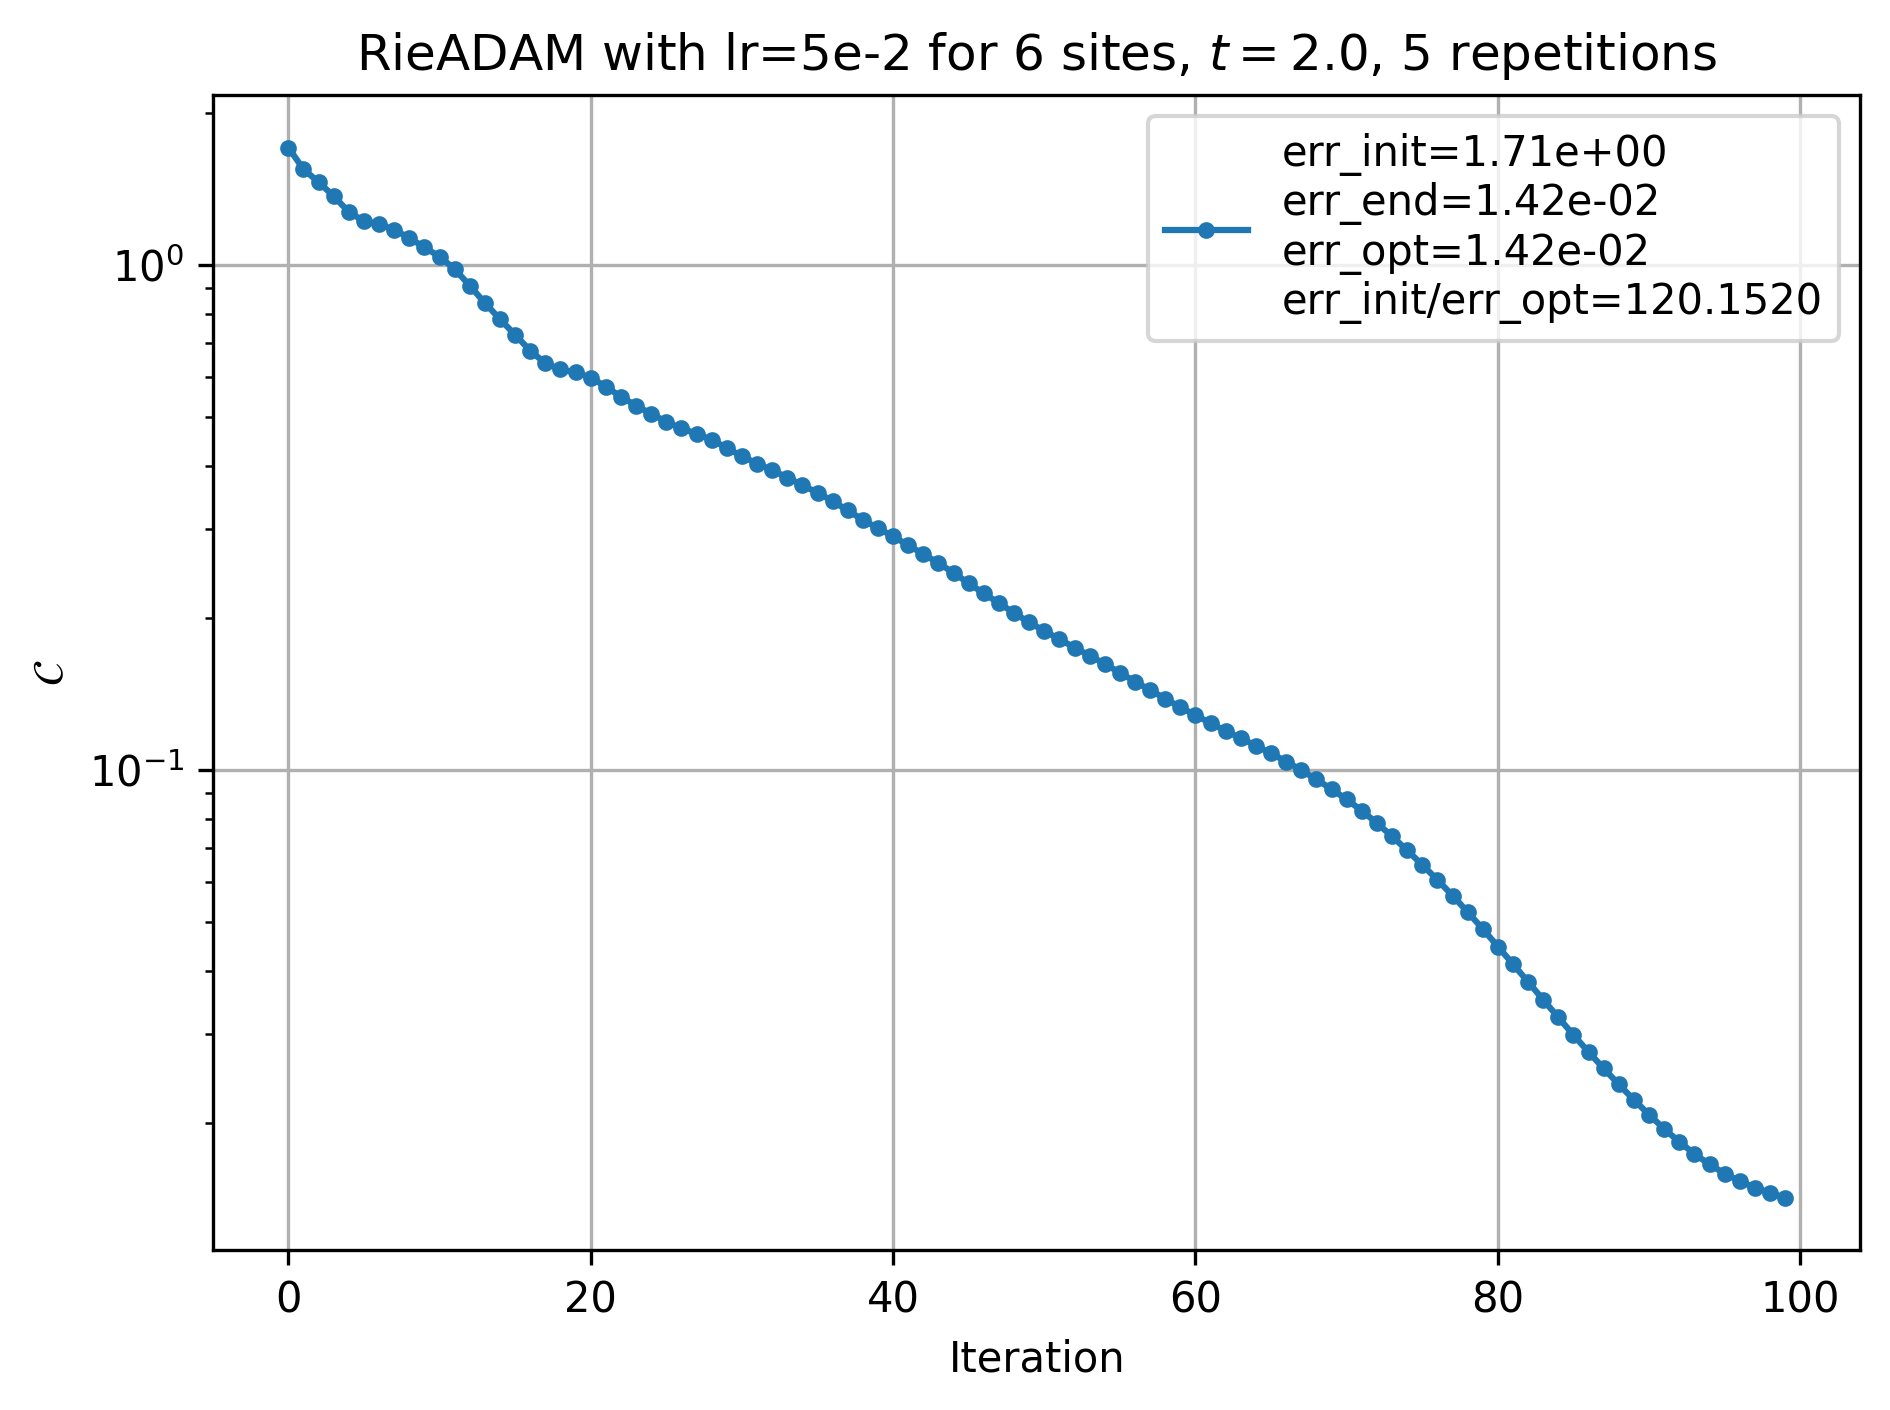

In [ ]:
# Hilbert Schmidt optimisaiton on subseuquent cirucit that AQC can not hekp with

gates_optimised_2, err_iter_2 = optimize_swap_network_circuit_RieADAM(config, U_ref_sub, subsequent_gates)


=== Optimizing with N = 1 layers ===
Start Riemannian ADAM optimization ...
⚠️ Truncating at layer 1, only 3 gates available (requested 11 layers)
	 0 	Current cost:  0.21990349559457845
	 1 	Current cost:  0.18370950851101497
	 2 	Current cost:  0.15051251652127196
	 3 	Current cost:  0.12050306861303572
	 4 	Current cost:  0.093840562007389
	 5 	Current cost:  0.07064283747329814
	 6 	Current cost:  0.050974430757959155
	 7 	Current cost:  0.03483401118300855
	 8 	Current cost:  0.02214209026143754
	 9 	Current cost:  0.012730810734279396
	 10 	Current cost:  0.0063383764666380404
	 11 	Current cost:  0.002611098666503109
	 12 	Current cost:  0.001115596536694241
	 13 	Current cost:  0.0013620058482630704
	 14 	Current cost:  0.0028363090702479
	 15 	Current cost:  0.005037118201603796
	 16 	Current cost:  0.007510777123567625
	 17 	Current cost:  0.009879232851779163
	 18 	Current cost:  0.01185730928184614
	 19 	Current cost:  0.013258642946766042
	 20 	Current cost:  0.0139916166

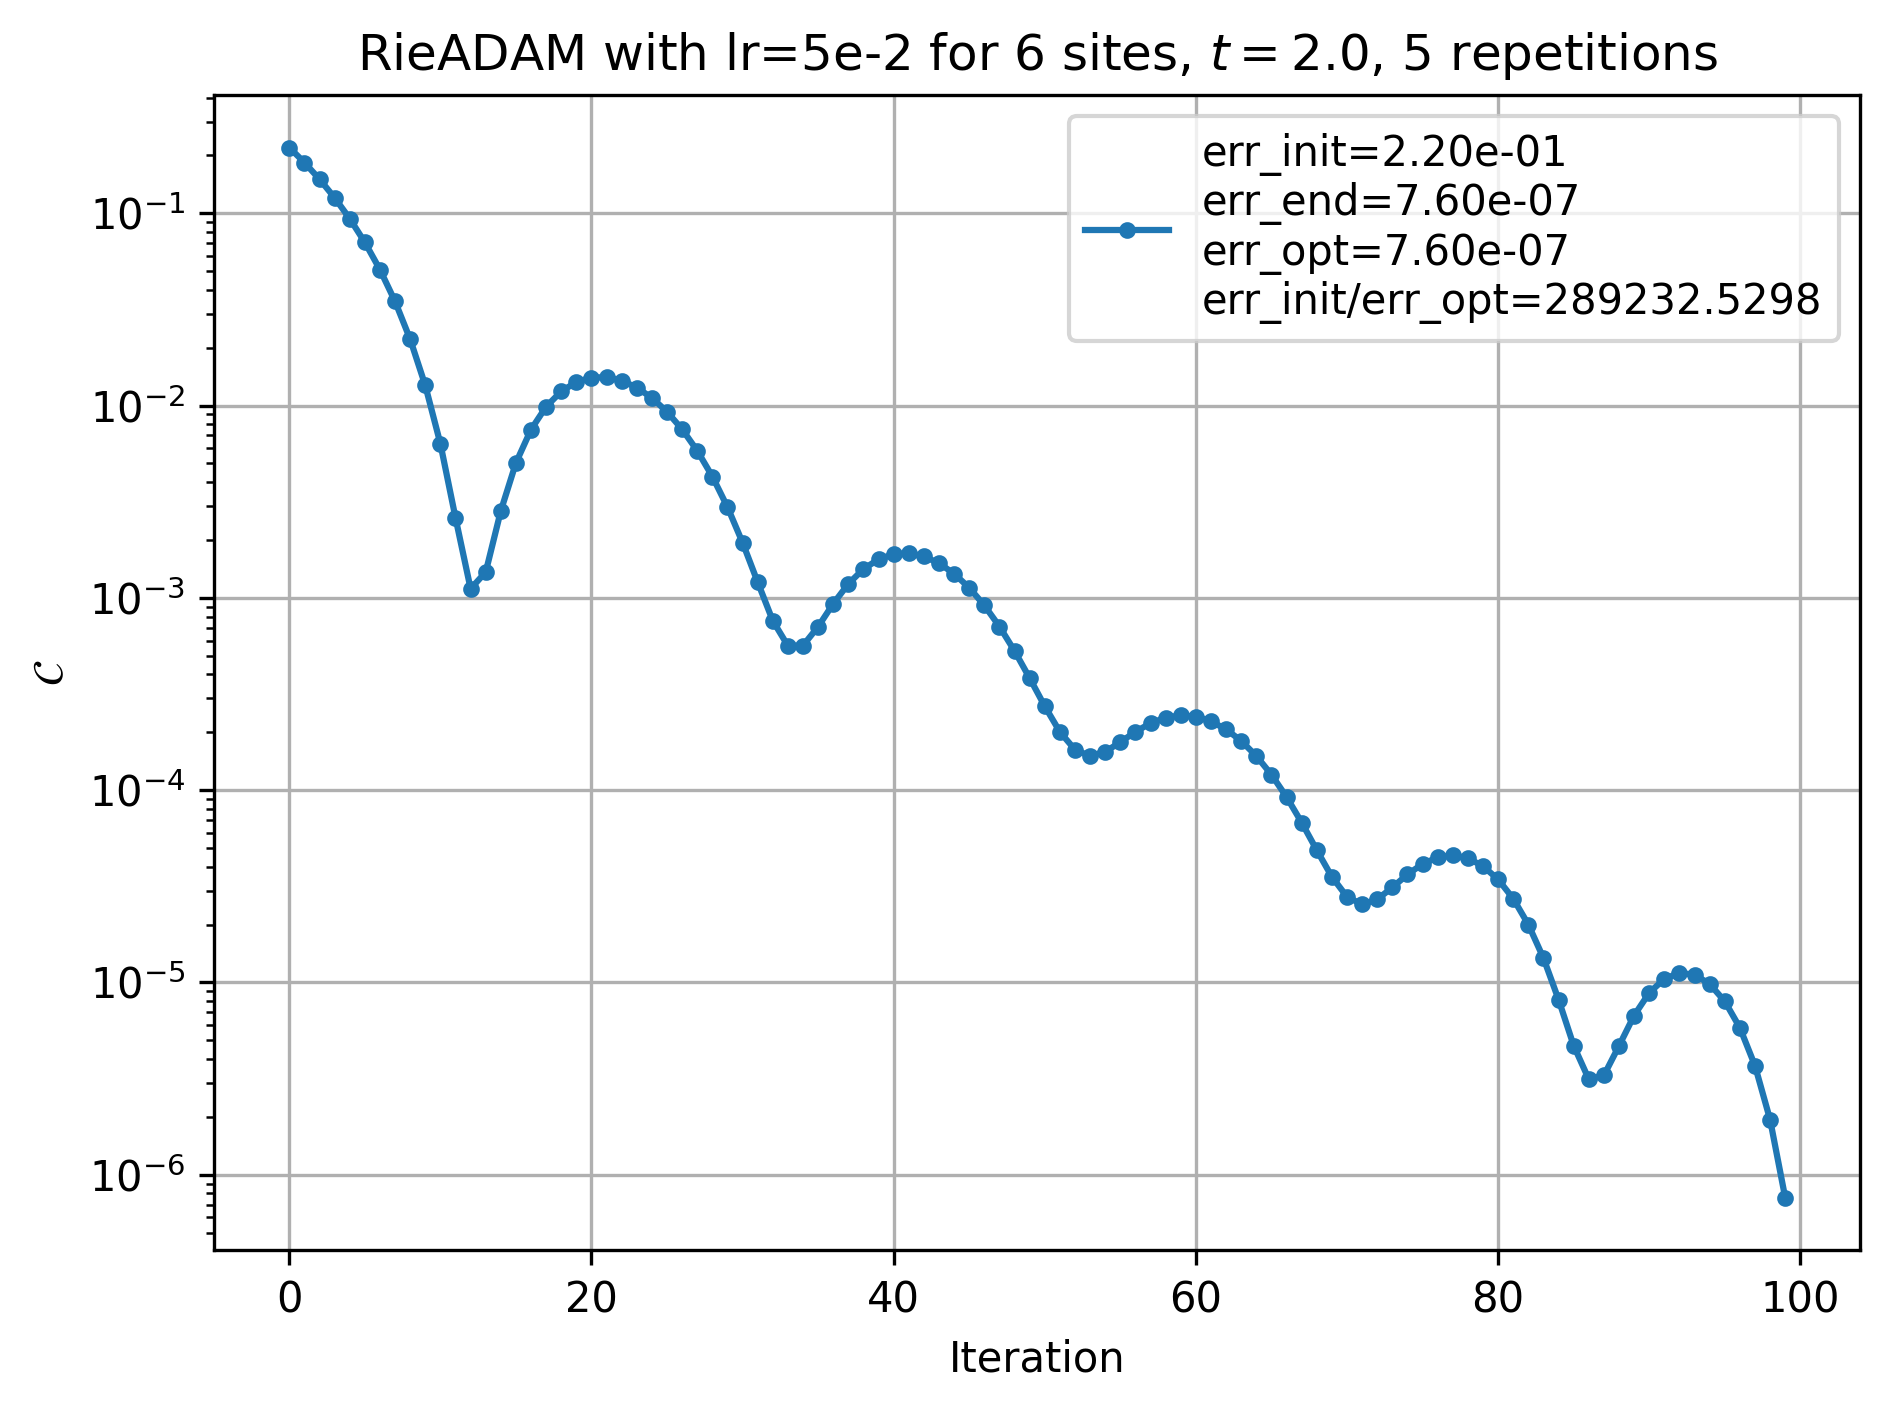

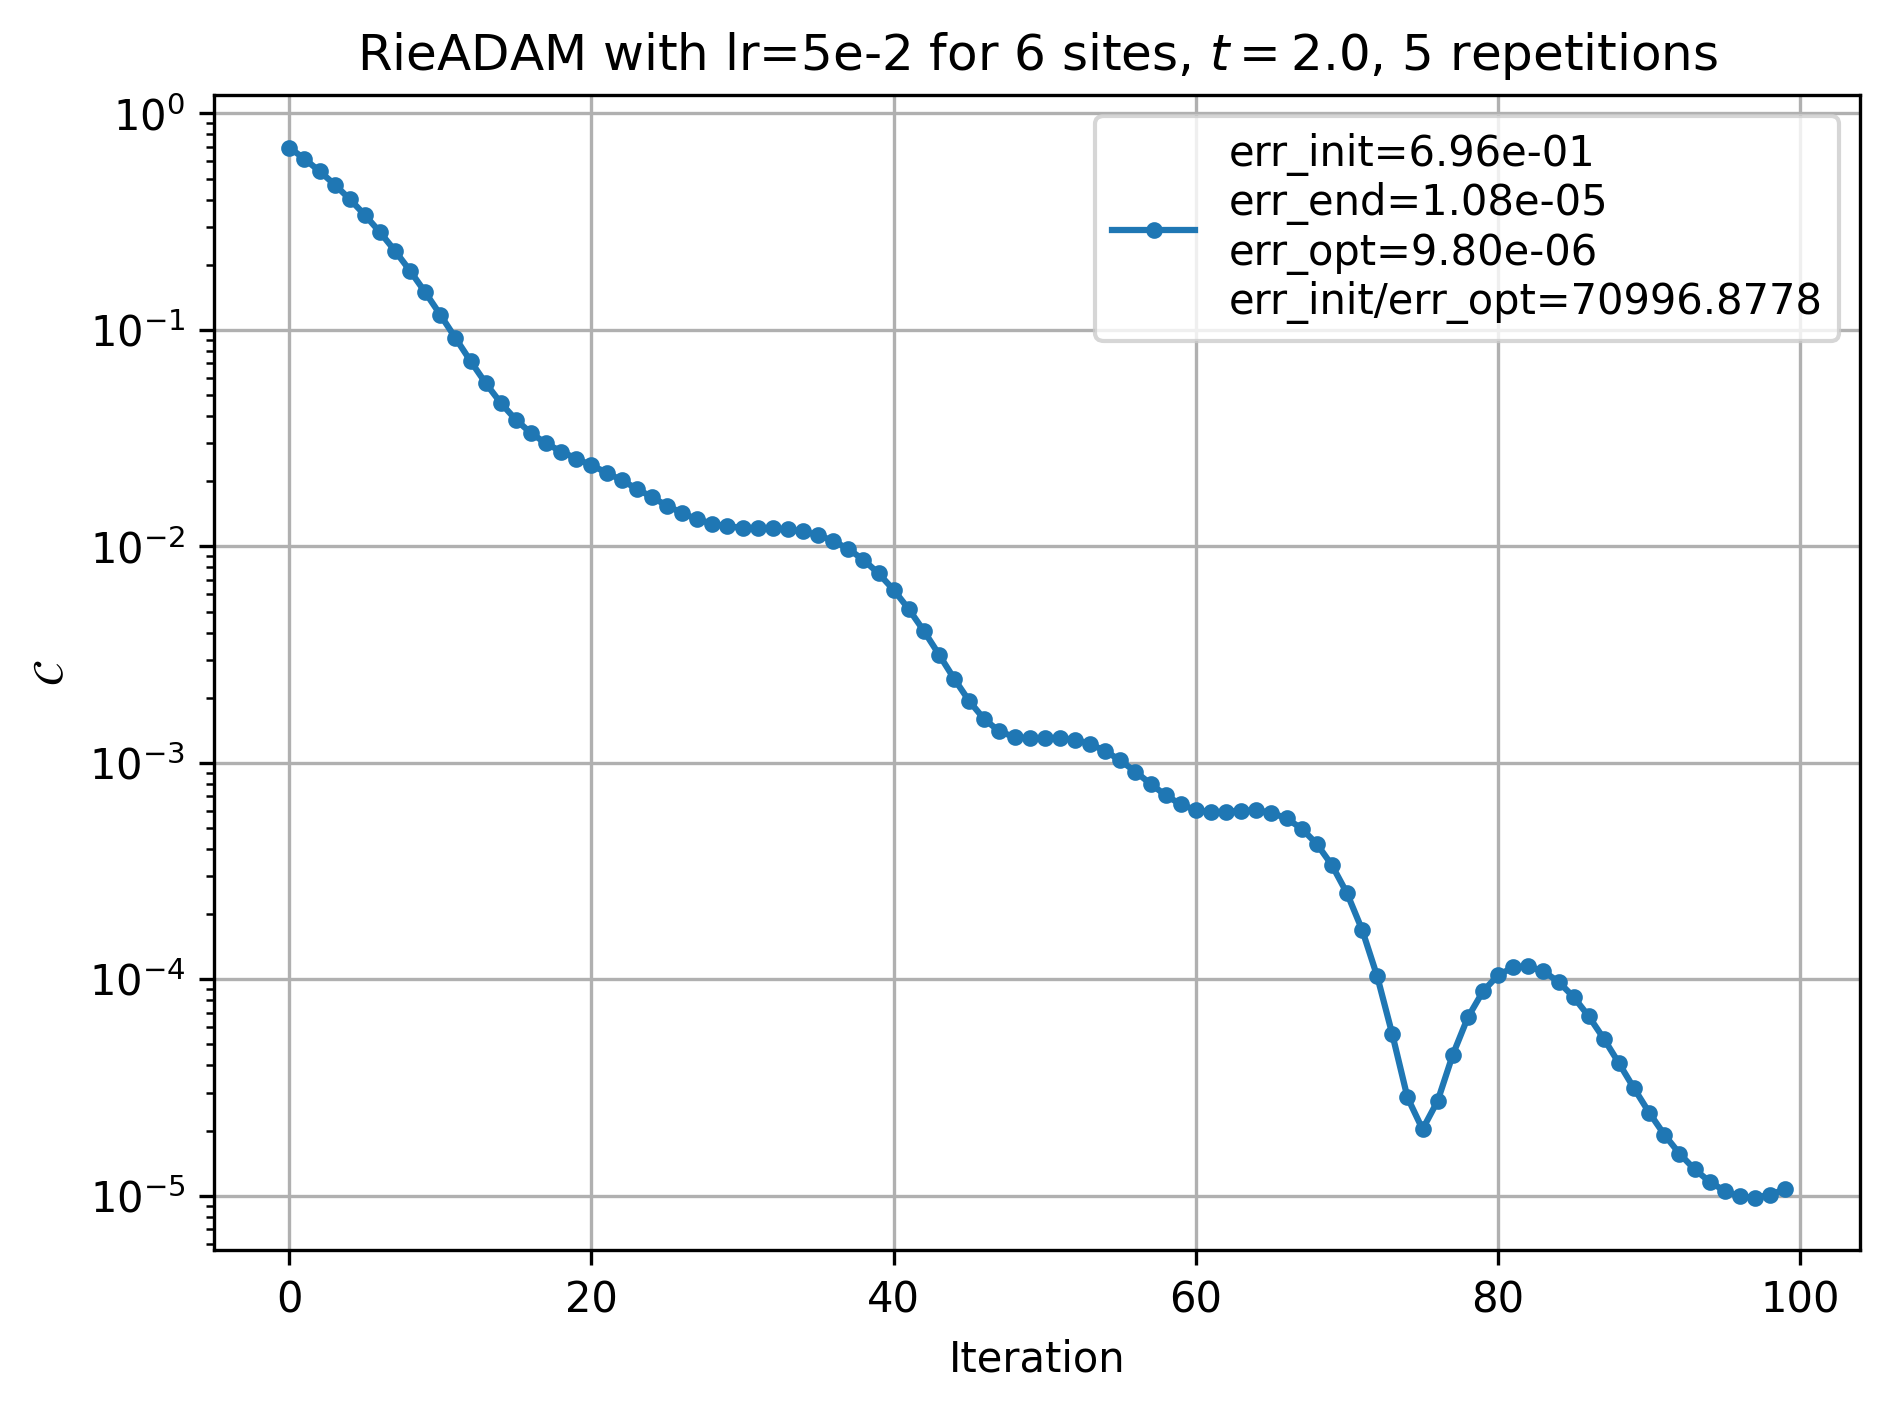

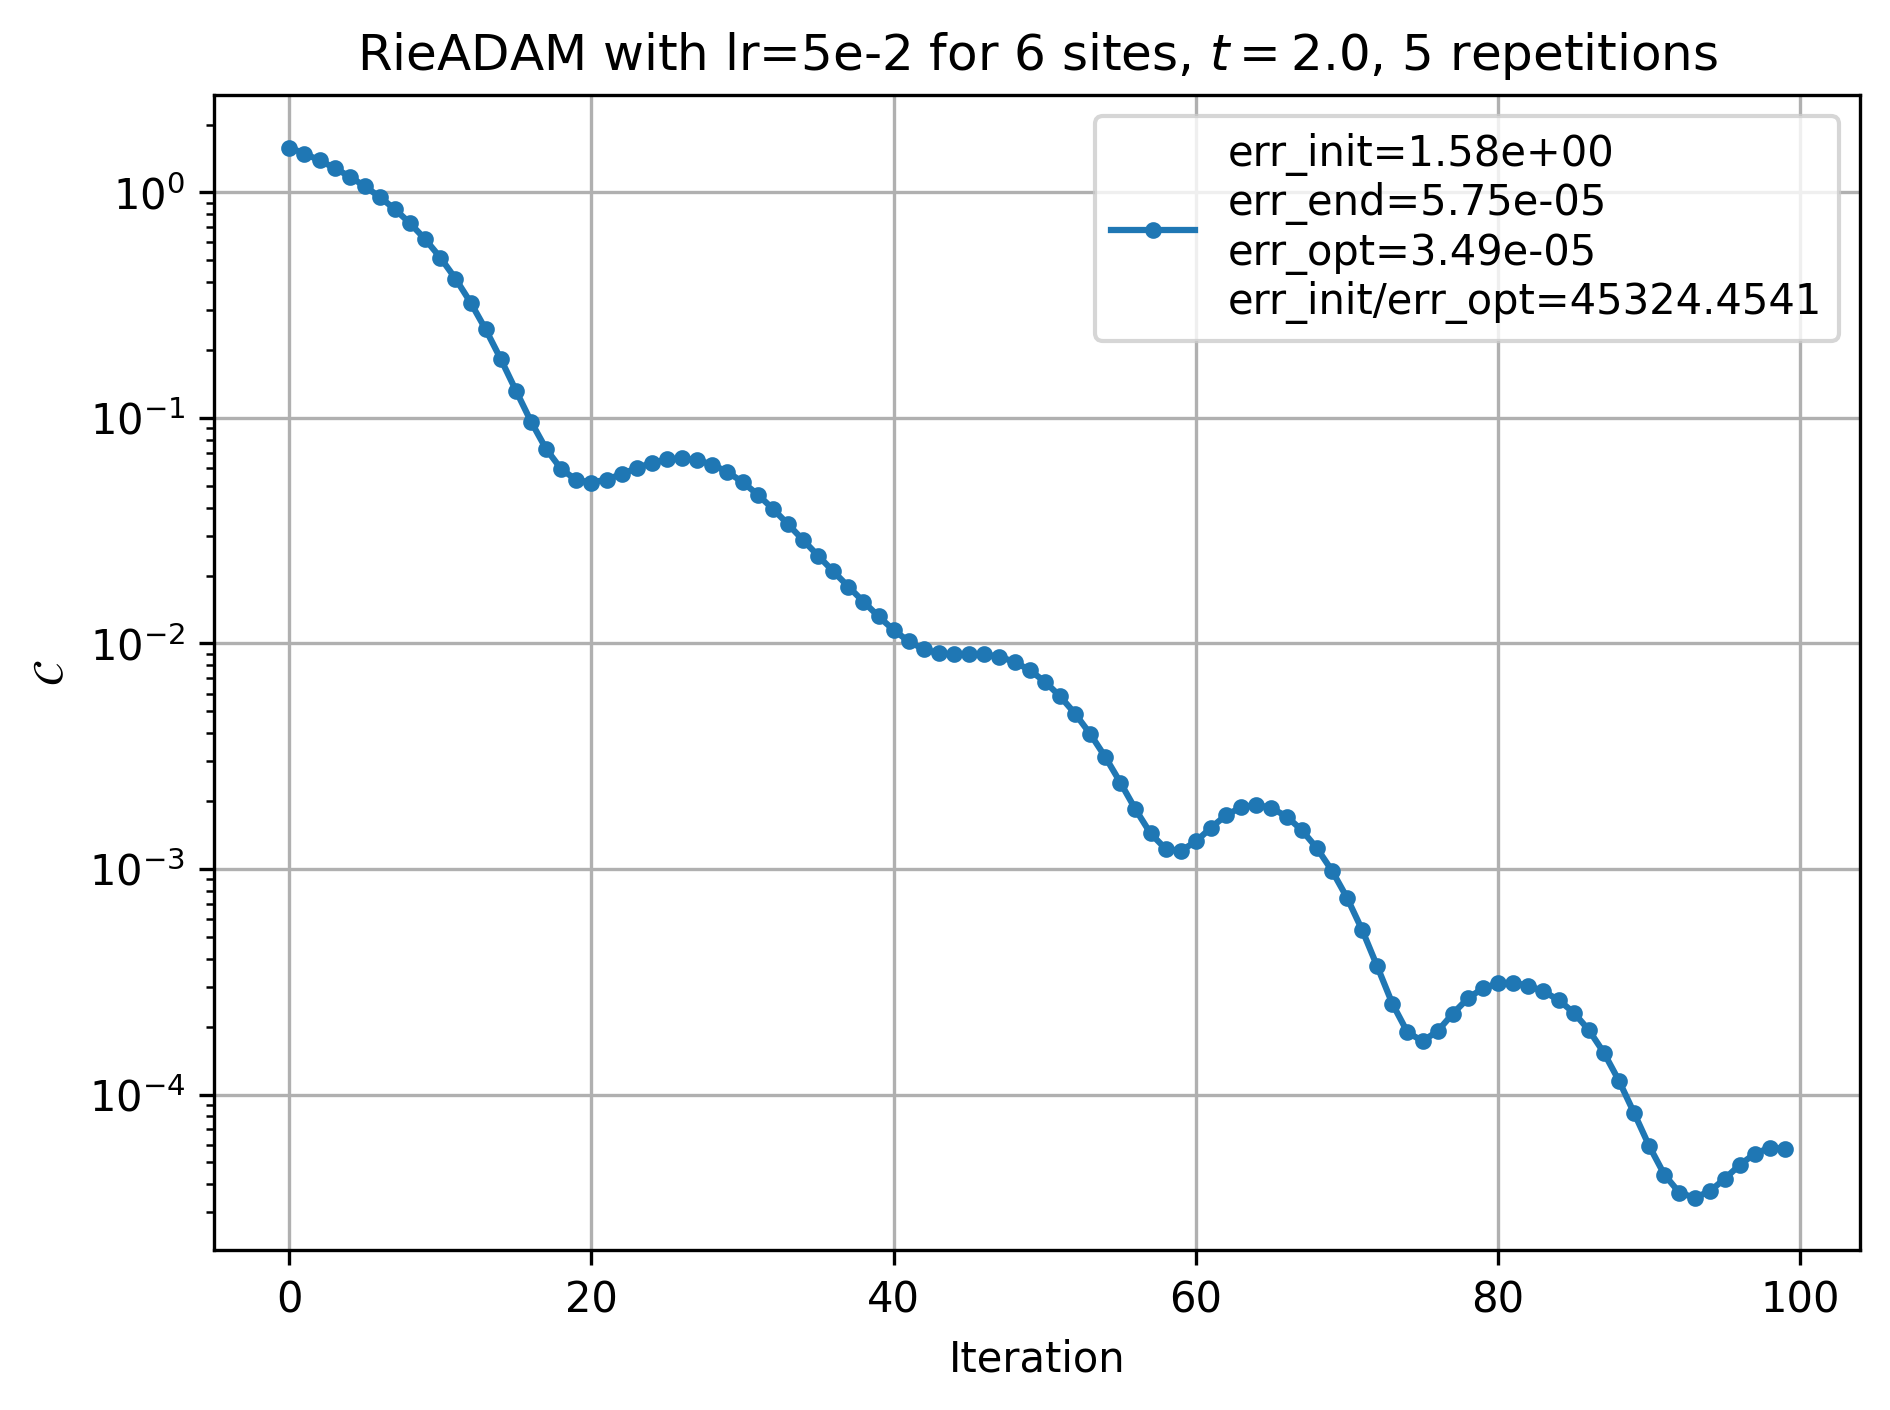

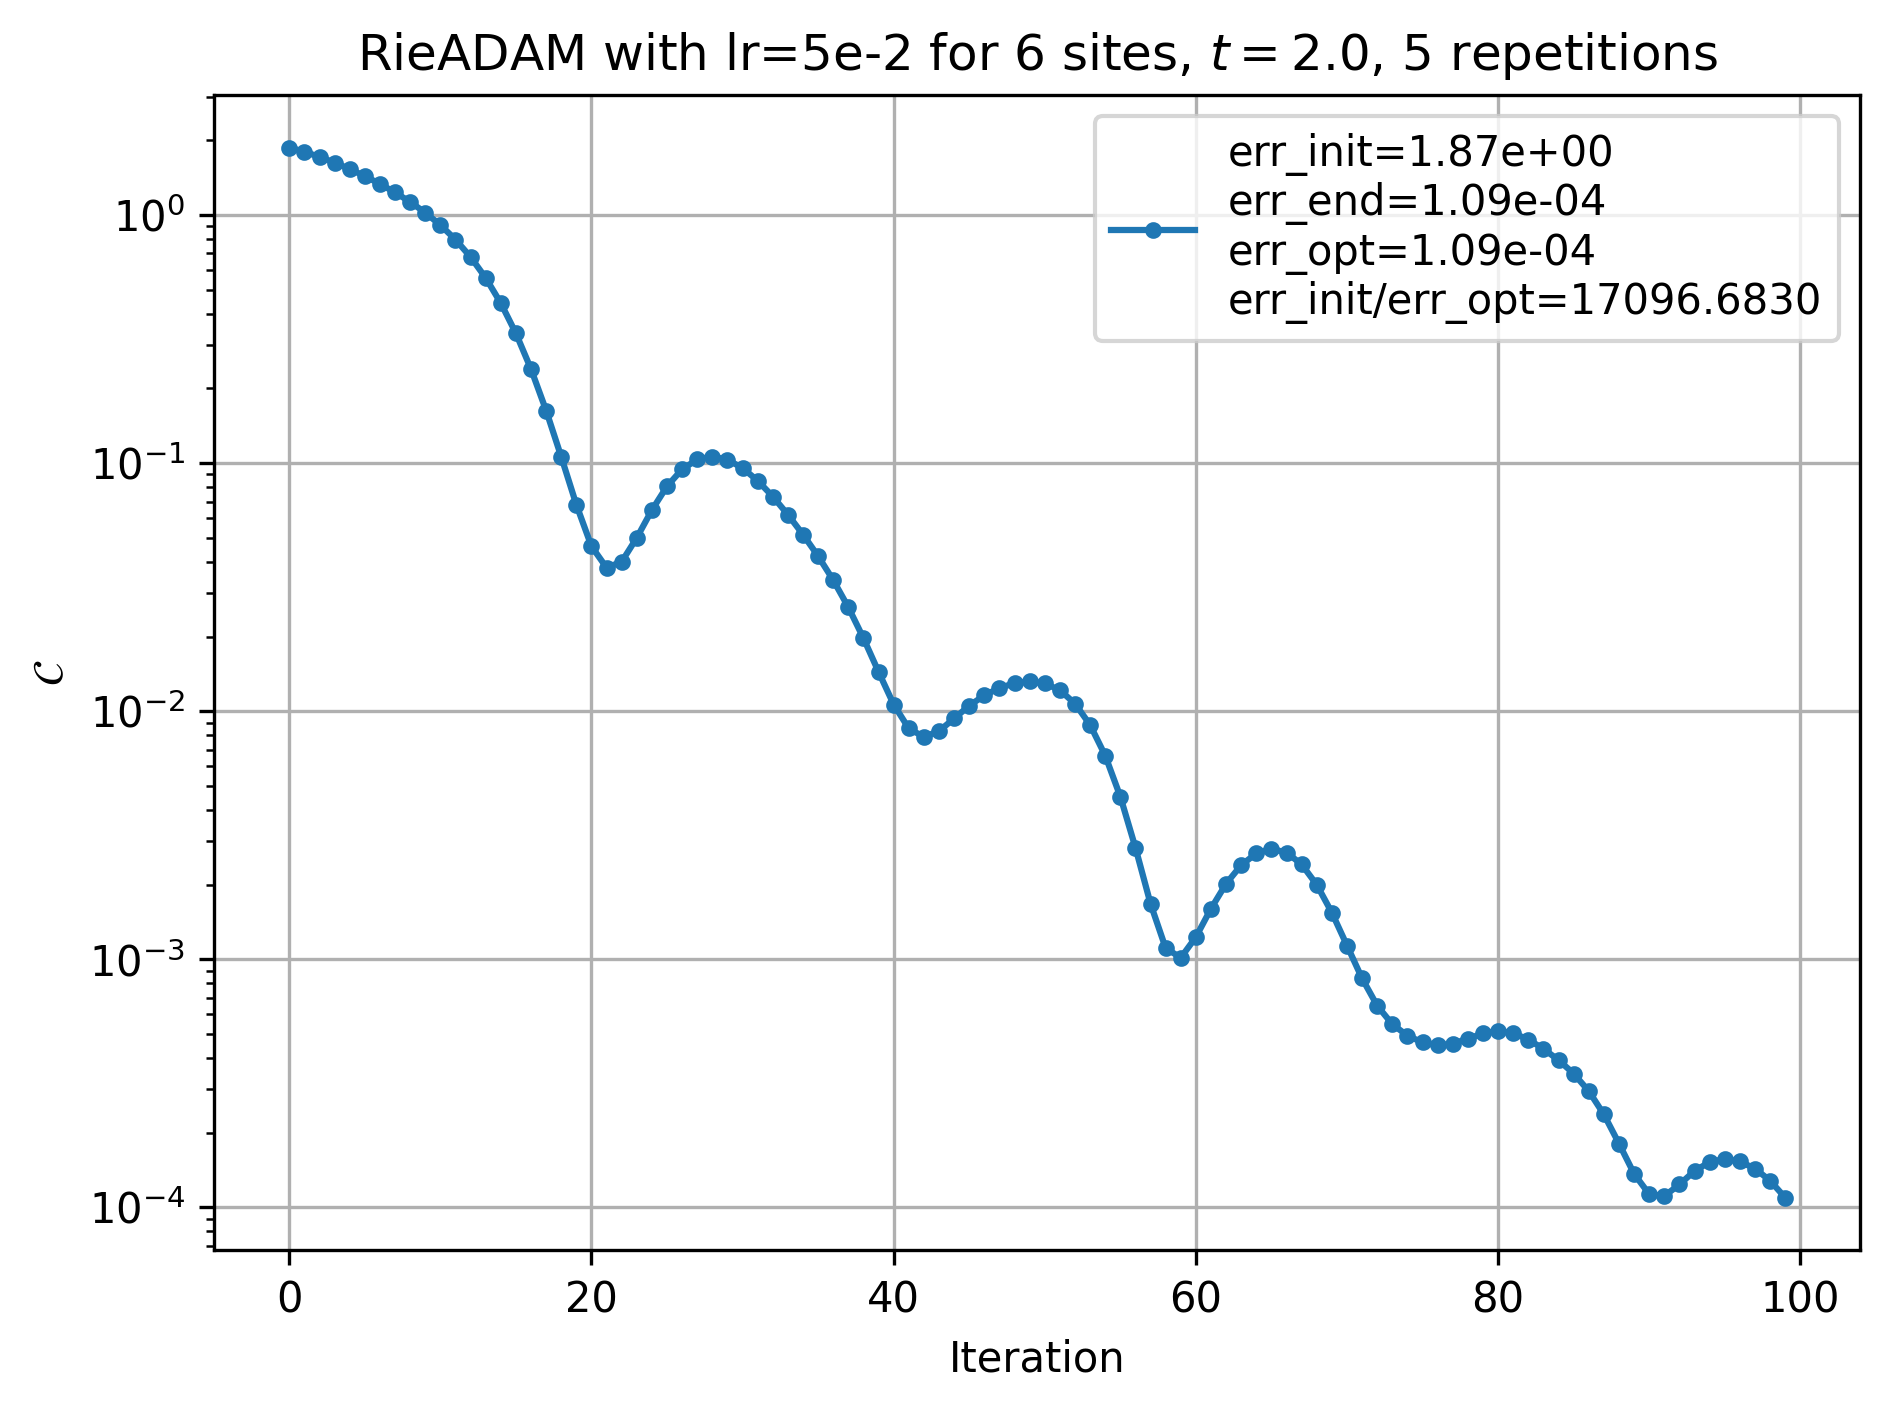

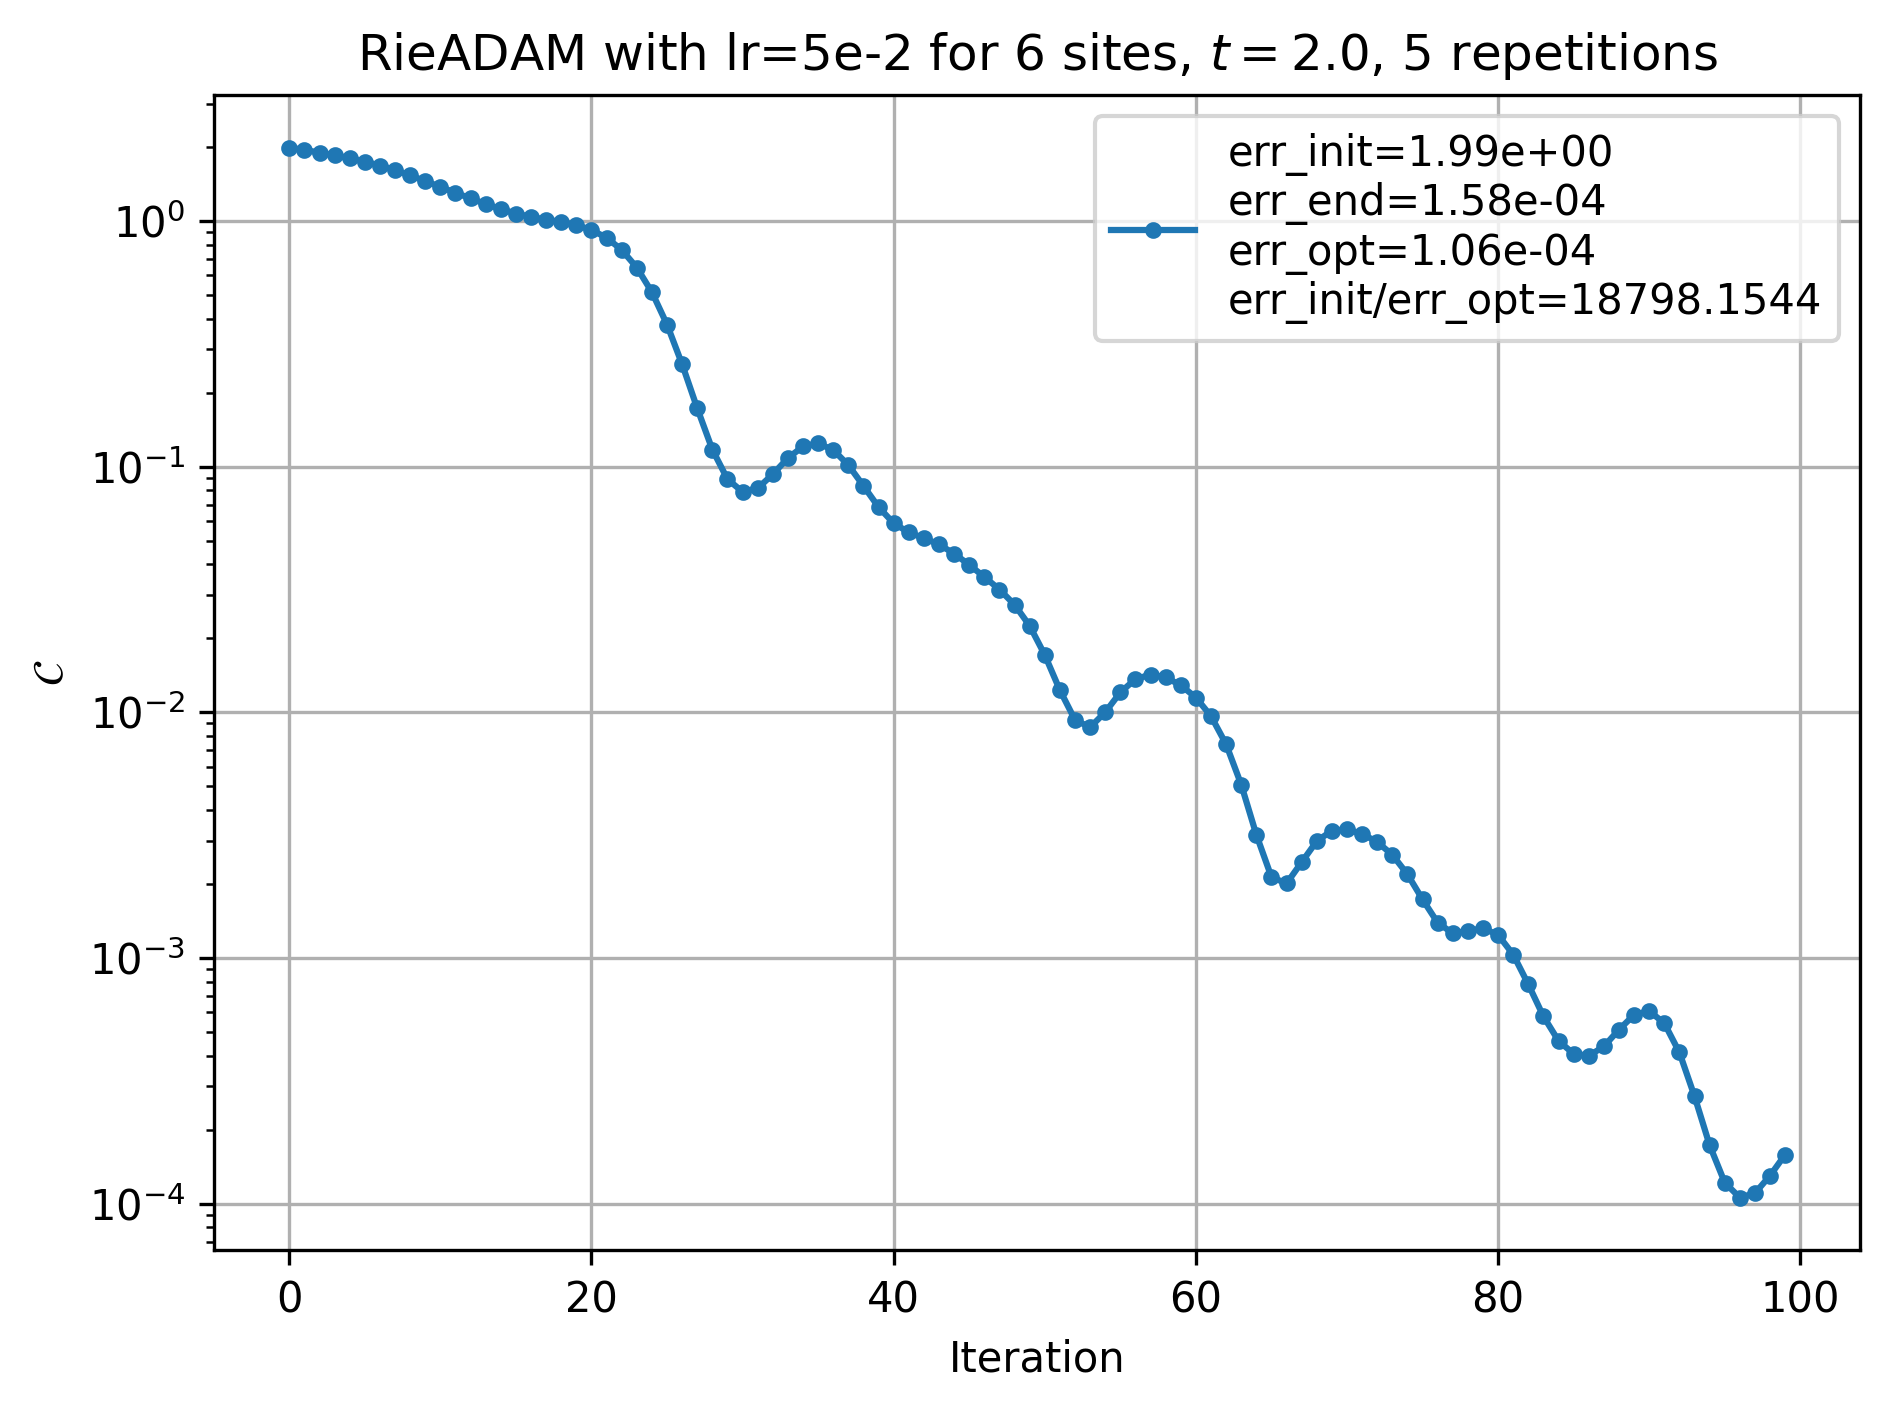

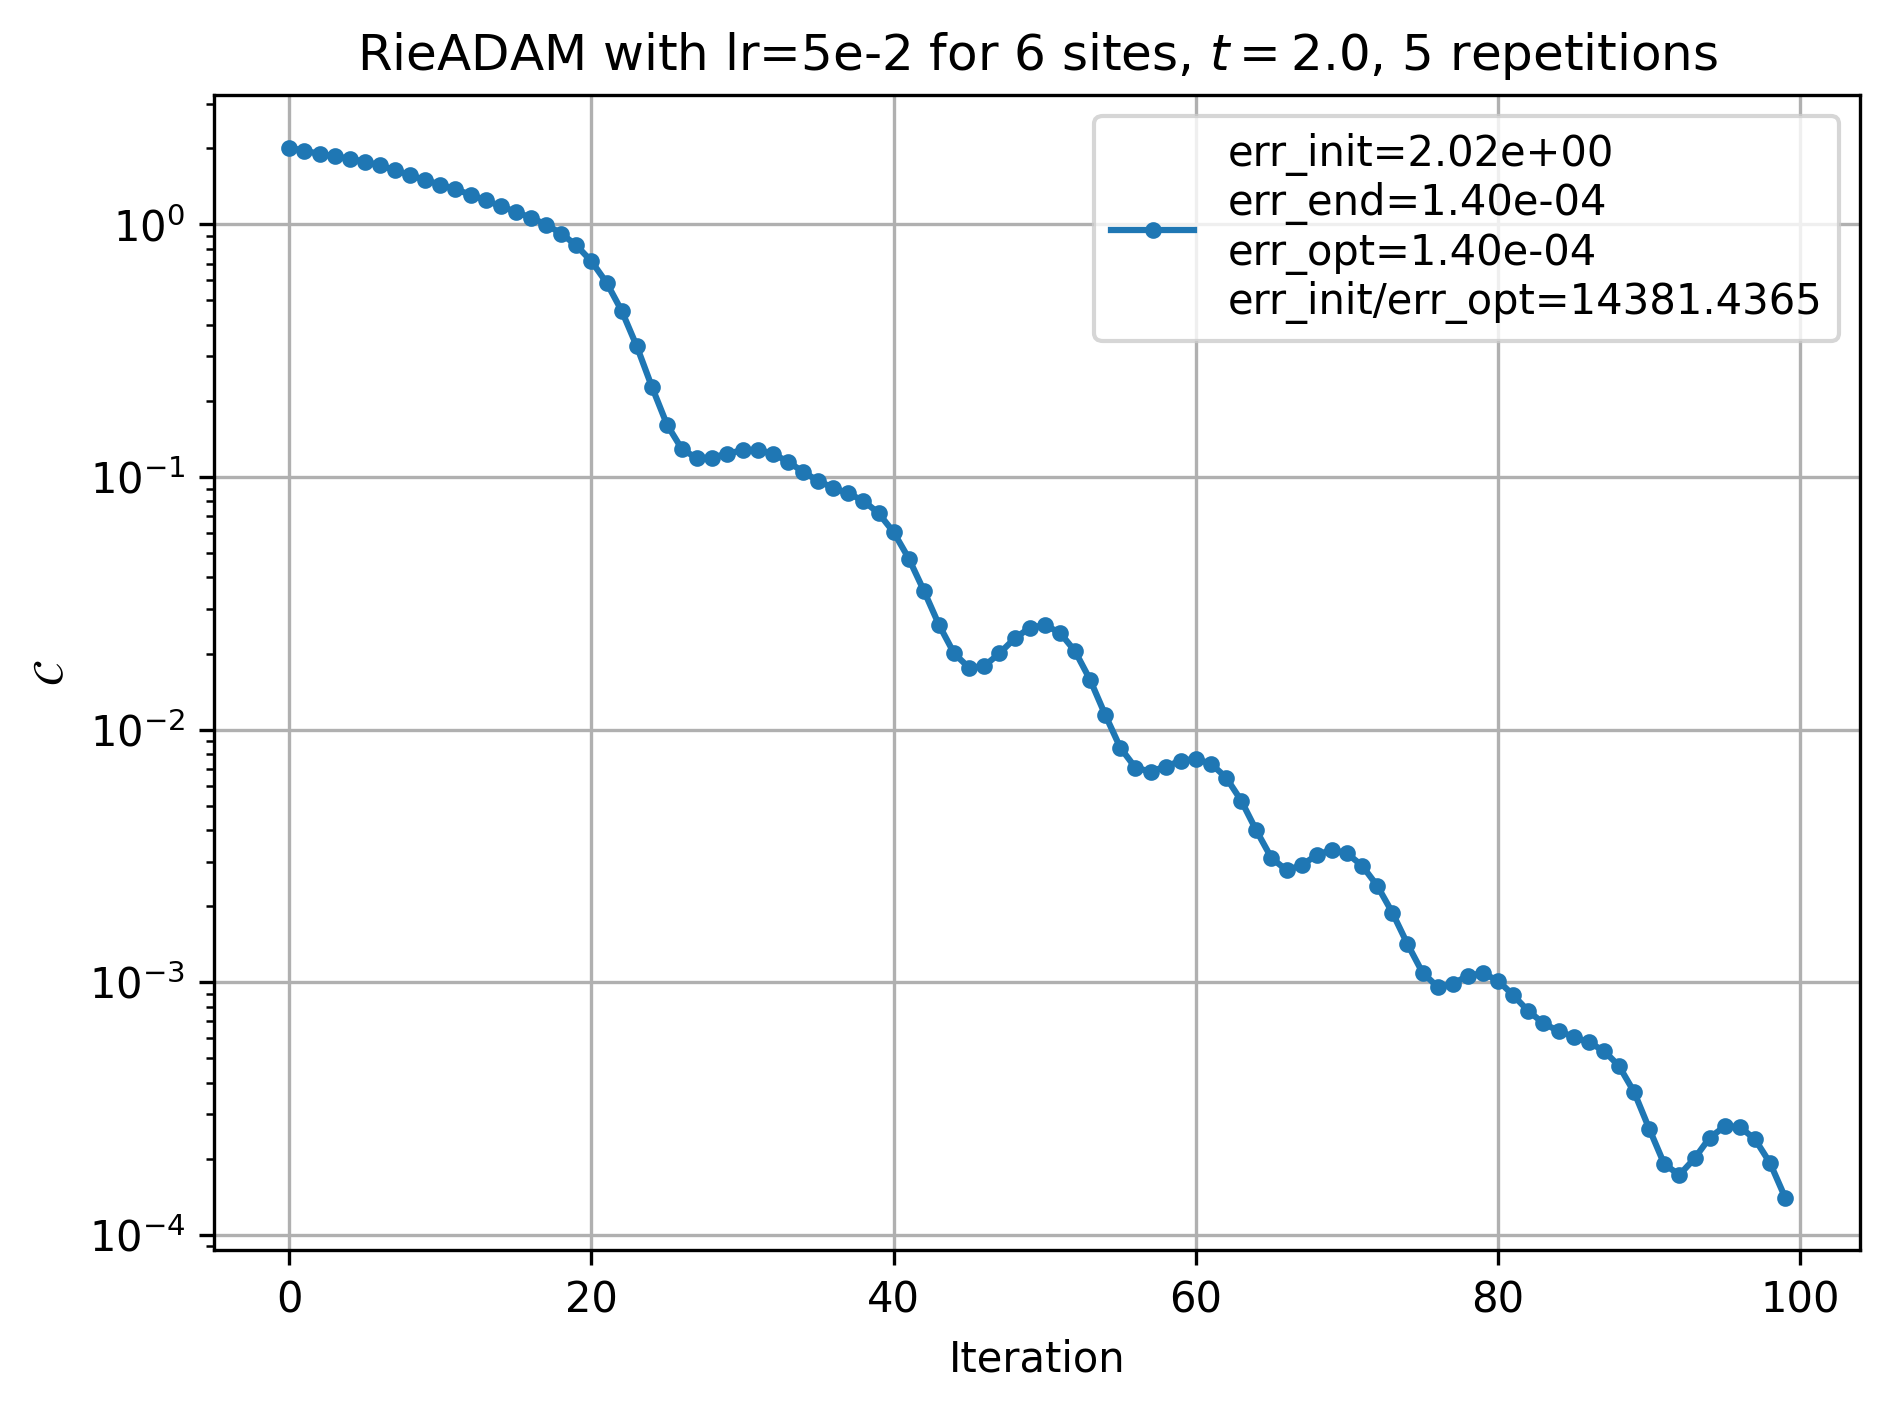

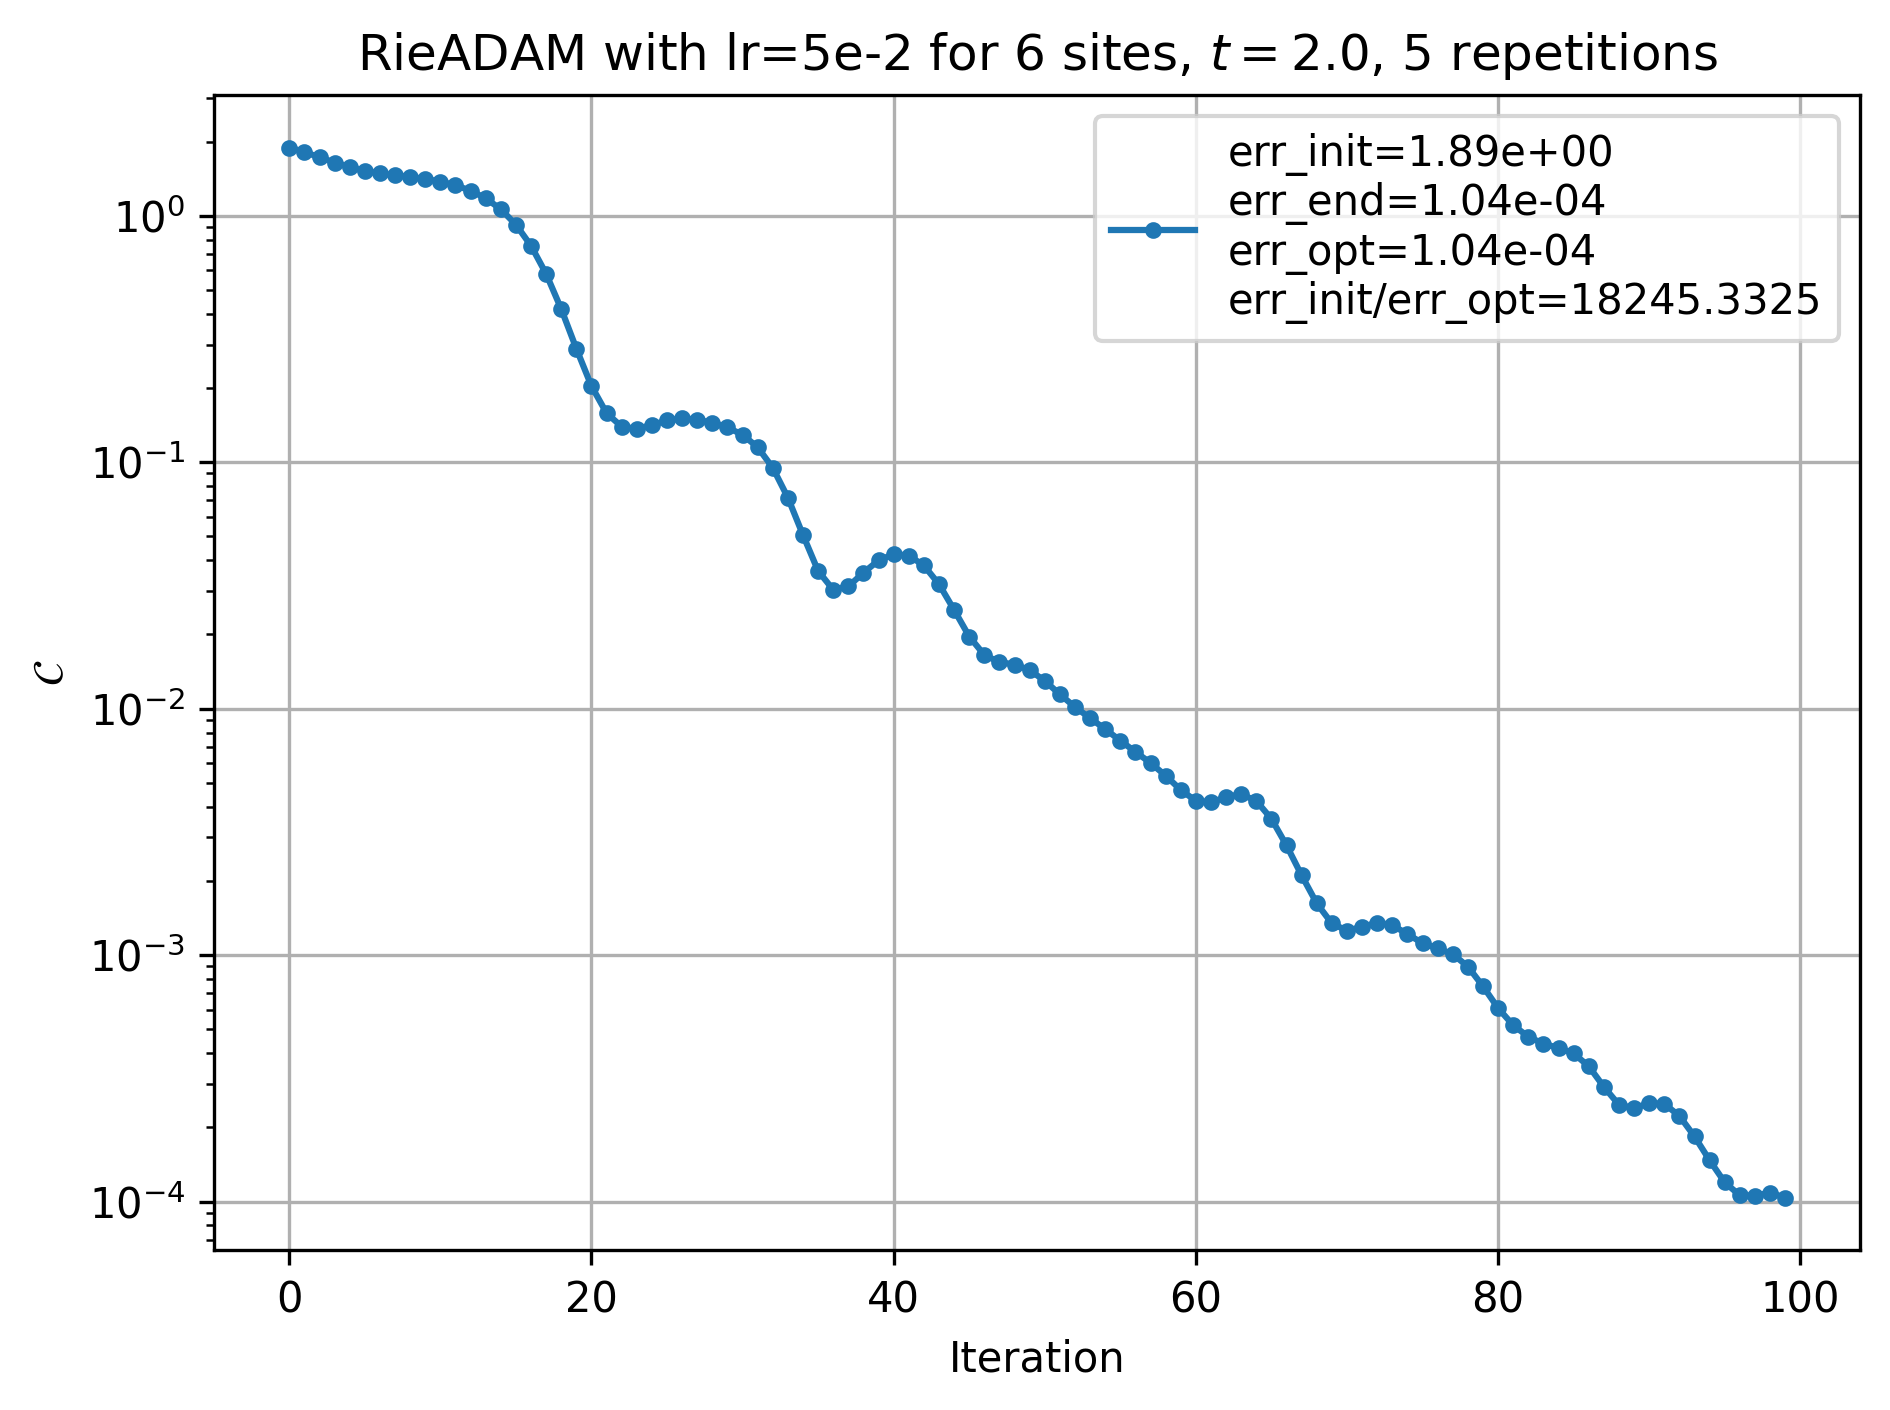

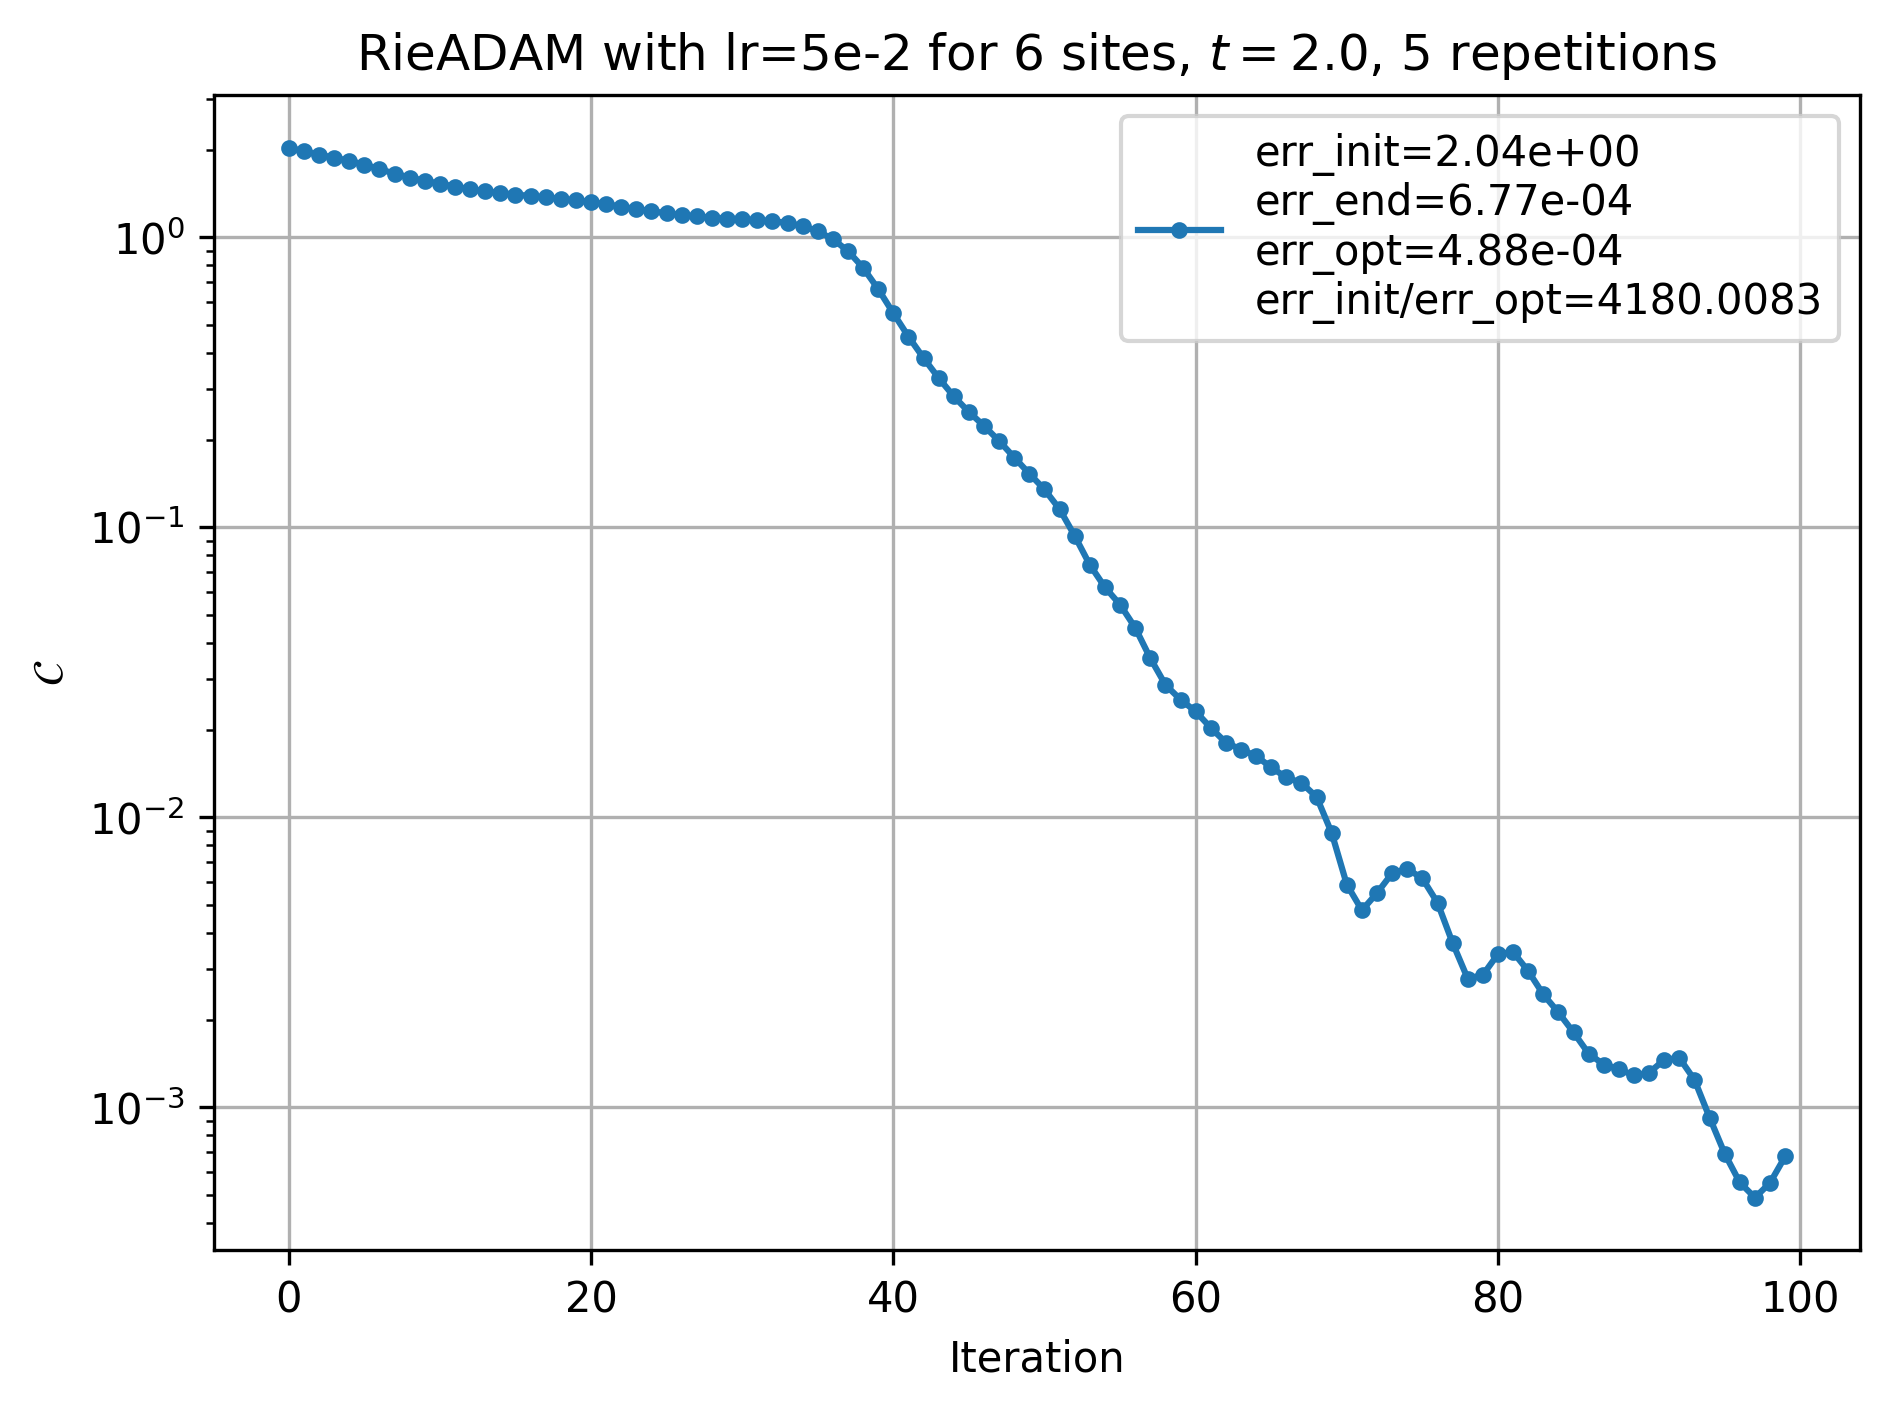

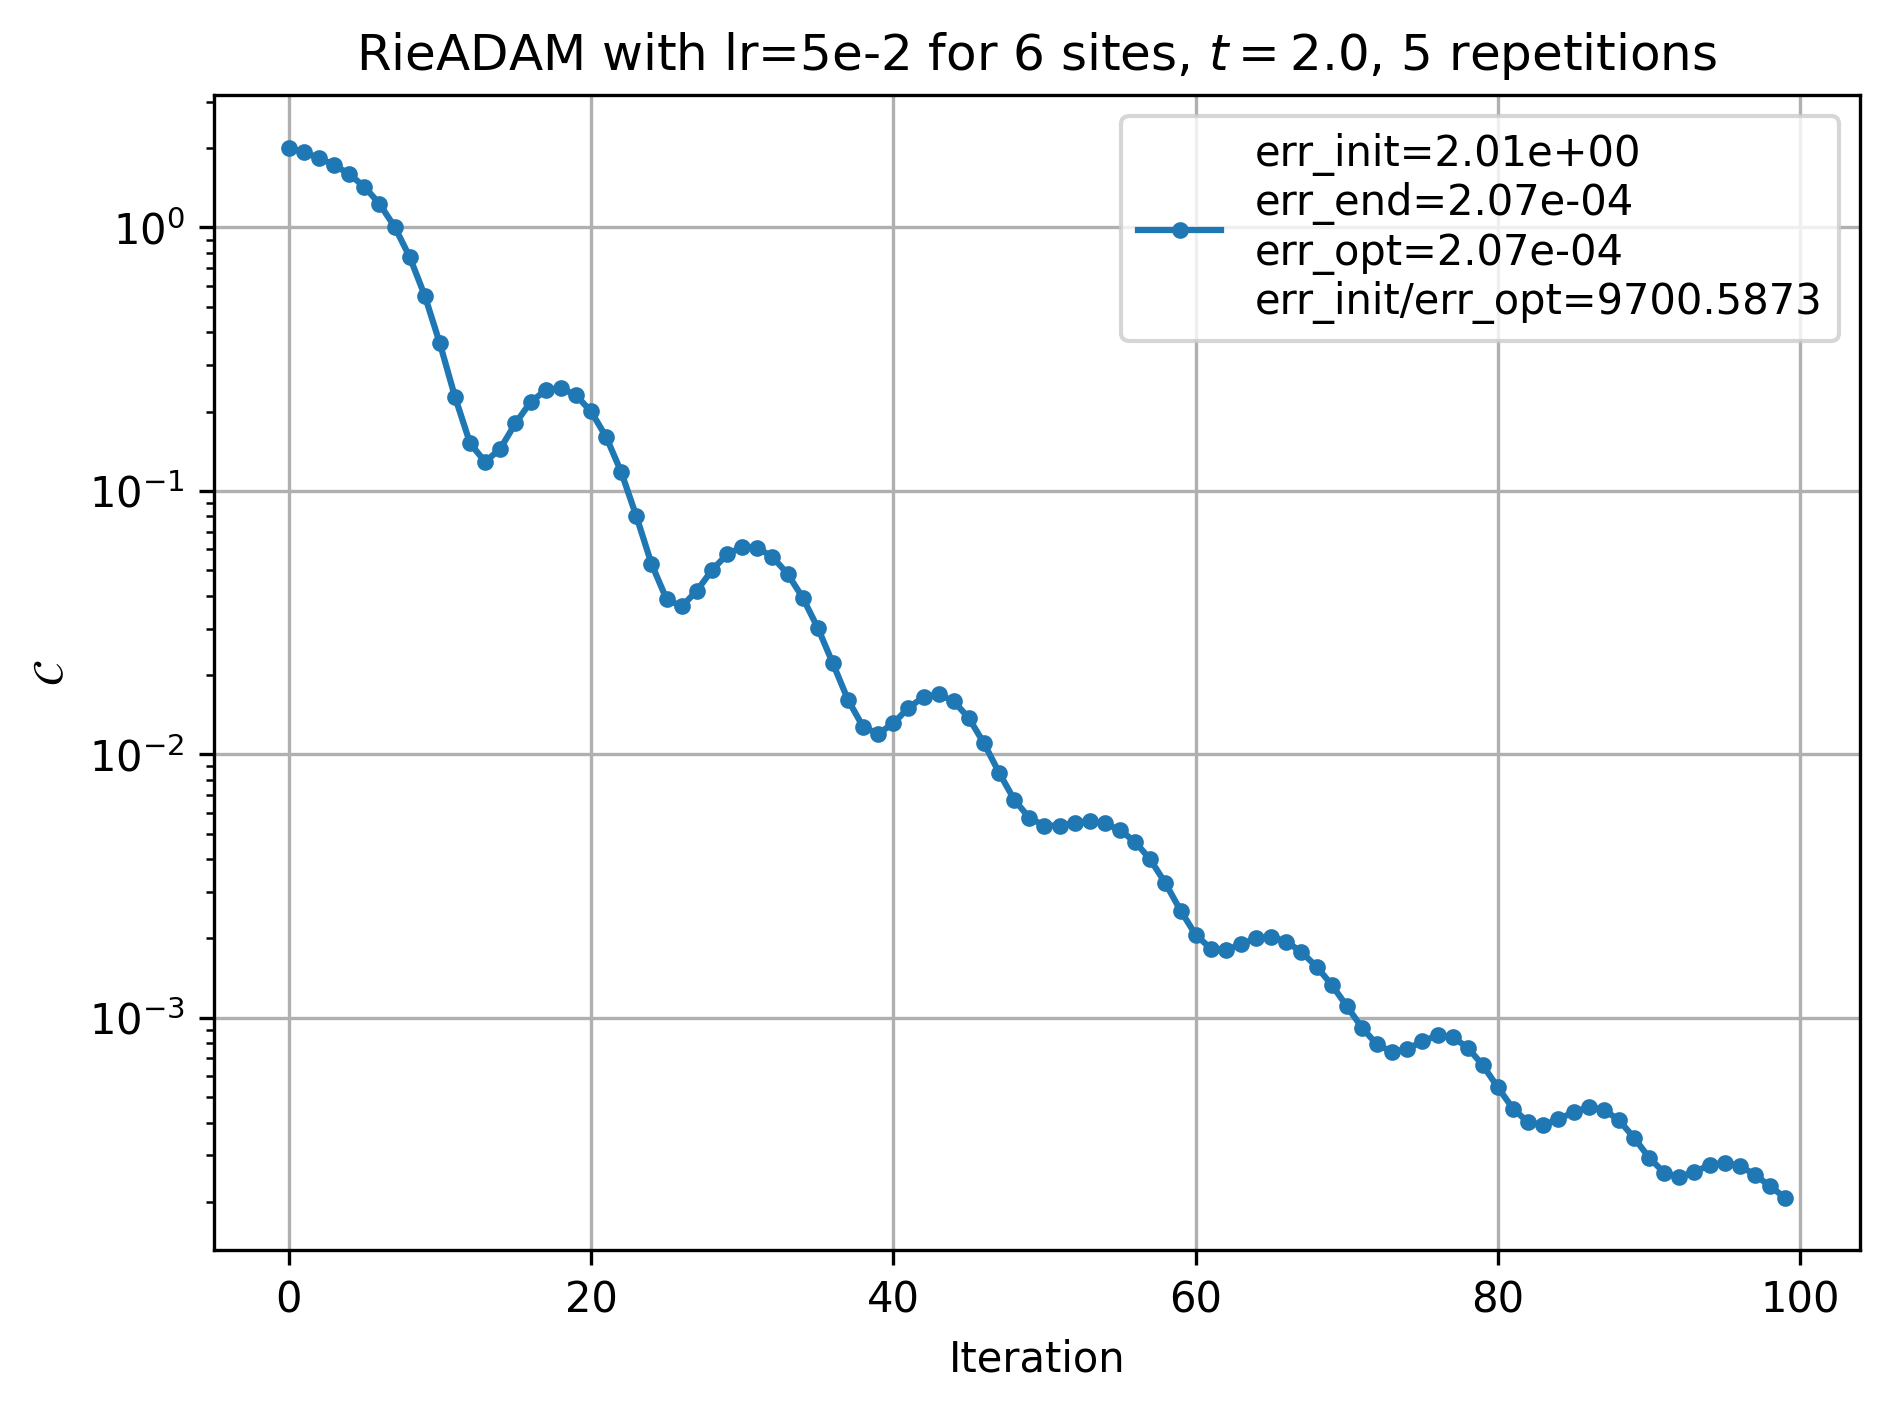

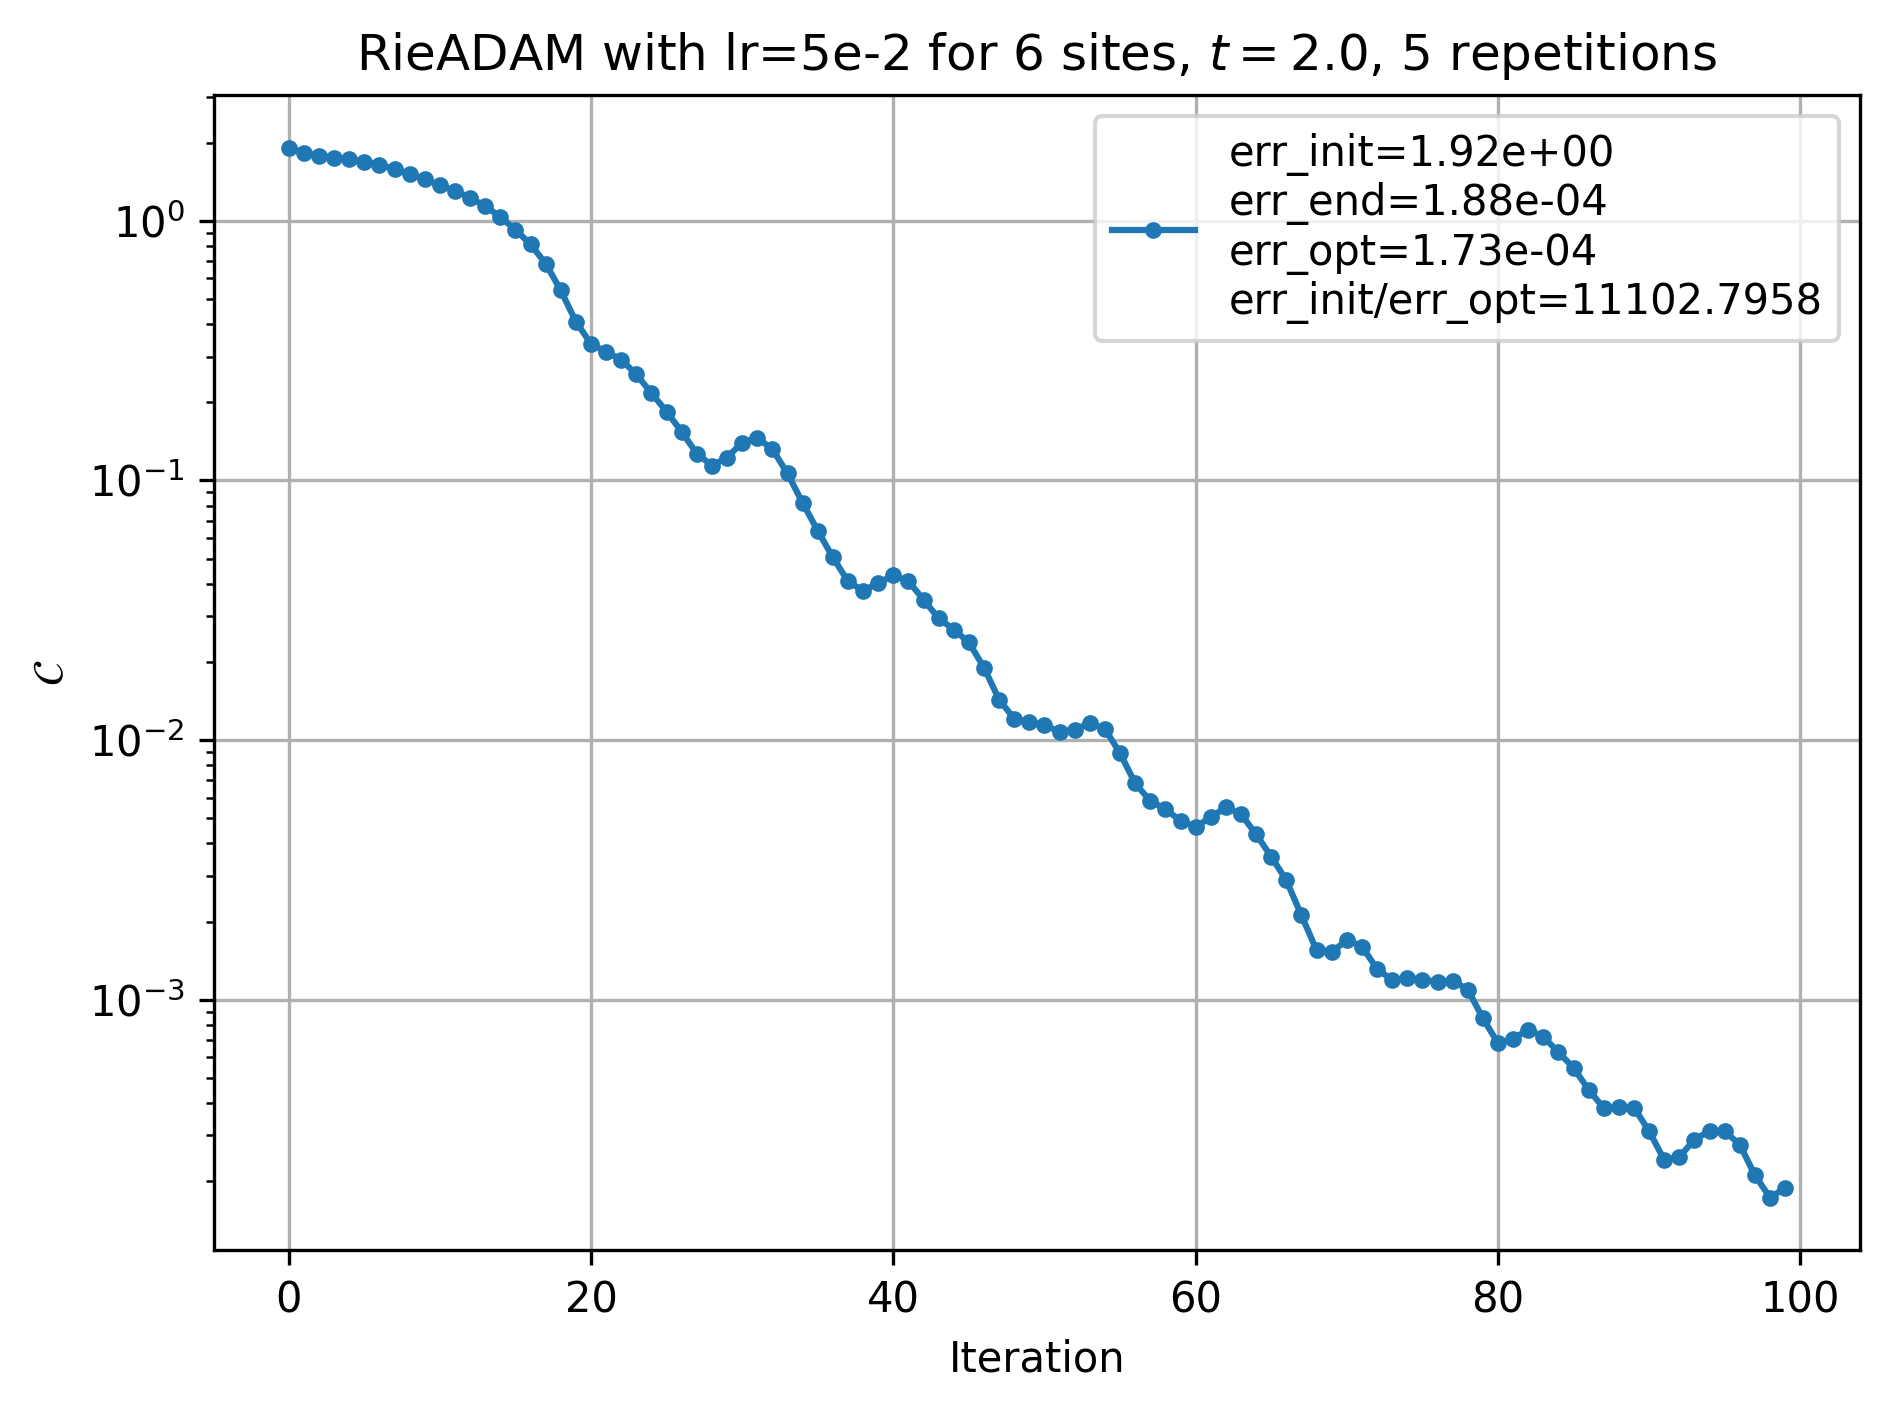

In [ ]:
from ropt_aqc.comparison_methods import compress_HS

N_vals = [1,2,3,4,5,6,7,8,9,10]
df_sub = compress_HS(subsequent_gates, config, U_ref_sub, N_vals, qc_initial=None)

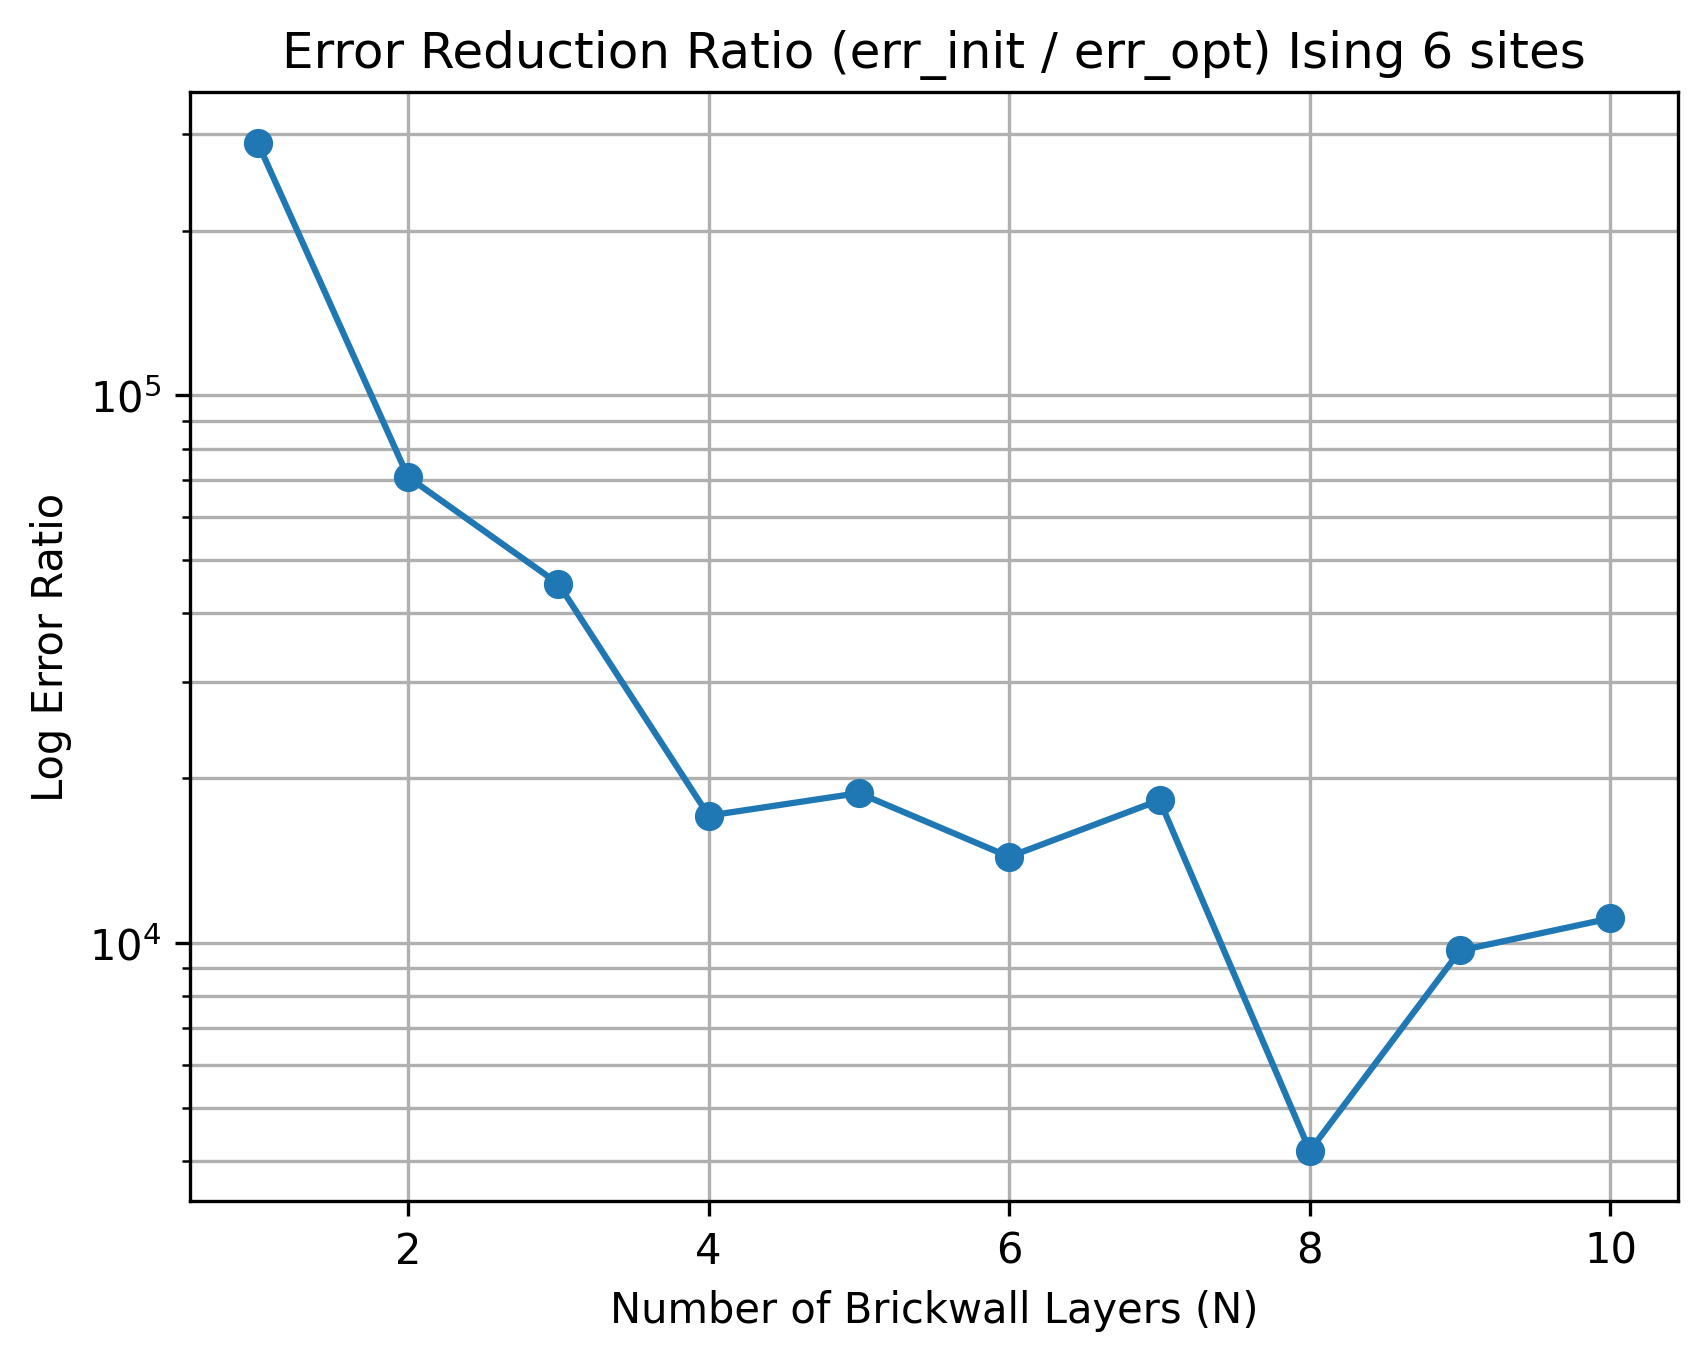

In [ ]:
# Plot error ratio (log scale)
plt.figure(dpi=300)
plt.semilogy(df_sub['circuit_layers'], df_sub['err_init/err_opt'], marker='o')
plt.title('Error Reduction Ratio (err_init / err_opt) Ising 6 sites')
plt.xlabel('Number of Brickwall Layers (N)')
plt.ylabel('Log Error Ratio')
plt.grid(True, which='both')
plt.show()

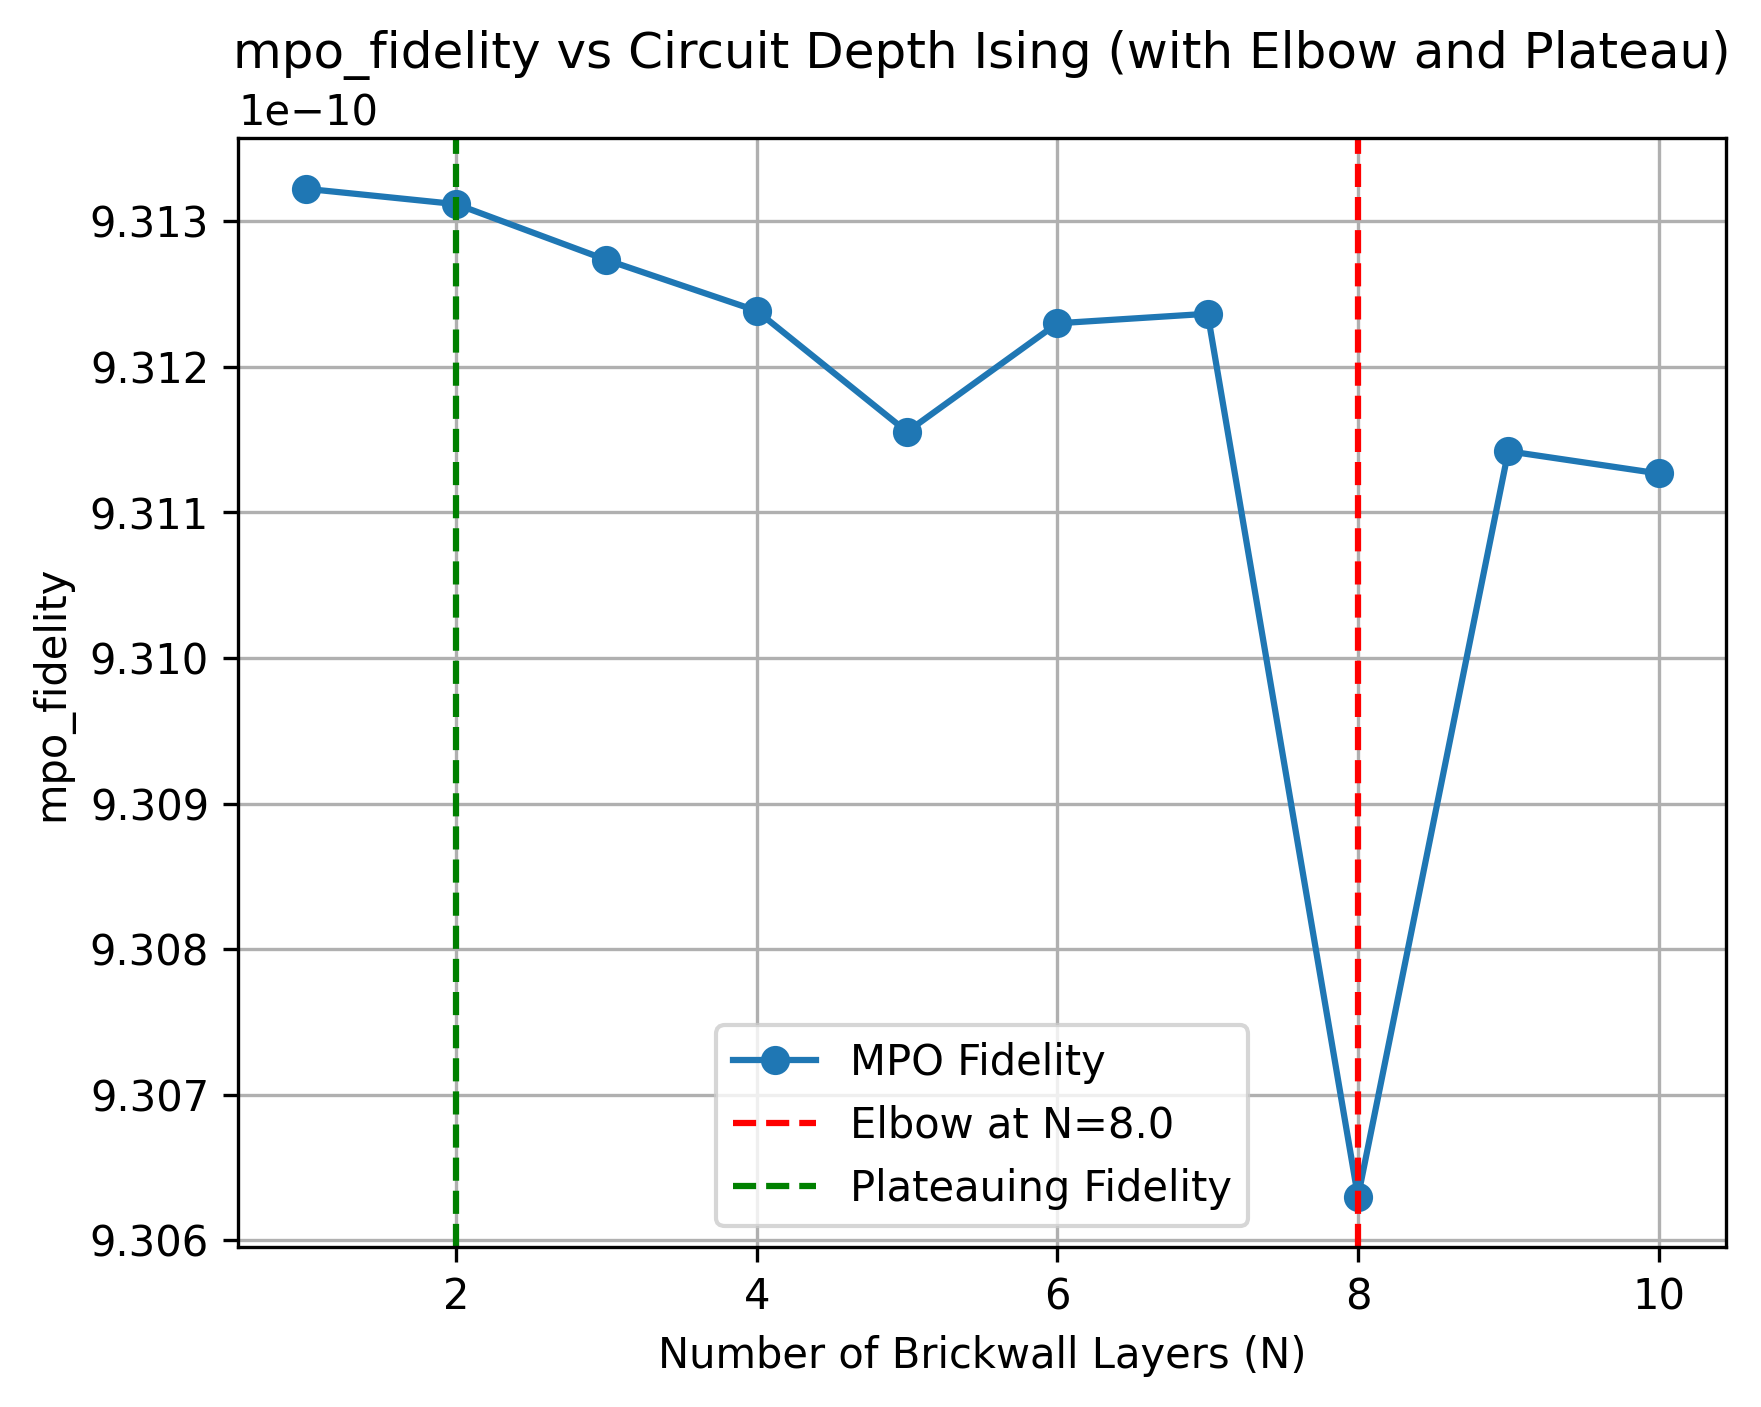


🔍 Suggested optimal compression depth: N = 2.0


In [ ]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N, plateau_N = plot_fidelity(df_sub, 'mpo_fidelity', n_repetitions, method, system)

# Heisenberg

In [ ]:
# Heisenberg
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms
num_sites = 6
degree = 2
n_id_layers = 0
method = 'hybrid'

t = 0.25
h = 0.75
n_repetitions = 5
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [2]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain

gates_heisenberg = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, h=h)

In [3]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates
import numpy as np

gates_initial_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, h=h)
print(np.array(gates_initial_h).shape) 

(28, 4, 4)


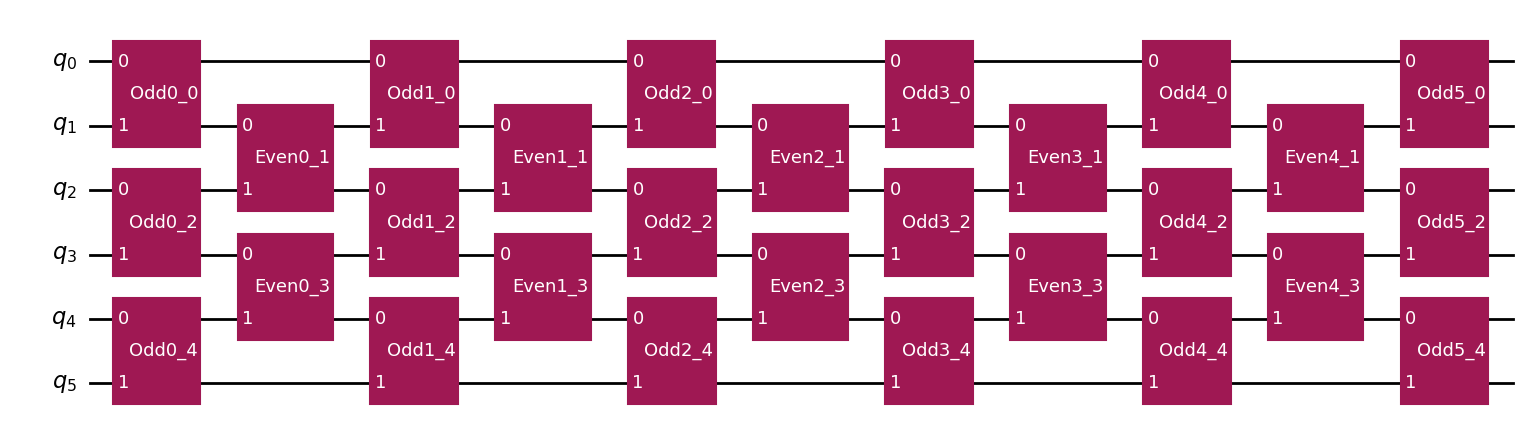

In [4]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_initial_h, pauli_terms=terms_h)
depth_h = qc_initial_h.depth()
qc_initial_h.draw('mpl')

In [5]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, h=h)
print(np.array(gates_h).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 2, 2, 2, 2)


In [6]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, h= load_reference(config['reference_dir'], config['n_sites'], config['n_repetitions'], config['t'])

In [7]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 33), (33, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  3.1528563186888903e-06
	 1 	Current cost:  0.0008704070581657675
	 2 	Current cost:  0.00010205318896394644
	 3 	Current cost:  0.00020570333941272168
	 4 	Current cost:  0.0003747591539728923
	 5 	Current cost:  0.0003463962374810059
	 6 	Current cost:  0.00019490333482496958
	 7 	Current cost:  4.7192160652187454e-05
	 8 	Current cost:  4.02600354267868e-05
	 9 	Current cost:  0.0001544120969343421
	 10 	Current cost:  0.00021672882708201335
	 11 	Current cost:  0.0001511149113468946
	 12 	Current cost:  5.0233636375907054e-05
	 13 	Current cost:  1.6454252889319676e-05
	 14 	Current cost:  5.0094471147899e-05
	 15 	Current cost:  8.743822133450152e-05
	 16 	Current cost:  9.318634349497756e-05
	 17 	Current cost:  7.339485043234006e-05
	 18 	Current cost:  4.255021176136076e-05
	 19 	Current cost:  1.761348321149825e-05
	 20 	Current cost:  1.7393349002414737e-05
	 21 	Current cost:  4.016918793725566e-05
	 22 	Current cost:

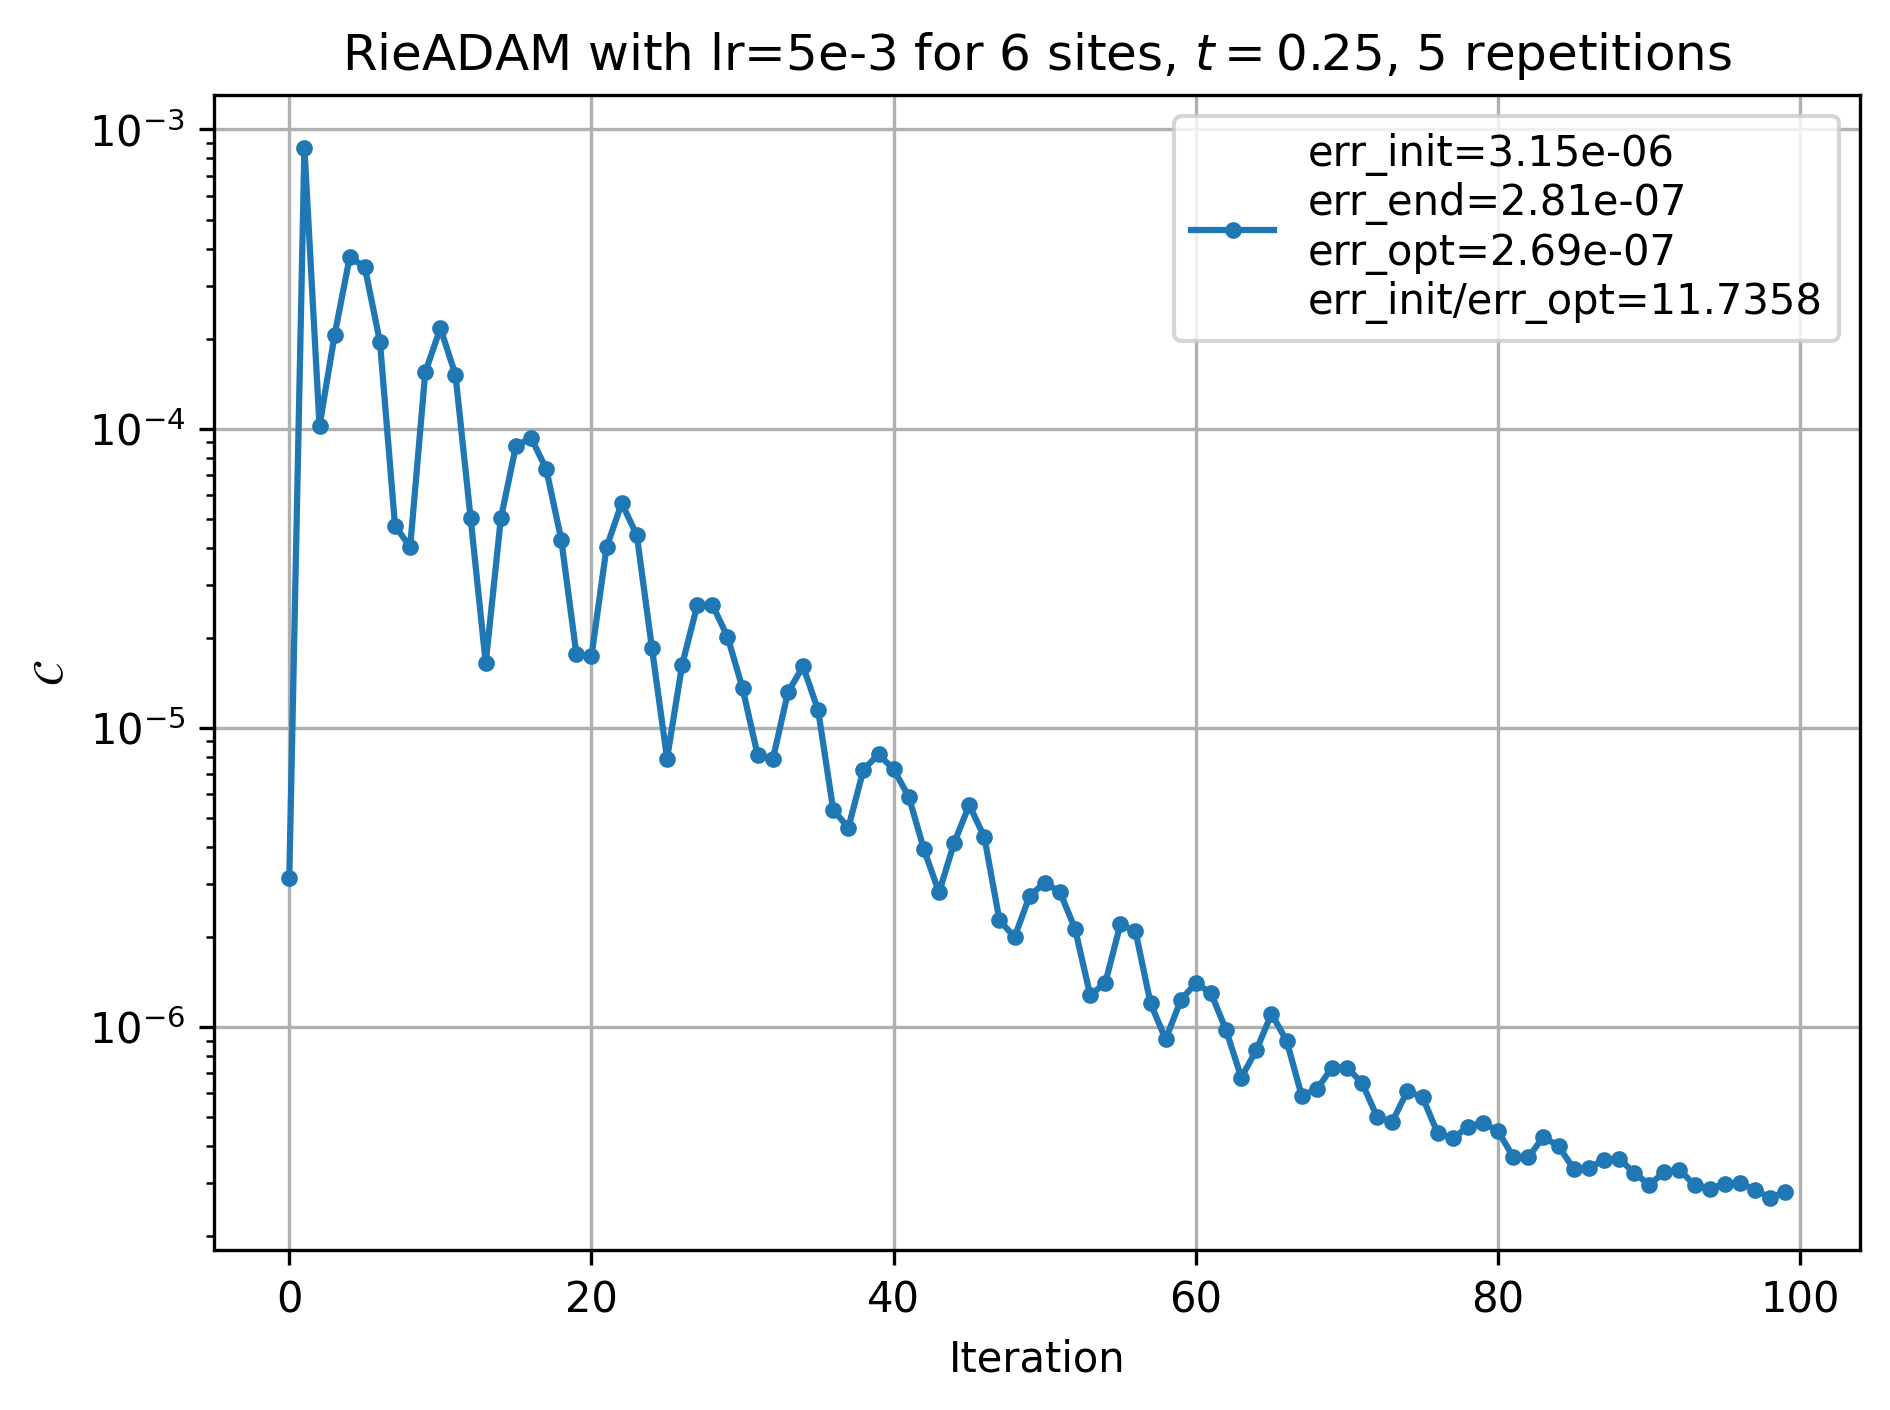

In [8]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM
import pdb

gates_optimised_h, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates_h)

In [9]:
# from qiskit import QuantumCircuit
# from qiskit.quantum_info import Statevector
# from ropt_aqc.comparison_methods import compress_HS

# N_vals = range(1,depth_h)

# df_h, gates_optimised_reshaped_h = compress_HS(gates_h, config, U_ref, N_vals, qc_initial_h)

In [10]:
# from ropt_aqc.brickwall_opt import plot_fidelity

# elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'statevector_fidelity', n_repetitions, 1e-3, method, system)

In [11]:
# # Compress circuit
# # N_vals = [int(elbow_N_h)]
# N_vals = [2]
# df_compressed_h, gates_optimised_reshaped_compressed_h = compress_HS(gates_h, config, U_ref, N_vals, qc_initial_h)

11


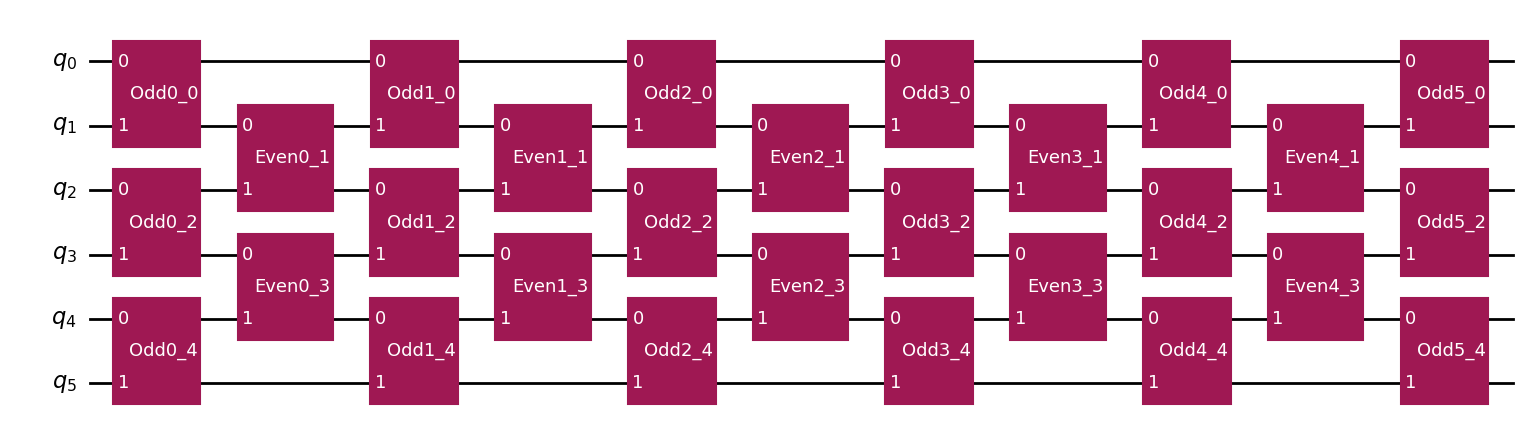

In [12]:
gates_optimised_h = gates_optimised_h.reshape((len(gates_optimised_h), 4, 4))
# gates_optimised_h = gates_optimised_reshaped_compressed_h
# np.allclose(gates_optimised_h, gates_initial_h)  # Should be False
qc_opt_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_optimised_h, pauli_terms=terms_h)
depth_opt_h = qc_opt_h.depth()
print(depth_opt_h)
qc_opt_h.draw('mpl')

In [13]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_observable
H_sparse_h = hamiltonian_to_sparse_observable(terms_h, num_qubits=num_sites)
print(H_sparse_h)

<SparseObservable with 21 terms on 6 qubits: (1+0j)(X_5 X_4) + (1+0j)(Y_5 Y_4) + (-0.5+0j)(Z_5 Z_4) + (1+0j)(X_4 X_3) + (1+0j)(Y_4 Y_3) + (-0.5+0j)(Z_4 Z_3) + (1+0j)(X_3 X_2) + (1+0j)(Y_3 Y_2) + (-0.5+0j)(Z_3 Z_2) + (1+0j)(X_2 X_1) + (1+0j)(Y_2 Y_1) + (-0.5+0j)(Z_2 Z_1) + (1+0j)(X_1 X_0) + (1+0j)(Y_1 Y_0) + (-0.5+0j)(Z_1 Z_0) + (0.75+0j)(X_5) + (0.75+0j)(X_4) + (0.75+0j)(X_3) + (0.75+0j)(X_2) + (0.75+0j)(X_1) + (0.75+0j)(X_0)>


In [14]:
# one option for reference cirucit
# initial time evolution
# construct initial state
from qiskit import QuantumCircuit

initial_state_h = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state_h.x(i)

from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate the AQC target circuit (initial segment)
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit_h = initial_state_h.copy()
aqc_target_circuit_h.compose(
    generate_time_evolution_circuit(
        H_sparse_h,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [15]:
aqc_comparison_circuit_h = initial_state_h.copy()
aqc_comparison_circuit_h.compose(
    generate_time_evolution_circuit(
        H_sparse_h,
        synthesis=SuzukiTrotter(reps=3),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [16]:
# second option for reference circuit 
from ropt_aqc.circuit_building import decompose_unitary_gate
ref_gates_h = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=64,
                                                   hamiltonian=system, degree=degree, J=J, h=h)

ref_circuit_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system=system, gates=ref_gates_h)
native_ref_circuit_h = decompose_unitary_gate(ref_circuit_h)

In [17]:
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit import transpile

native_ref_circuit_transpiled_h = transpile(
    native_ref_circuit_h,
    basis_gates=['rx', 'ry', 'rz', 'cx'],
    optimization_level=3
)

simulator_settings = QuimbSimulator(qtn.CircuitMPS, autodiff_backend="jax")
aqc_target_mps_h= tensornetwork_from_circuit(native_ref_circuit_transpiled_h, simulator_settings)


/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [18]:
from ropt_aqc.comparison_methods import compress_HS_AQC

N_vals = range(1,24)
df_h, aqc_ansatz_h, aqc_initial_parameters_h, aqc_final_parameters_h = compress_HS_AQC(gates_optimised_h, config, simulator_settings, aqc_target_mps_h, aqc_comparison_circuit_h, aqc_target_circuit_h, N_vals, terms_h)

Starting fidelity: 0.5950778683135686
AQC Comparison circuit: depth 97
Target circuit:         depth 1025
Hybrid ansatz circuit:  depth 23, with 270 parameters

=== Optimizing with N = 1 layers ===
2025-05-12 10:49:50.610995 Intermediate result: Fidelity 0.27474292
2025-05-12 10:49:50.611756 Intermediate result: Fidelity 0.27475785
2025-05-12 10:49:50.613302 Intermediate result: Fidelity 0.94049305
2025-05-12 10:49:50.613614 Intermediate result: Fidelity 0.94875031
2025-05-12 10:49:50.613901 Intermediate result: Fidelity 0.96418668
2025-05-12 10:49:50.614235 Intermediate result: Fidelity 0.97282161
2025-05-12 10:49:50.614571 Intermediate result: Fidelity 0.97885419
2025-05-12 10:49:50.614891 Intermediate result: Fidelity 0.98457266
2025-05-12 10:49:50.615169 Intermediate result: Fidelity 0.99203553
2025-05-12 10:49:50.615440 Intermediate result: Fidelity 0.99594005
2025-05-12 10:49:50.615726 Intermediate result: Fidelity 0.99655199
2025-05-12 10:49:50.615999 Intermediate result: Fideli

=== Complete Optimised Circuit ===


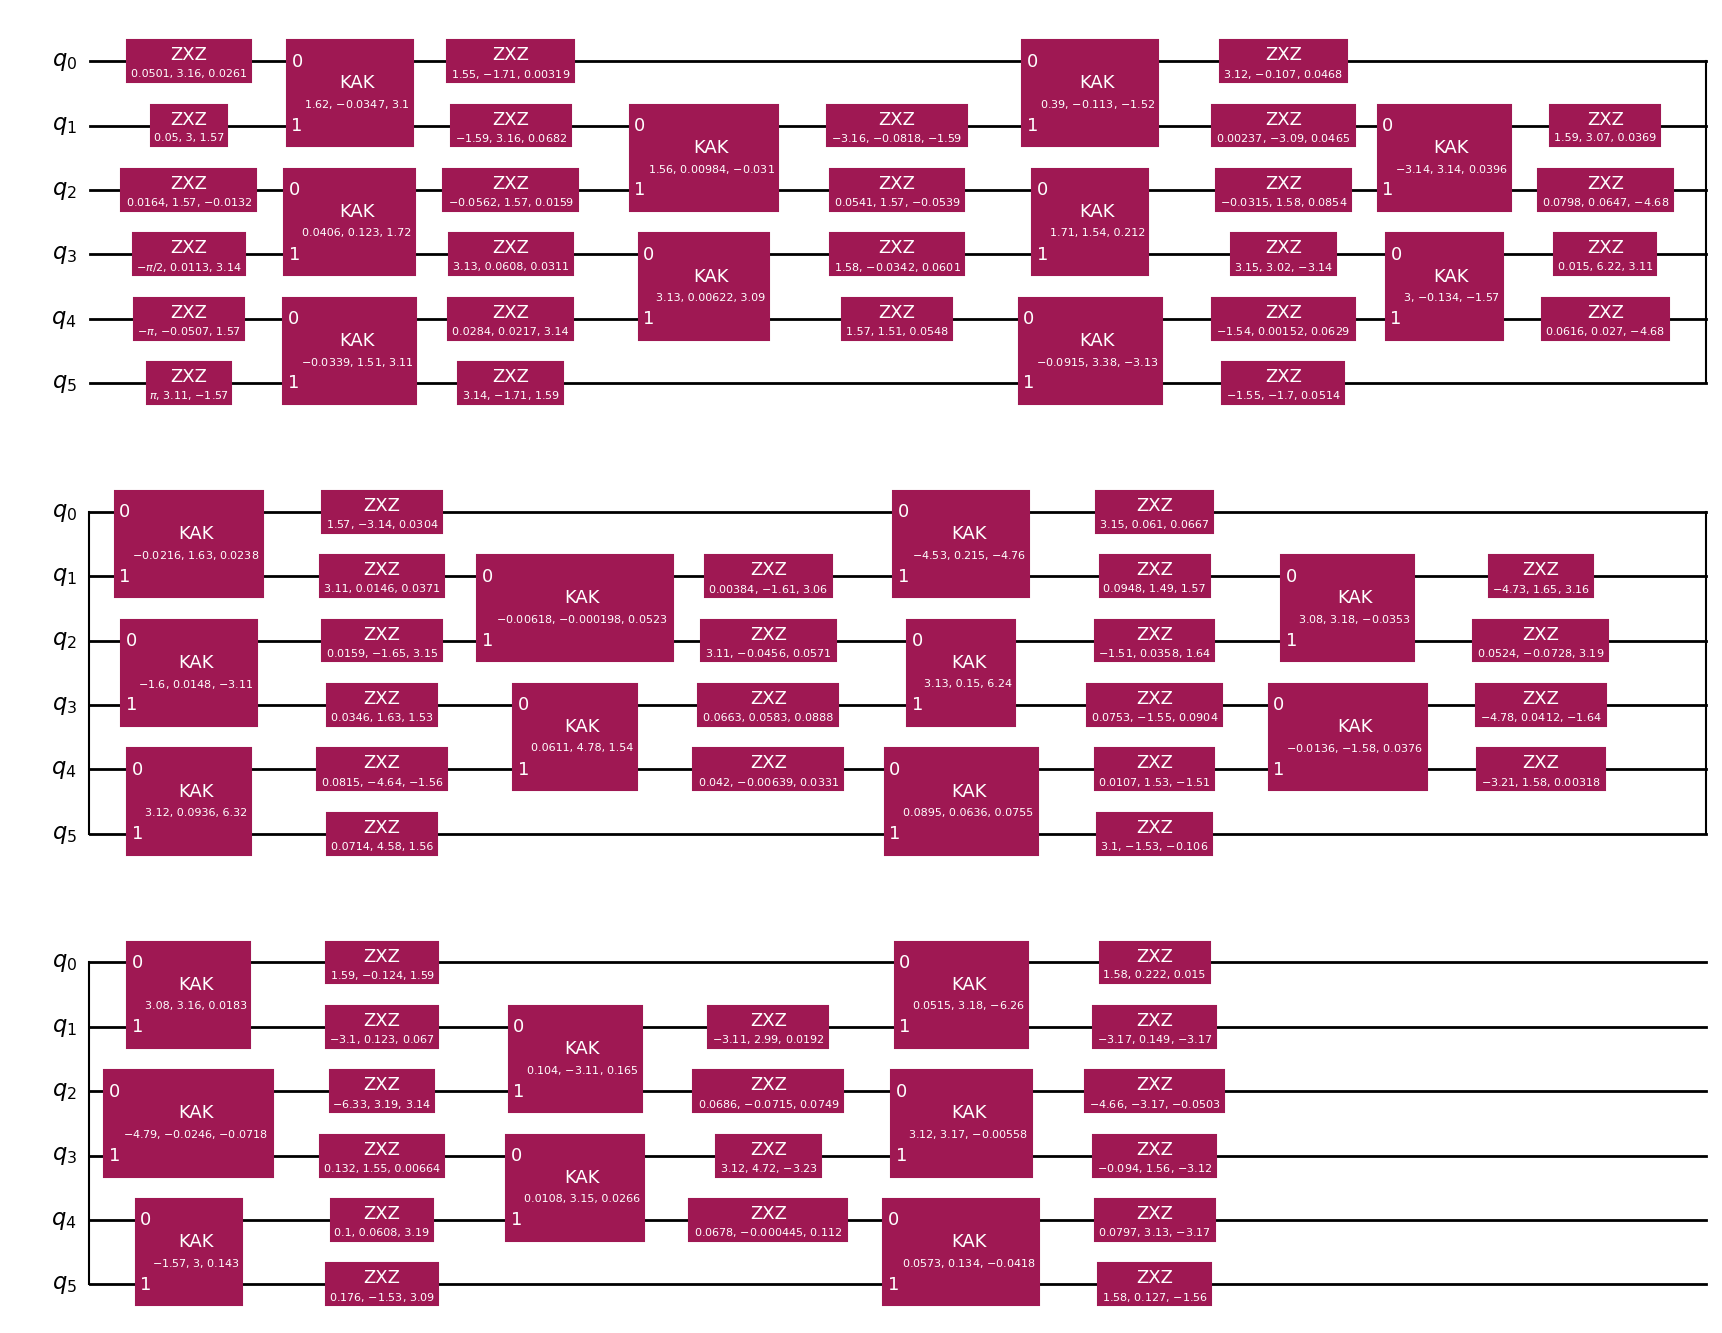

In [19]:
# from the optimised circuit 
aqc_optimised_block_h = aqc_ansatz_h.assign_parameters(aqc_final_parameters_h)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block_h.draw("mpl")

In [ ]:
import pandas as pd
file_path_heisenberg = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/hybrid_initial_Heisenberg_results_{t}.csv'

df_h.to_csv(file_path_heisenberg, index=False, header=True)
# df_h.to_csv(file_path_heisenberg, index=False, mode="a", header=False)

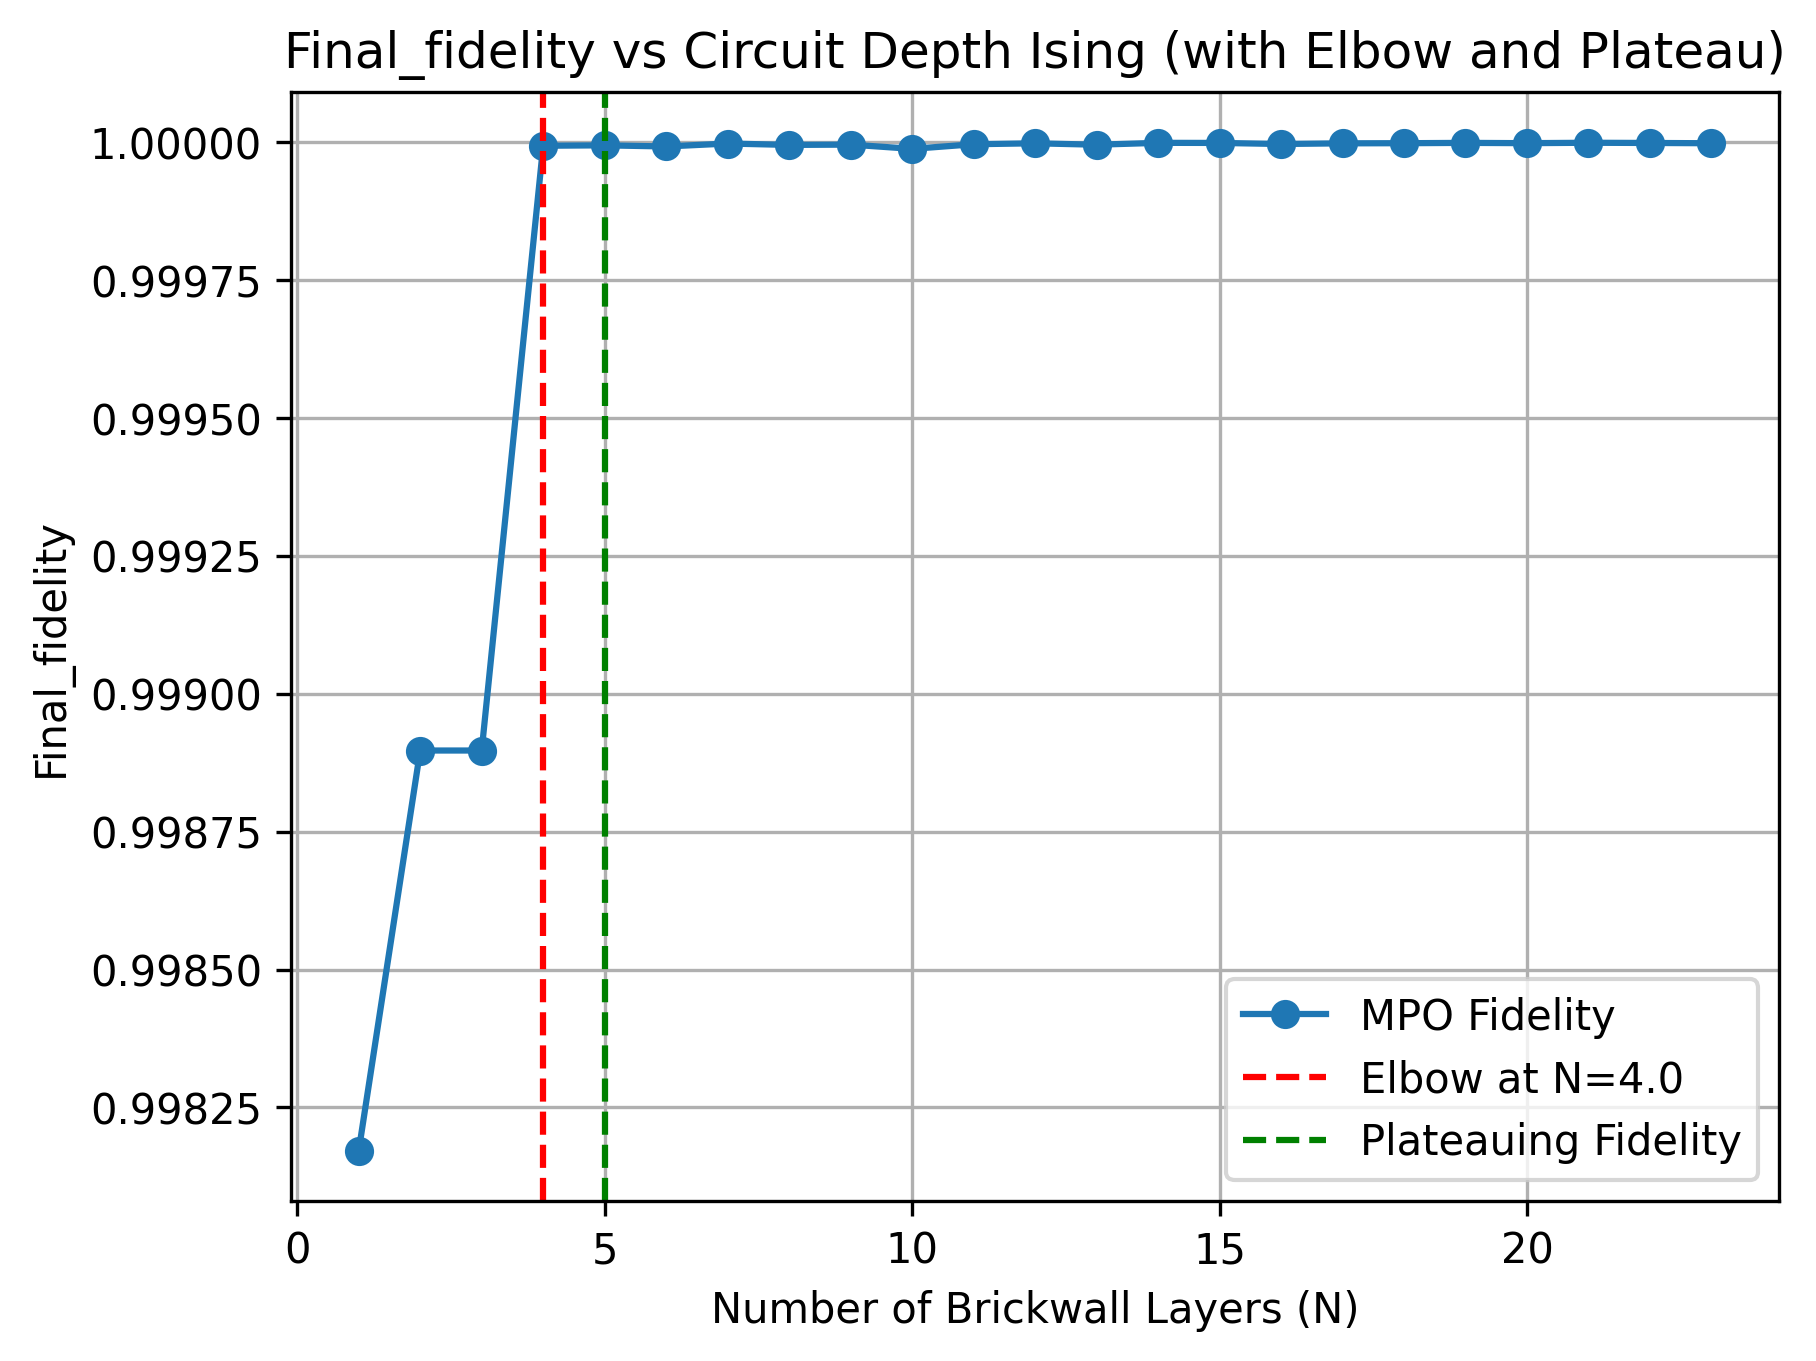


🔍 Suggested optimal compression depth: N = 5.0


In [23]:
from ropt_aqc.brickwall_opt import plot_fidelity
method = 'hybrid'

elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', t, 1e-3, method, system, save_path=True)

In [78]:
# Compress circuit
N_vals = [int(plateau_N_h)]
df_compressed_h, aqc_ansatz_compressed_h, aqc_initial_parameters_compressed_h, aqc_final_parameters_compressed_h = compress_HS_AQC(gates_optimised_h, config, simulator_settings, aqc_target_mps_h, aqc_comparison_circuit_h, aqc_target_circuit_h, N_vals)


=== Optimizing with N = 3 layers ===
(5, 4, 4)
Starting fidelity: 0.6168592272536039
AQC Comparison circuit: depth 97
Target circuit:         depth 1025
Hybrid ansatz circuit:  depth 5, with 63 parameters
2025-04-29 16:35:01.843866 Intermediate result: Fidelity 0.69775826
2025-04-29 16:35:01.844916 Intermediate result: Fidelity 0.90393928
2025-04-29 16:35:01.845726 Intermediate result: Fidelity 0.94873018
2025-04-29 16:35:01.846533 Intermediate result: Fidelity 0.99131609
2025-04-29 16:35:01.847343 Intermediate result: Fidelity 0.99722239
2025-04-29 16:35:01.848138 Intermediate result: Fidelity 0.99835964
2025-04-29 16:35:01.848943 Intermediate result: Fidelity 0.99876041
2025-04-29 16:35:01.849760 Intermediate result: Fidelity 0.99904570
2025-04-29 16:35:01.850891 Intermediate result: Fidelity 0.99912455
2025-04-29 16:35:01.851853 Intermediate result: Fidelity 0.99914262
2025-04-29 16:35:01.852691 Intermediate result: Fidelity 0.99916622
2025-04-29 16:35:01.853503 Intermediate result

=== Compressed Optimised Circuit ===


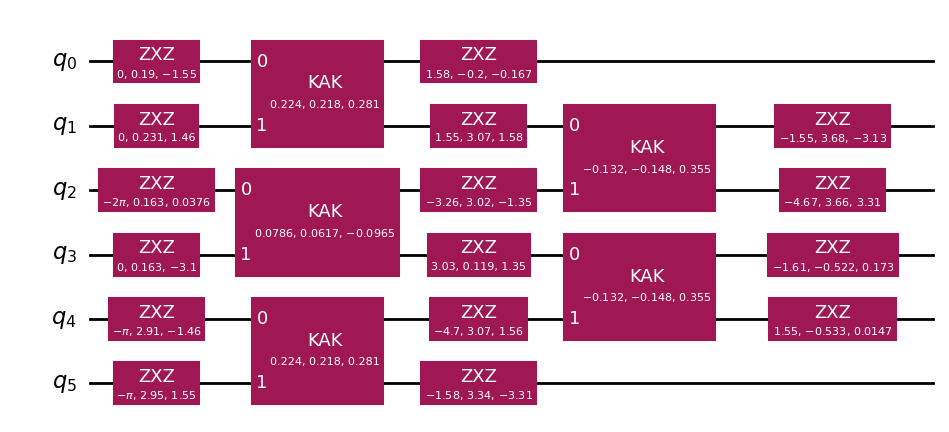

In [79]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed_h = aqc_ansatz_compressed_h.assign_parameters(aqc_final_parameters_compressed_h)
aqc_optimised_compressed_h.draw("mpl")

In [80]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed_h.parameters, aqc_final_parameters_compressed_h):
    print(f"{param}: {value:.6f}")


=== Compressed Optimised Parameters ===
theta[0]: -0.000000
theta[1]: 0.190476
theta[2]: -1.547969
theta[3]: 0.000000
theta[4]: 0.230634
theta[5]: 1.458836
theta[6]: -6.283185
theta[7]: 0.162600
theta[8]: 0.037577
theta[9]: -0.000000
theta[10]: 0.162773
theta[11]: -3.104000
theta[12]: -3.141593
theta[13]: 2.911011
theta[14]: -1.458923
theta[15]: -3.141593
theta[16]: 2.951173
theta[17]: 1.547953
theta[18]: 0.223799
theta[19]: 0.218055
theta[20]: 0.281126
theta[21]: 1.584126
theta[22]: -0.199931
theta[23]: -0.166852
theta[24]: 1.554380
theta[25]: 3.067117
theta[26]: 1.584552
theta[27]: 0.078638
theta[28]: 0.061714
theta[29]: -0.096468
theta[30]: -3.257985
theta[31]: 3.022426
theta[32]: -1.352112
theta[33]: 3.025262
theta[34]: 0.119012
theta[35]: 1.352205
theta[36]: 0.223681
theta[37]: 0.217952
theta[38]: 0.281015
theta[39]: -4.695929
theta[40]: 3.067194
theta[41]: 1.557037
theta[42]: -1.584031
theta[43]: 3.341541
theta[44]: -3.308536
theta[45]: -0.132450
theta[46]: -0.148023
theta[47]: 

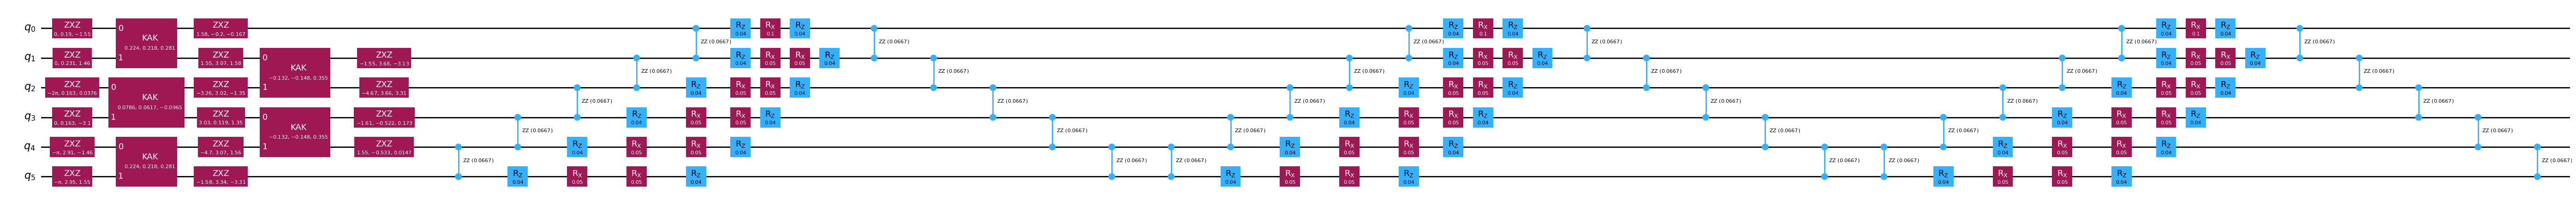

In [81]:
intermediate_composed_circuit_h = aqc_optimised_compressed_h.compose(subsequent_circuit)
intermediate_composed_circuit_h.draw("mpl", fold=-1)

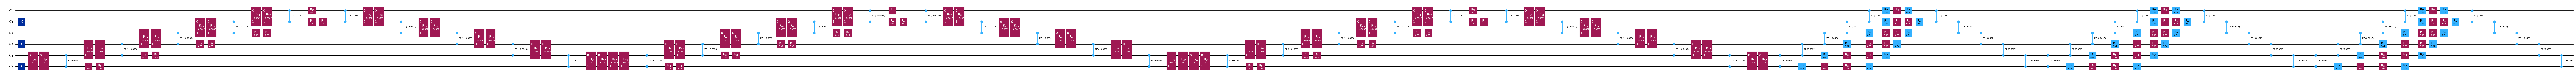

In [63]:
# merge comparison circuit with remaining time evolution circuit also
aqc_comparison_circuit_h.compose(subsequent_circuit, inplace=True)
aqc_comparison_circuit_h.draw("mpl", fold=-1)

In [184]:
import jax.numpy as jnp

def apply_two_site_gate_to_mpo(mpo, gate, site1, site2, max_bondim=512):
    assert site2 == site1 + 1, "Only adjacent sites are supported."

    A1 = mpo[site1]
    A2 = mpo[site2]
    assert A1.shape[3] == A2.shape[0], "Bond mismatch"

    # Merge tensors
    T = jnp.einsum('lpqr,rmst->lpmqst', A1, A2).transpose(0, 1, 3, 2, 4, 5)
    T = T.reshape(A1.shape[0]*A2.shape[1], 4, A2.shape[2]*A2.shape[3])
    T = jnp.einsum('ij,ajk->aik', gate.reshape(4, 4), T).reshape(T.shape[0], -1)

    U, S, Vh = jnp.linalg.svd(T, full_matrices=False)
    chi = min(len(S), max_bondim)
    sqrt_S = jnp.sqrt(S[:chi])
    U = U[:, :chi] @ jnp.diag(sqrt_S)
    Vh = jnp.diag(sqrt_S) @ Vh[:chi, :]

    left_dim = A1.shape[0]
    right_dim = A2.shape[3]

    # --- A1 reshape ---
    try:
        A1_new = U.reshape(left_dim, 2, 2, chi)
    except Exception as e:
        print("⚠️ A1 reshape fallback — padding U")
        padded = jnp.zeros((left_dim * 4, chi), dtype=U.dtype)
        padded = padded.at[:U.shape[0], :U.shape[1]].set(U)
        A1_new = padded.reshape(left_dim, 2, 2, chi)

    # --- A2 reshape ---
    try:
        A2_new = Vh.reshape(chi, 2, 2, right_dim)
    except Exception as e:
        print("⚠️ A2 reshape fallback — padding Vh")
        required_size = chi * 2 * 2 * right_dim
        flat = Vh.flatten()

        padded = jnp.zeros((required_size,), dtype=Vh.dtype)
        padded = padded.at[:flat.size].set(flat[:min(flat.size, required_size)])  # Truncate if necessary
        A2_new = padded.reshape(chi, 2, 2, right_dim)


    return mpo[:site1] + [A1_new, A2_new] + mpo[site2+1:]


In [163]:
from ropt_aqc.tn_brickwall_methods import get_id_mpo
from ropt_aqc.comparison_methods import compute_error_mpo

mpo = get_id_mpo(num_sites)  # (Dl, 2, 2, Dr) format

def compute_reference_from_circuit(config, circuit, ref_batch=0, ref_seed=0):
    from qiskit.quantum_info import Operator
    from ropt_aqc.tn_helpers import get_id_mpo, compress_mpo
    from ropt_aqc.save_model import save_reference

    import os
    from time import time
    tstart = time()

    n_sites = config["n_sites"]
    bond_dim = 128
    compress = config.get("compress", True)

    mpo = get_id_mpo(n_sites)  # Start from identity

    # Apply each gate in the circuit
    for inst in circuit.data:
        gate = inst.operation
        qubits = [circuit.find_bit(q).index for q in inst.qubits]

        if len(qubits) == 1:
            q0 = qubits[0]
            U = Operator(gate).data
            I = jnp.eye(2)
            if q0 < n_sites - 1:
                U_ext = jnp.kron(U, I).reshape(4, 4)
                mpo = apply_two_site_gate_to_mpo(mpo, U_ext, q0, q0+1, max_bondim=bond_dim)
            else:
                U_ext = jnp.kron(I, U).reshape(4, 4)
                mpo = apply_two_site_gate_to_mpo(mpo, U_ext, q0-1, q0, max_bondim=bond_dim)

        elif len(qubits) == 2:
            q0, q1 = sorted(qubits)
            assert q1 == q0 + 1, "Only adjacent 2-qubit gates are supported"
            U = Operator(gate).data
            mpo = apply_two_site_gate_to_mpo(mpo, U, q0, q1, max_bondim=bond_dim)

    # Compress
    if compress:
        mpo_comp = compress_mpo(mpo, bond_dim)
        err = compute_error_mpo(mpo, mpo_comp)
        print(f"Compression error: {err}")
        mpo = mpo_comp

    path = os.path.join(os.getcwd(), config['hamiltonian'], "reference")
    print("Saving to path:", path)
    # # _ = save_reference(path, mpo, config["t"], config["n_sites"], config["degree"], config["n_repetitions"],
    #                    err_threshold=None, hamiltonian=config["hamiltonian"],
    #                    H=None, ref_seed=ref_seed, ref_nbr=ref_batch)


    return mpo

U_ref_sub =compute_reference_from_circuit(config, subsequent_circuit)
print("U_ref shape:", [m.shape for m in U_ref_sub])


⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh
⚠️ A1 

In [96]:
from ropt_aqc.brickwall_circuit import get_gate_qubit_pairs

flat_gate_list, _ = get_gate_qubit_pairs(
    subsequent_gates,
    n_sites=num_sites,
    degree=degree,
    n_repetitions=n_repetitions,
    n_id_layers=n_id_layers,
    hamiltonian=system
)
print(flat_gate_list[:2])
flat_gate_list = [item for layer in flat_gate_list for item in layer]



[[(1, 2, Array([[[[ 0.91501807+0.36850438j, -0.0088359 +0.0727204j ],
         [-0.00880025+0.14621611j, -0.01108941-0.00074142j]],

        [[-0.0088359 +0.0727204j ,  0.97628002-0.13866466j],
         [-0.01108927+0.00074571j,  0.00894293+0.14859209j]]],


       [[[-0.00880025+0.14621611j, -0.01108927+0.00074571j],
         [ 0.95256573-0.2560946j ,  0.0089071 +0.07331182j]],

        [[-0.01108941-0.00074142j,  0.00894293+0.14859209j],
         [ 0.0089071 +0.07331182j,  0.98581921+0.02057714j]]]],      dtype=complex128)), (3, 4, Array([[[[ 0.94372307+0.31375063j, -0.00443844+0.07374533j],
         [-0.00443844+0.07374533j, -0.0055704 -0.00037228j]],

        [[-0.00443844+0.07374533j,  0.97449621-0.19829598j],
         [-0.00557037+0.00037335j,  0.00447421+0.07434098j]]],


       [[[-0.00443844+0.07374533j, -0.00557037+0.00037335j],
         [ 0.97449621-0.19829598j,  0.00447421+0.07434098j]],

        [[-0.0055704 -0.00037228j,  0.00447421+0.07434098j],
         [ 0.00447421+0.0

In [126]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def convert_unitary_to_mpo_quimb(U, n_sites, max_bond_dim=None):
    """
    Convert a dense unitary to MPO format (Dl, 2, 2, Dr) using Quimb.

    Args:
        U: np.ndarray of shape (2^n, 2^n)
        n_sites: number of qubits
        max_bond_dim: optional max bond dim

    Returns:
        List of np.arrays shaped (Dl, 2, 2, Dr)
    """
    # Build MPO from dense unitary
    mpo = qtn.MatrixProductOperator.from_dense(U, dims=[2] * n_sites)

    if max_bond_dim:
        mpo.compress(max_bond=max_bond_dim)

    mpo_tensors = []
    for site in range(n_sites):
        A = mpo[site].data  # raw tensor
        shape = A.shape

        # Find positions of physical (2,2) and bond dimensions
        phys_inds = [i for i, s in enumerate(shape) if s == 2]
        bond_inds = [i for i, s in enumerate(shape) if s != 2]

        assert len(phys_inds) == 2, f"Site {site} should have exactly 2 physical legs"
        assert len(bond_inds) in [1, 2], f"Site {site} should have 1 or 2 bond legs"

        # If only one bond (at edge), prepend or append singleton
        if len(bond_inds) == 1:
            if bond_inds[0] < phys_inds[0]:  # bond is left
                bond_order = (bond_inds[0], phys_inds[0], phys_inds[1])
                A = A.transpose(bond_order).reshape(1, 2, 2, shape[bond_inds[0]])
            else:  # bond is right
                bond_order = (phys_inds[0], phys_inds[1], bond_inds[0])
                A = A.transpose(bond_order).reshape(shape[bond_inds[0]], 2, 2, 1)
        else:
            Dl, Dr = shape[bond_inds[0]], shape[bond_inds[1]]
            A = A.transpose(bond_inds[0], phys_inds[0], phys_inds[1], bond_inds[1]).reshape(Dl, 2, 2, Dr)

        mpo_tensors.append(A)

    return mpo_tensors


U_ref_sub = convert_unitary_to_mpo_quimb(reference_unitary, n_sites=6)
print("U_ref shape:", [m.shape for m in U_ref_sub])

U_ref shape: [(4, 2, 2, 1), (4, 2, 2, 4), (4, 2, 2, 4), (4, 2, 2, 4), (4, 2, 2, 4), (1, 2, 2, 4)]


In [132]:
from ropt_aqc.brickwall_circuit import get_gates_per_layer
from ropt_aqc.tn_brickwall_methods import contract_layers_of_swap_network_with_mpo, get_id_mpo
from ropt_aqc.comparison_methods import compute_error_mpo

mpo_id = get_id_mpo(nsites=6)
gates_per_layer, layer_is_odd = get_gates_per_layer(
    gates, n_sites=num_sites, degree=degree, n_repetitions=n_repetitions, hamiltonian=system 
)

mpo_init = contract_layers_of_swap_network_with_mpo(
    mpo_id, gates_per_layer, layer_is_odd, layer_is_left=True, max_bondim=128, get_norm=False
)
err = compute_error_mpo(U_ref, mpo_init)
print(f"Initial MPO fidelity error: {err:.4e}")



Initial MPO fidelity error: 1.9898e+00


In [139]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np

def convert_unitary_to_mpo_quimb_fixed(U, n_sites, max_bond_dim=None):
    """
    Convert a dense unitary matrix U into an MPO compatible with (Dl, 2, 2, Dr) format.
    Handles physical axis reordering and compression.

    Args:
        U: np.ndarray of shape (2^n, 2^n)
        n_sites: number of qubits
        max_bond_dim: optional max bond dim

    Returns:
        List of np.arrays shaped (Dl, 2, 2, Dr)
    """
    mpo = qtn.MatrixProductOperator.from_dense(U, dims=[2]*n_sites)

    if max_bond_dim:
        mpo.compress(max_bond=max_bond_dim)

    mpo_tensors = []

    for i, site in enumerate(mpo):
        A = site.data
        shape = A.shape

        if len(shape) == 3:
            # Boundary tensor: (2, 2, D)
            if shape[0] == 2 and shape[1] == 2:
                # left boundary
                A = A.transpose(2, 0, 1).reshape(1, 2, 2, shape[2])
            else:
                # right boundary
                A = A.transpose(0, 1, 2).reshape(shape[0], 2, 2, 1)

        elif len(shape) == 4:
            # Middle tensor: (Dl, 2, 2, Dr)
            if shape[1] == 2 and shape[2] == 2:
                pass  # correct order already
            else:
                raise ValueError(f"Unexpected tensor shape at site {i}: {shape}")
        else:
            raise ValueError(f"Invalid MPO tensor rank at site {i}: {shape}")

        mpo_tensors.append(A)

    return mpo_tensors


from ropt_aqc.tn_helpers import mpo_to_dense
U = Operator(subsequent_circuit).data
U_ref = convert_unitary_to_mpo_quimb_fixed(U, n_sites=6)

U_ref_sub = [jnp.asarray(A) for A in U_ref]
U_ref_dense = mpo_to_dense(U_ref_sub)

diff_norm = jnp.linalg.norm(U_ref_dense - U)
print("‖U_ref_dense - reference_unitary‖ =", diff_norm)

err_unitary = jnp.linalg.norm(U_ref_dense.conj().T @ U_ref_dense - jnp.eye(U_ref_dense.shape[0]))
print("‖U†U - I‖ =", err_unitary)

‖U_ref_dense - reference_unitary‖ = 7.7297986187921355
‖U†U - I‖ = 7.86497259258521


In [151]:
import numpy as np
import jax.numpy as jnp

def convert_unitary_to_mpo_manual(U, n_sites, max_bond_dim=None):
    """
    Convert a unitary matrix U (2^n × 2^n) into an MPO: list of (Dl, 2, 2, Dr) tensors.
    Guaranteed unitary-preserving structure.
    """
    assert U.shape == (2**n_sites, 2**n_sites)

    # Step 1: reshape into 2n tensor (i0...in-1, j0...jn-1)
    U_tensor = U.reshape([2] * (2 * n_sites))

    # Interleave physical indices: (i0, j0, i1, j1, ..., in-1, jn-1)
    U_tensor = U_tensor.transpose(
        [i for pair in zip(range(n_sites), range(n_sites, 2 * n_sites)) for i in pair]
    )

    # Group into (1, 4, 4, ..., 4, 1)
    U_tensor = U_tensor.reshape((1,) + (4,) * n_sites + (1,))
    mpo = []
    tensor = U_tensor

    for i in range(n_sites - 1):
        Dl = tensor.shape[0]
        Dp = tensor.shape[1]
        Dr = int(np.prod(tensor.shape[2:]))

        tensor = tensor.reshape(Dl * Dp, Dr)

        # SVD
        U_svd, S, Vh = np.linalg.svd(tensor, full_matrices=False)
        chi = min(len(S), max_bond_dim or len(S))

        U_svd = U_svd[:, :chi]
        S = S[:chi]
        Vh = Vh[:chi, :]

        U_svd = U_svd @ np.diag(np.sqrt(S))
        Vh = np.diag(np.sqrt(S)) @ Vh

        # Reshape U_svd into MPO tensor
        A = U_svd.reshape(Dl, 2, 2, chi)
        mpo.append(jnp.asarray(A))

        # Reshape Vh to feed into next loop
        remaining_dim = tensor.shape[1]
        tensor = Vh.reshape(chi, *(tensor.shape[1:]))

    # Final site
    A_last = tensor.reshape(tensor.shape[0], 2, 2, 1)
    mpo.append(jnp.asarray(A_last))

    return mpo


U = Operator(subsequent_circuit).data
U_ref_mpo = convert_unitary_to_mpo_manual(U, n_sites=6)
U_dense = mpo_to_dense(U_ref_mpo)

print("‖U_dense - U_ref‖ =", jnp.linalg.norm(U_dense - U))
print("‖U†U - I‖ =", jnp.linalg.norm(U_dense.conj().T @ U_dense - jnp.eye(U.shape[0])))


ValueError: cannot reshape array of size 4096 into shape (4,2,2,1)

In [109]:
from ropt_aqc.tn_helpers import get_id_mpo

mpo = get_id_mpo(num_sites)
for q0, q1, gate in flat_gate_list: 
    mpo = apply_two_site_gate_to_mpo(mpo, gate, q0, q1, 128)


⚠️ A1 reshape fallback — padding U
⚠️ A2 reshape fallback — padding Vh


/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:137: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


ValueError: Incompatible shapes for broadcasting: (16,) and requested shape (2, 4)

In [100]:
from ropt_aqc.tn_helpers import inner_product_mps, get_left_canonical_mps, convert_mpo_to_mps

U_ref_mpo = convert_mpo_to_mps(mpo)

mps_ref_norm = inner_product_mps(
    get_left_canonical_mps(U_ref_mpo, normalize=True, get_norm=False),
    get_left_canonical_mps(U_ref_mpo, normalize=True, get_norm=False)
)
print("Reference MPO norm (should be ~1):", mps_ref_norm)


Reference MPO norm (should be ~1): (0.9999999999999998+1.5765149272957233e-17j)


In [166]:
from ropt_aqc.tn_helpers import mpo_to_dense

# U_ref_fixed = U_ref[::-1]
# U_ref_sub = [jnp.asarray(A) for A in U_ref_fixed]
U_ref_dense = mpo_to_dense(U_ref_sub)

for i, A in enumerate(U_ref_sub):
    print(f"Site {i}: shape {A.shape}")

diff_norm = jnp.linalg.norm(U_ref_dense - reference_unitary)
print("‖U_ref_dense - reference_unitary‖ =", diff_norm)

err_unitary = jnp.linalg.norm(U_ref_dense.conj().T @ U_ref_dense - jnp.eye(U_ref_dense.shape[0]))
print("‖U†U - I‖ =", err_unitary)


Site 0: shape (1, 2, 2, 2)
Site 1: shape (2, 2, 2, 4)
Site 2: shape (4, 2, 2, 8)
Site 3: shape (8, 2, 2, 16)
Site 4: shape (16, 2, 2, 4)
Site 5: shape (4, 2, 2, 1)
‖U_ref_dense - reference_unitary‖ = 7.886990274991707
‖U†U - I‖ = 7.874070765685367


In [167]:
U_dense = mpo_to_dense(U_ref_sub)
svals = jnp.linalg.svd(U_dense, compute_uv=False)
print("Singular values of U_ref_sub:", svals)


Singular values of U_ref_sub: [0.98881073 0.98881073 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  1.7080896092870717
	 1 	Current cost:  1.5469939737519898
	 2 	Current cost:  1.4590326842024375
	 3 	Current cost:  1.3679473259040908
	 4 	Current cost:  1.2736707160990246
	 5 	Current cost:  1.2208354580408698
	 6 	Current cost:  1.2029187214051973
	 7 	Current cost:  1.175104442600955
	 8 	Current cost:  1.1300531199142858
	 9 	Current cost:  1.0838616339775142
	 10 	Current cost:  1.0383649253442222
	 11 	Current cost:  0.9808340417743713
	 12 	Current cost:  0.9101597744983063
	 13 	Current cost:  0.8404653266648461
	 14 	Current cost:  0.7809073456351556
	 15 	Current cost:  0.7269733388881703
	 16 	Current cost:  0.6763435445193551
	 17 	Current cost:  0.6385919457084142
	 18 	Current cost:  0.6207743306475315
	 19 	Current cost:  0.6128301672405627
	 20 	Current cost:  0.5983358390698754
	 21 	Current cost:  0.5740173455543616
	 22 	Current cost:  0.5481666455233116
	 23 	Current cost:  0.5263683483344572
	 24 	Curren

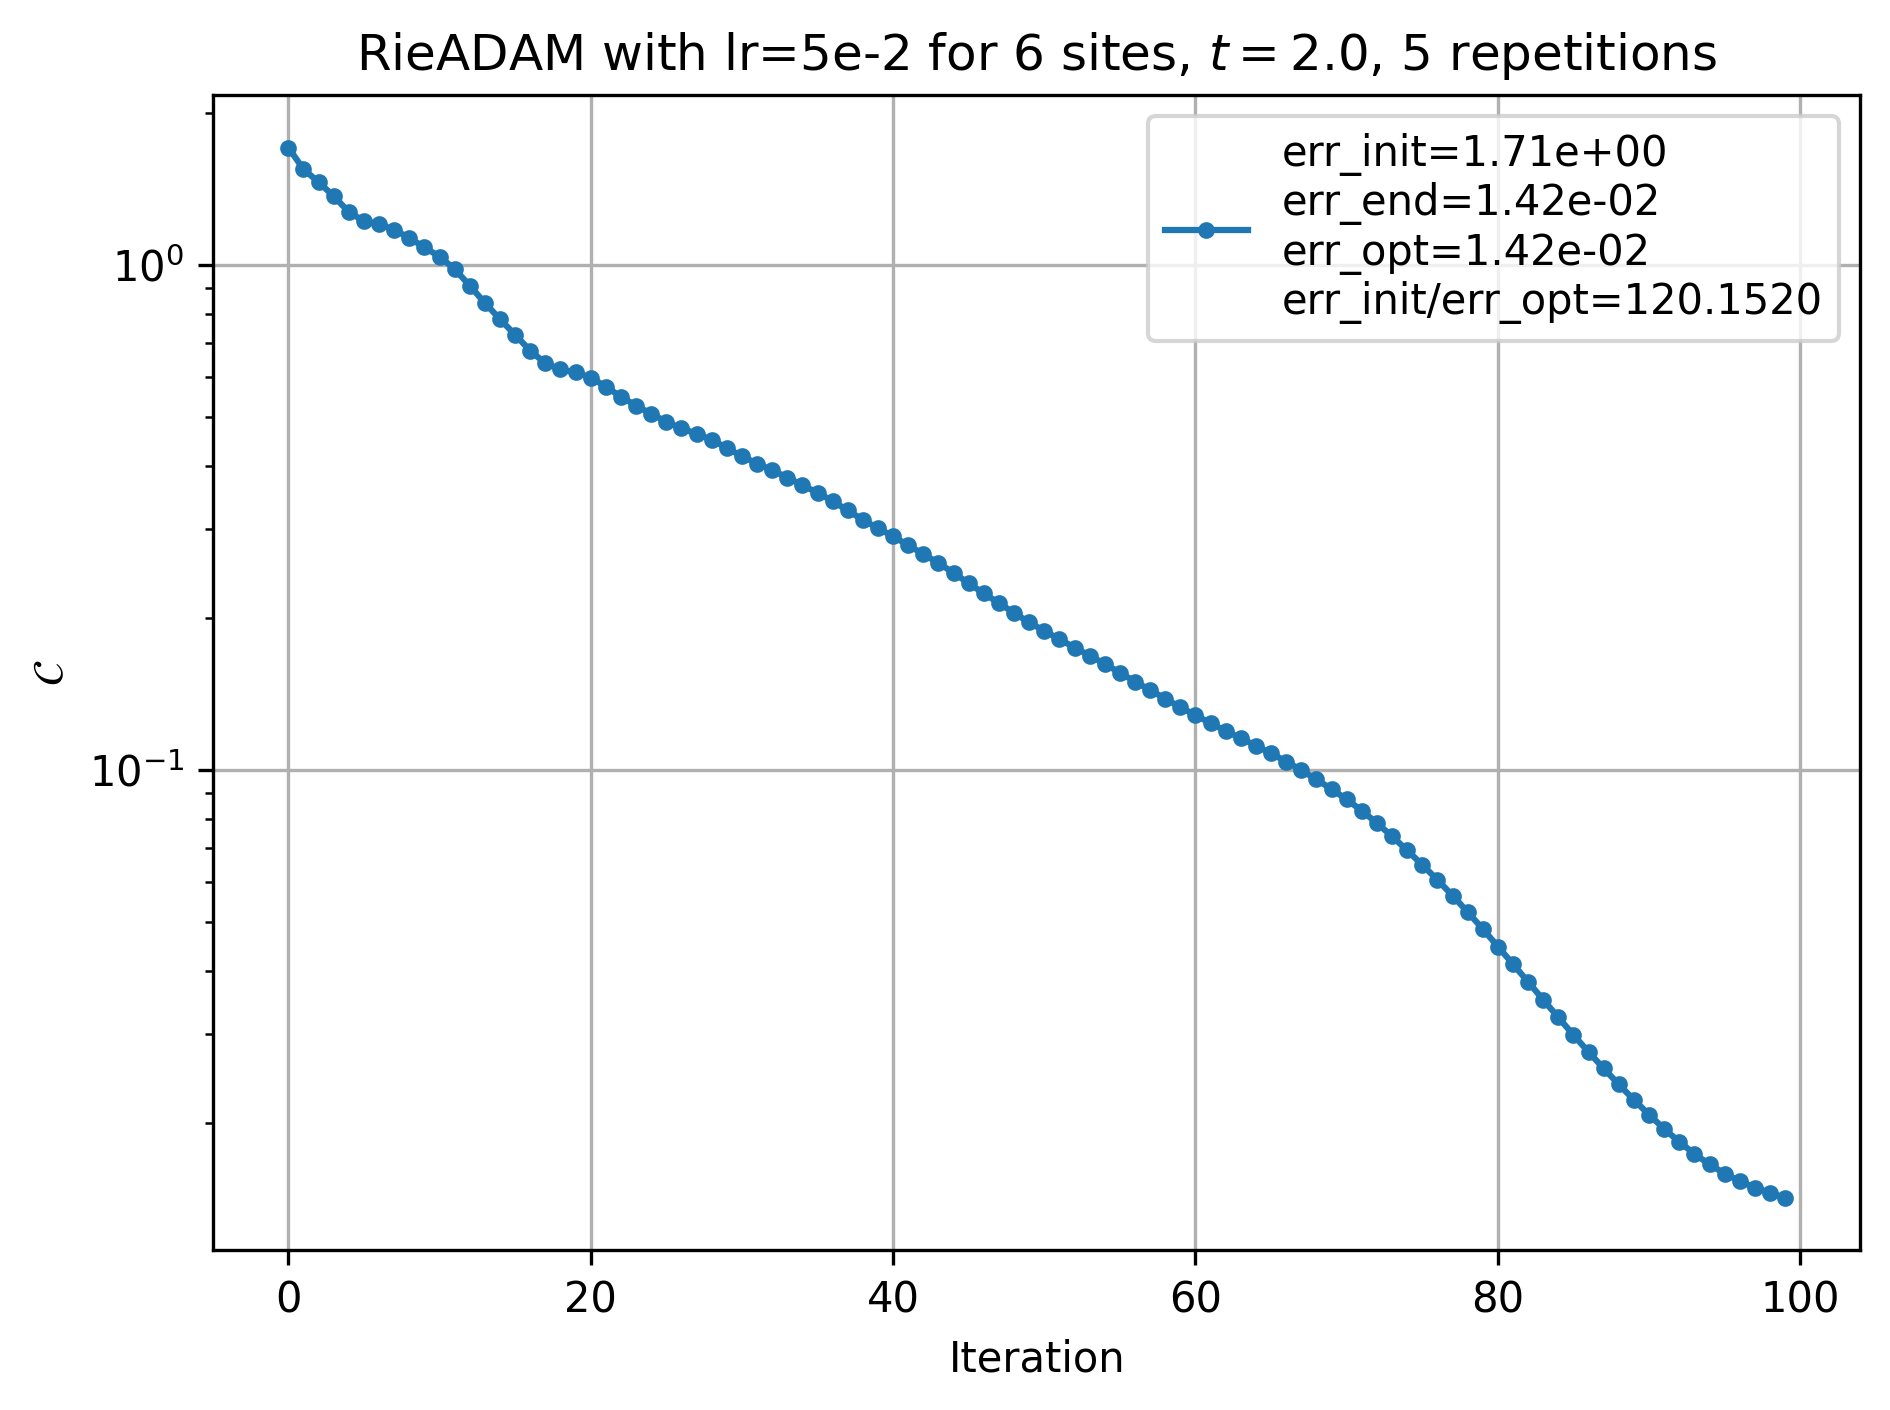

In [31]:
# Hilbert Schmidt optimisaiton on subseuquent cirucit that AQC can not hekp with

gates_optimised_2, err_iter_2 = optimize_swap_network_circuit_RieADAM(config, U_ref_sub, subsequent_gates)


=== Optimizing with N = 1 layers ===
Start Riemannian ADAM optimization ...
⚠️ Truncating at layer 1, only 3 gates available (requested 11 layers)
	 0 	Current cost:  0.21990349559457845
	 1 	Current cost:  0.18370950851101497
	 2 	Current cost:  0.15051251652127196
	 3 	Current cost:  0.12050306861303572
	 4 	Current cost:  0.093840562007389
	 5 	Current cost:  0.07064283747329814
	 6 	Current cost:  0.050974430757959155
	 7 	Current cost:  0.03483401118300855
	 8 	Current cost:  0.02214209026143754
	 9 	Current cost:  0.012730810734279396
	 10 	Current cost:  0.0063383764666380404
	 11 	Current cost:  0.002611098666503109
	 12 	Current cost:  0.001115596536694241
	 13 	Current cost:  0.0013620058482630704
	 14 	Current cost:  0.0028363090702479
	 15 	Current cost:  0.005037118201603796
	 16 	Current cost:  0.007510777123567625
	 17 	Current cost:  0.009879232851779163
	 18 	Current cost:  0.01185730928184614
	 19 	Current cost:  0.013258642946766042
	 20 	Current cost:  0.0139916166

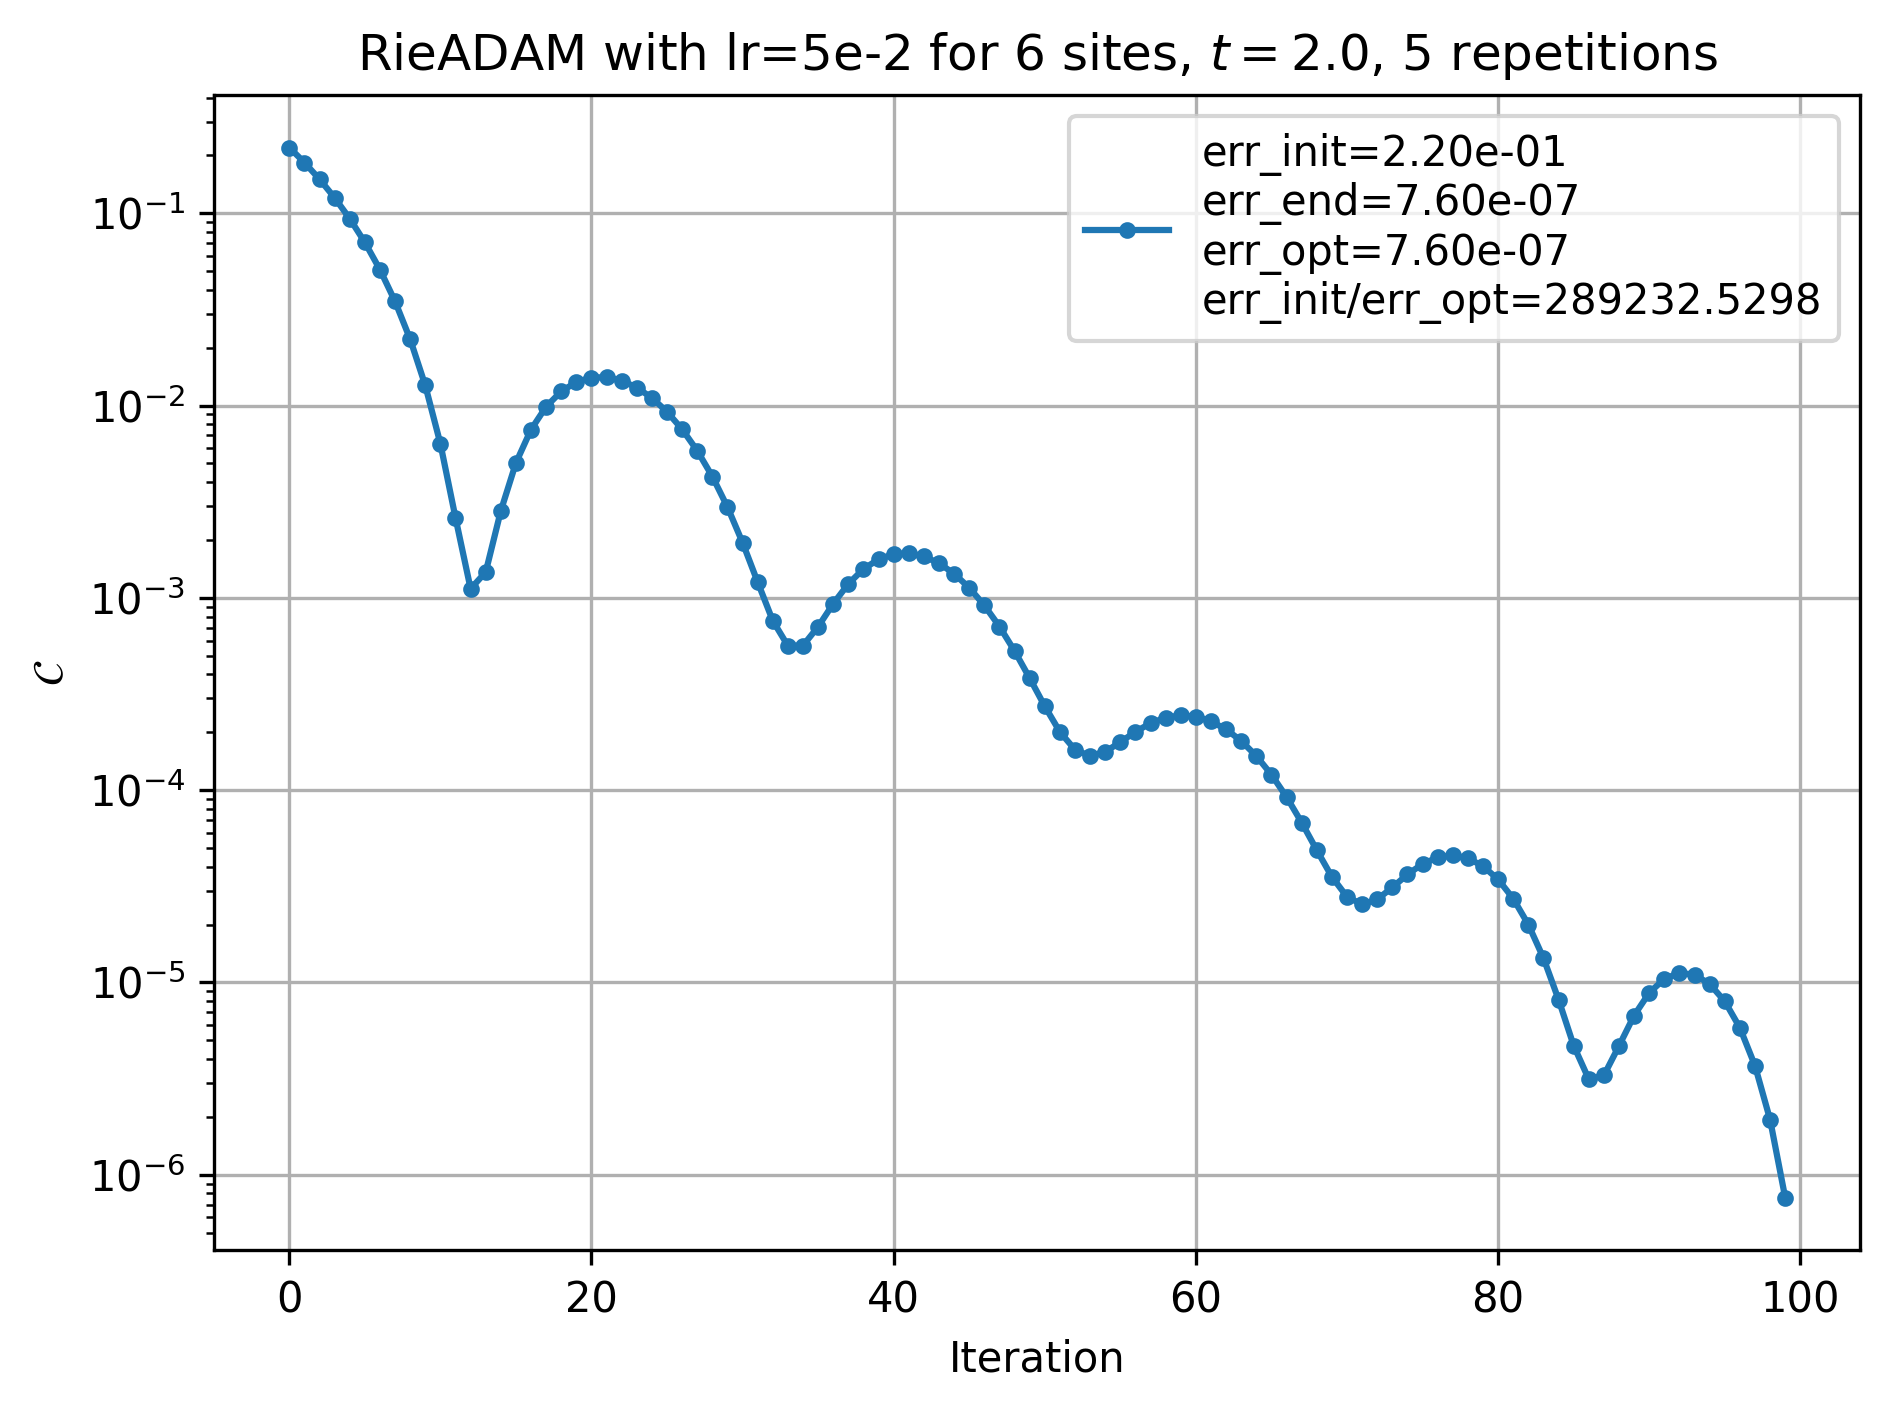

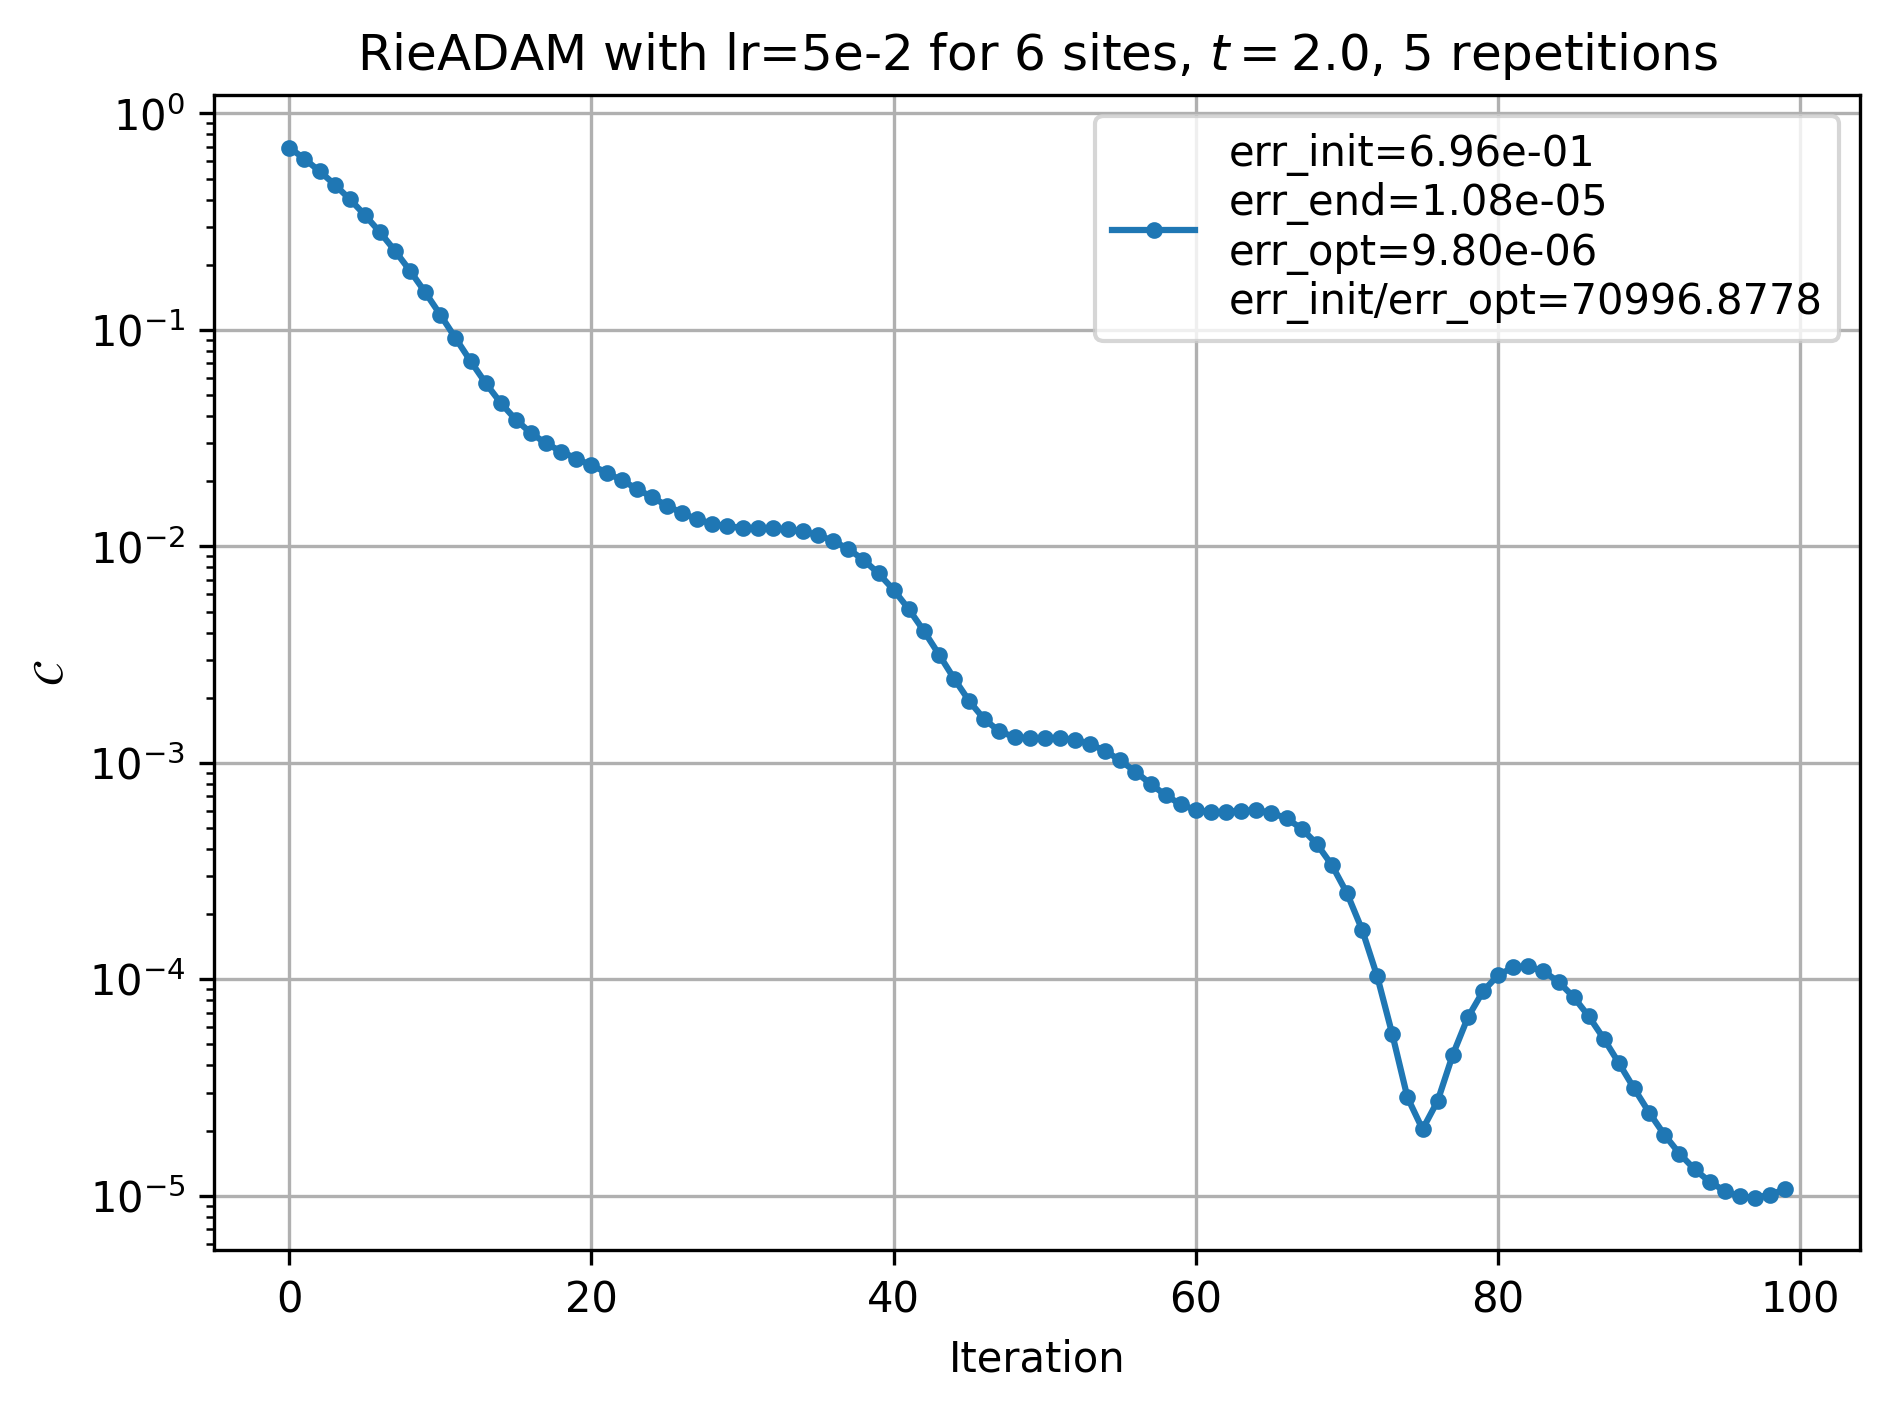

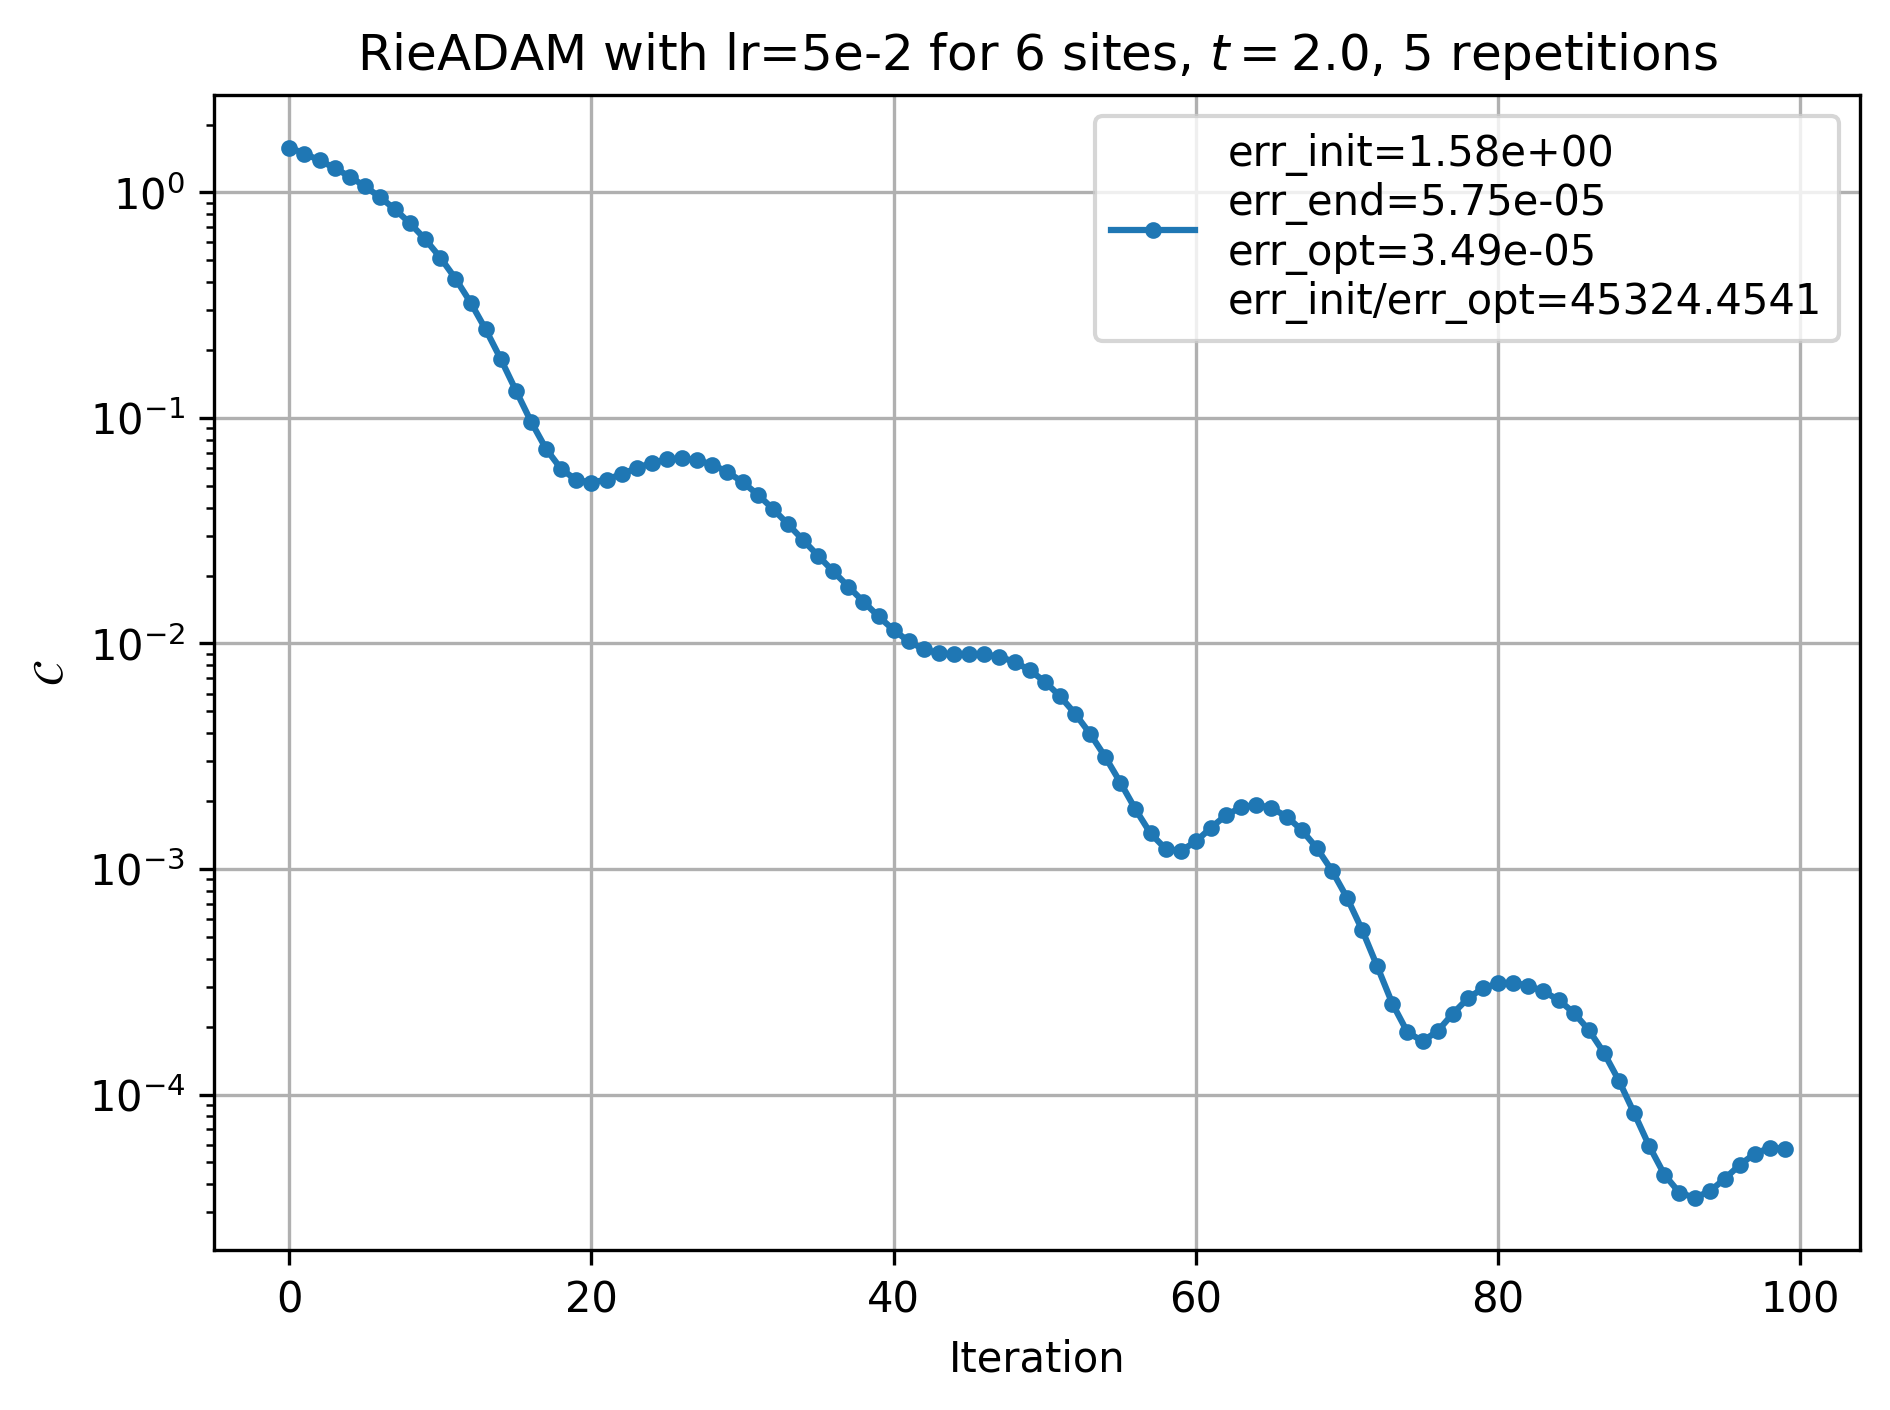

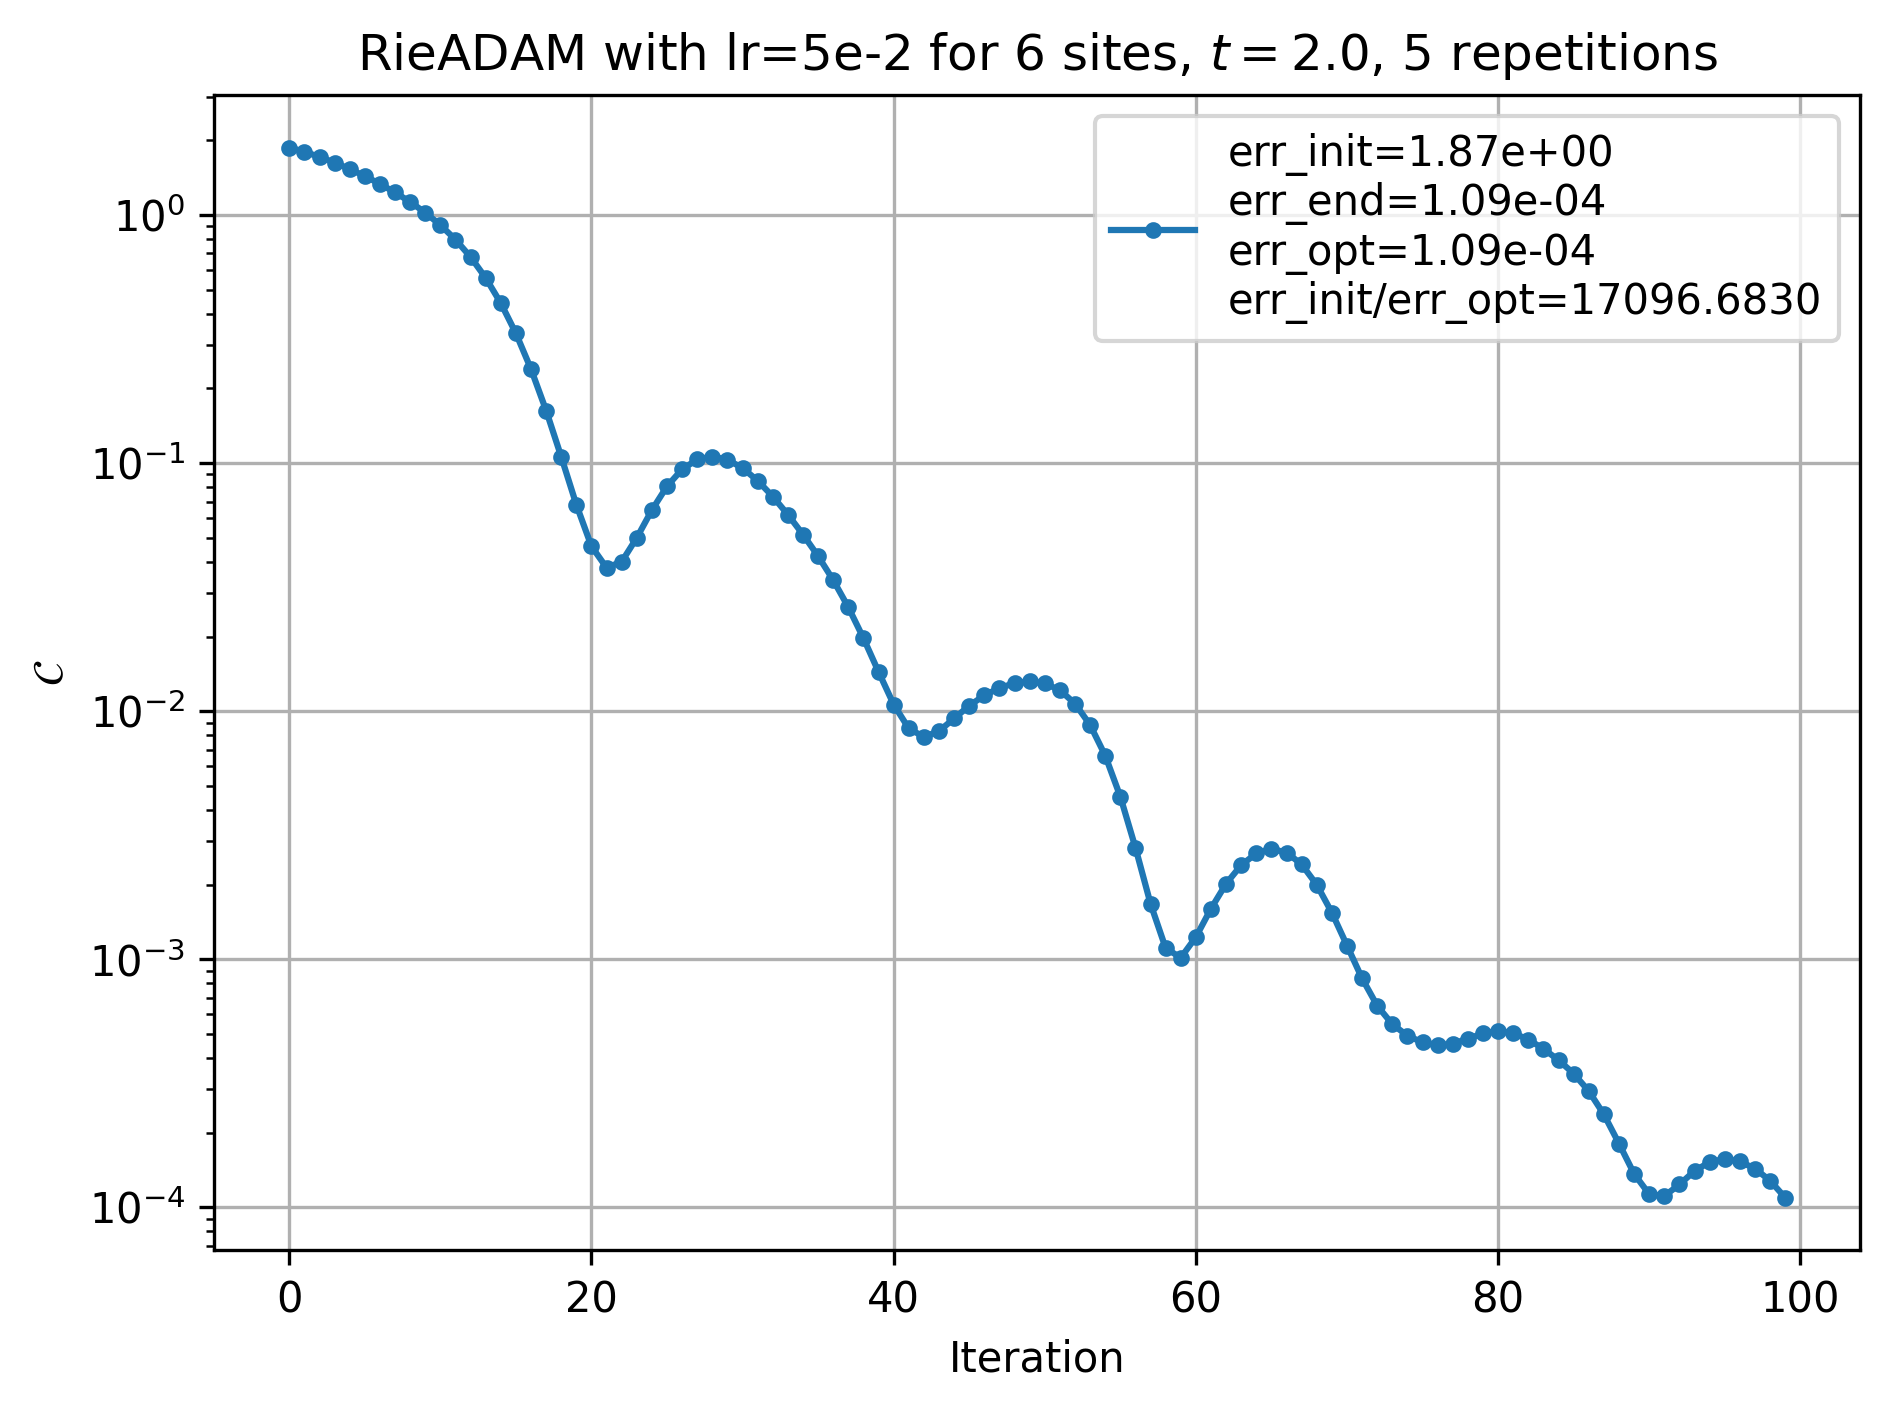

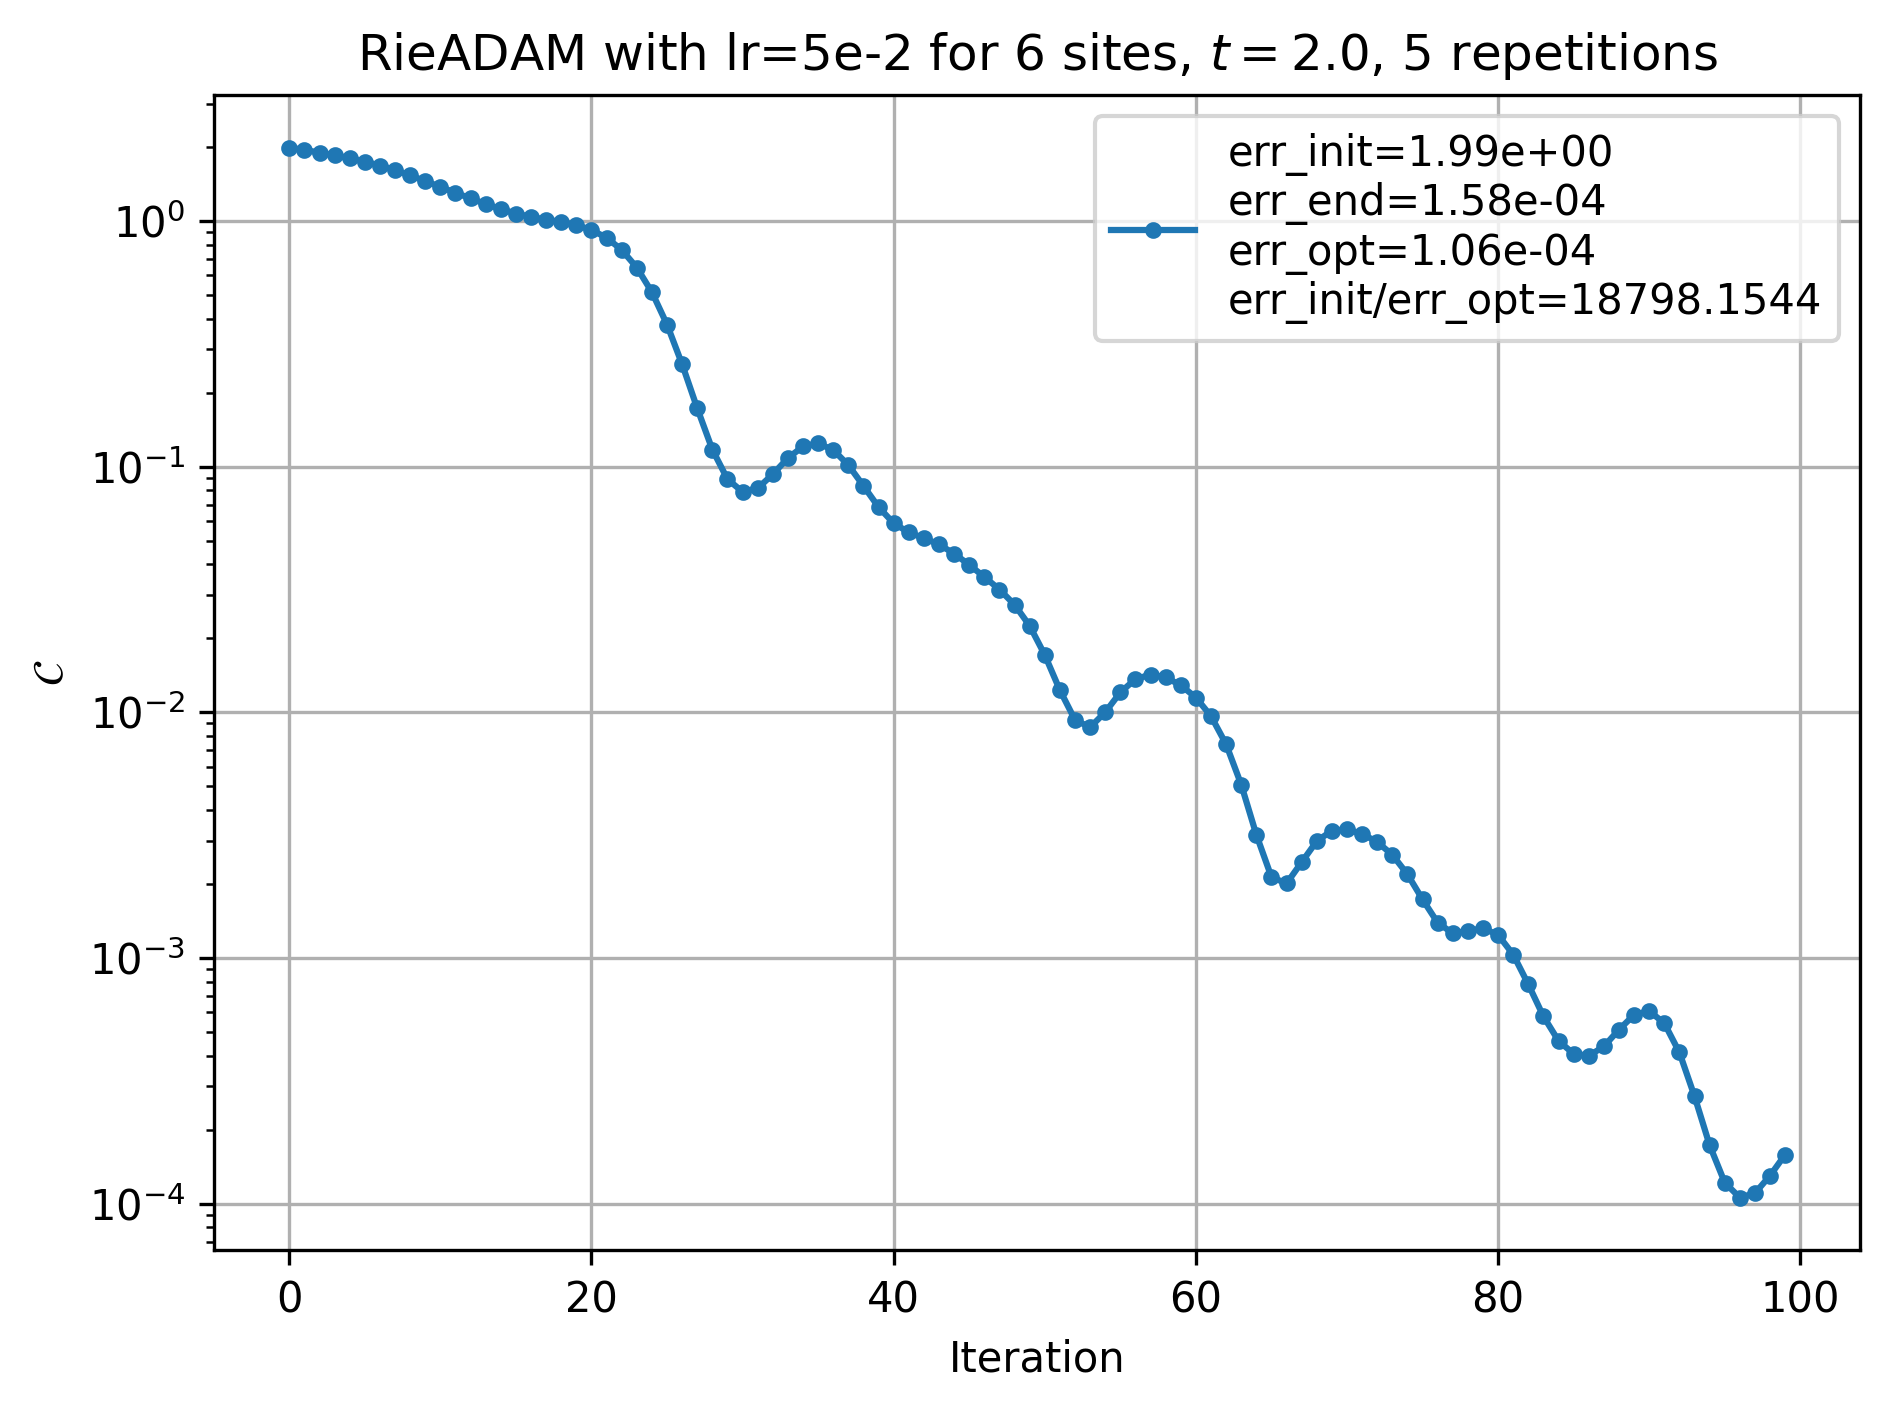

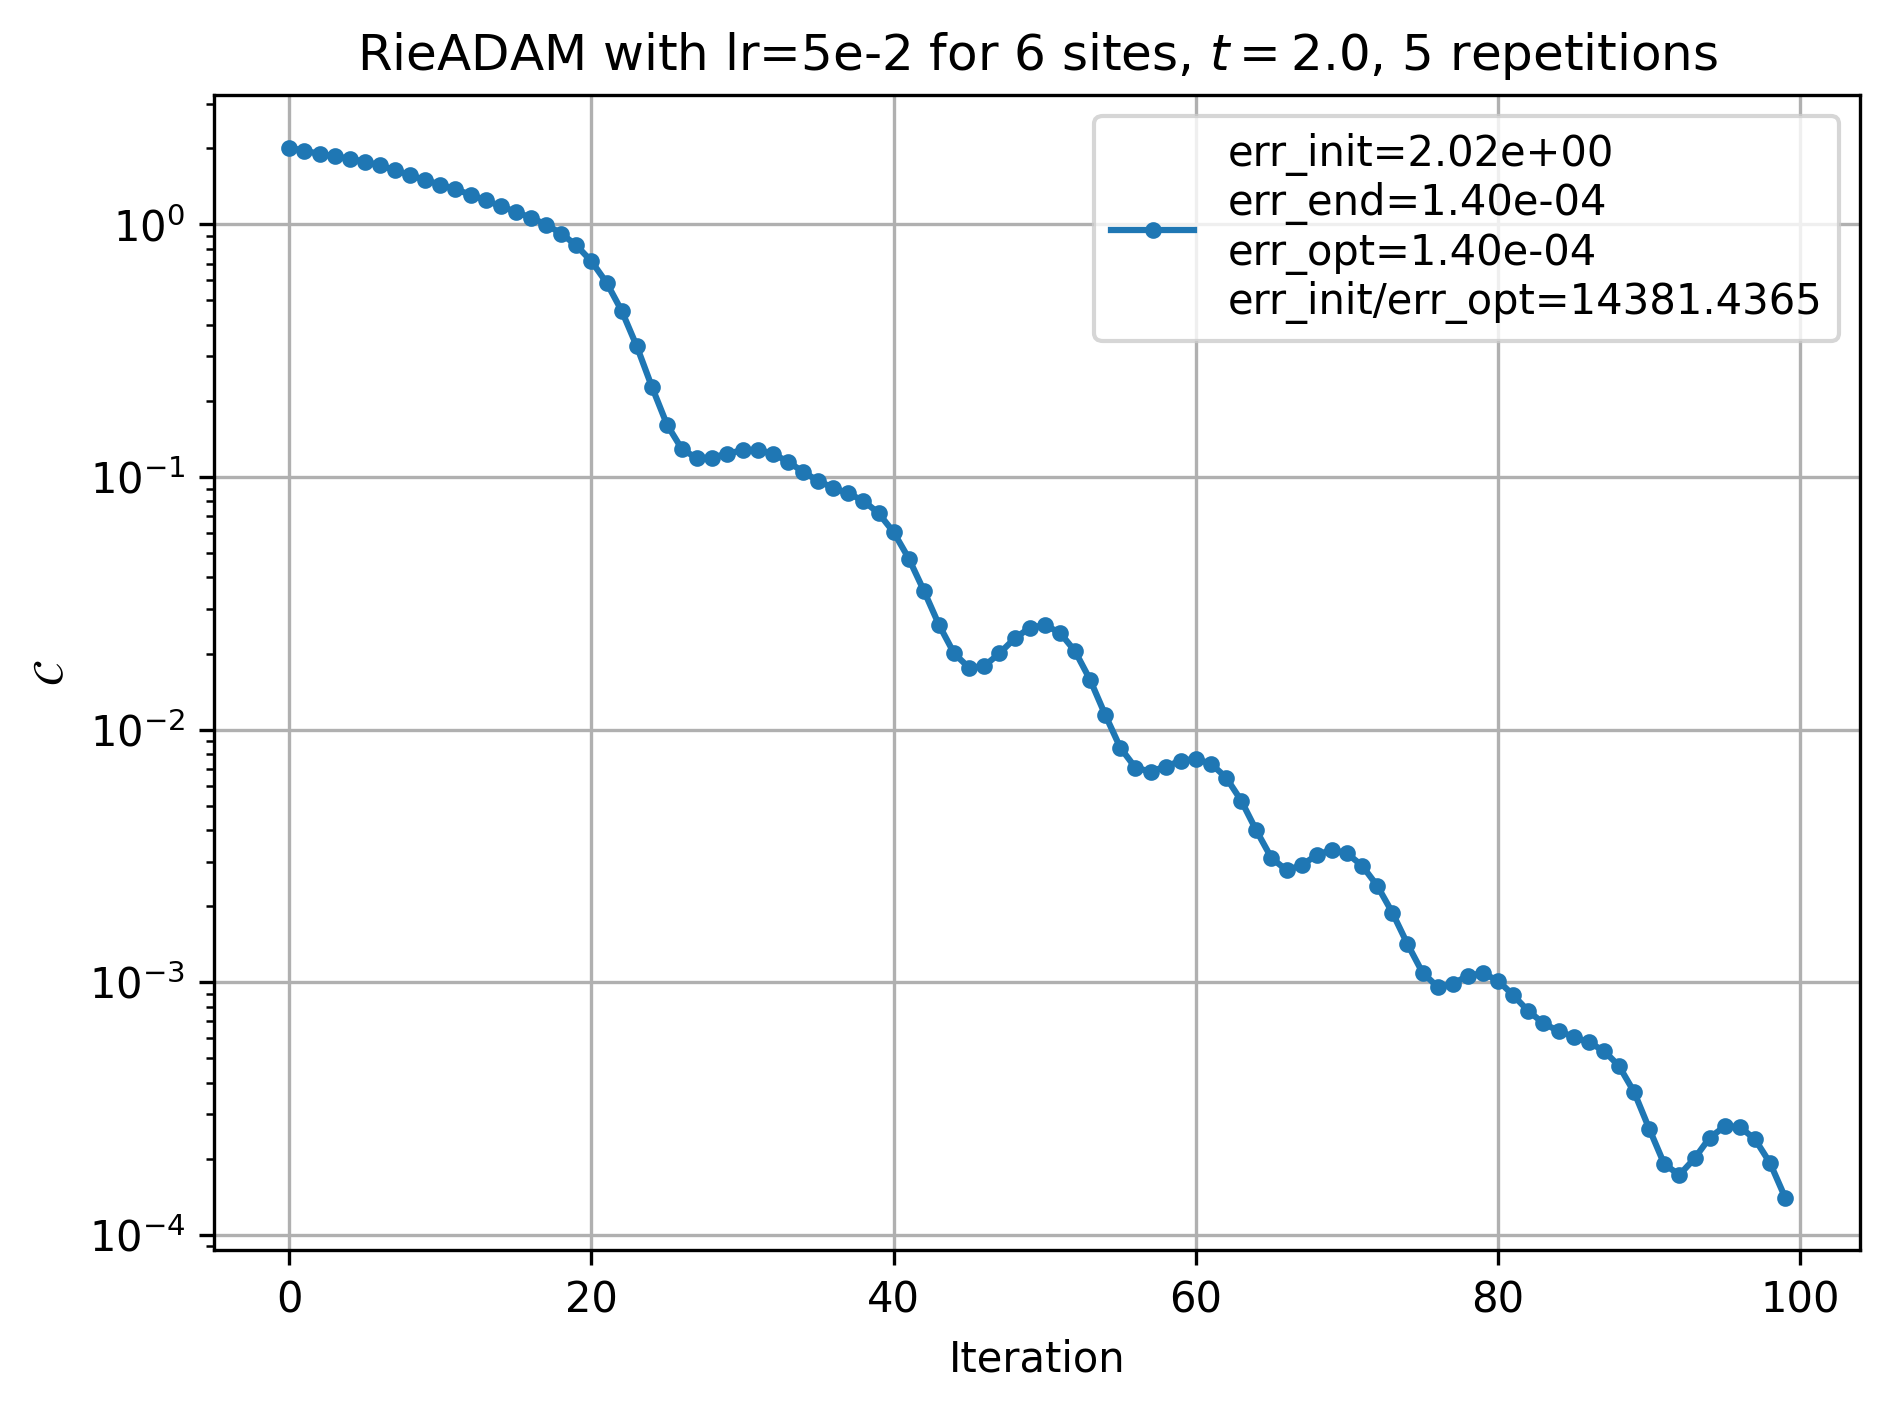

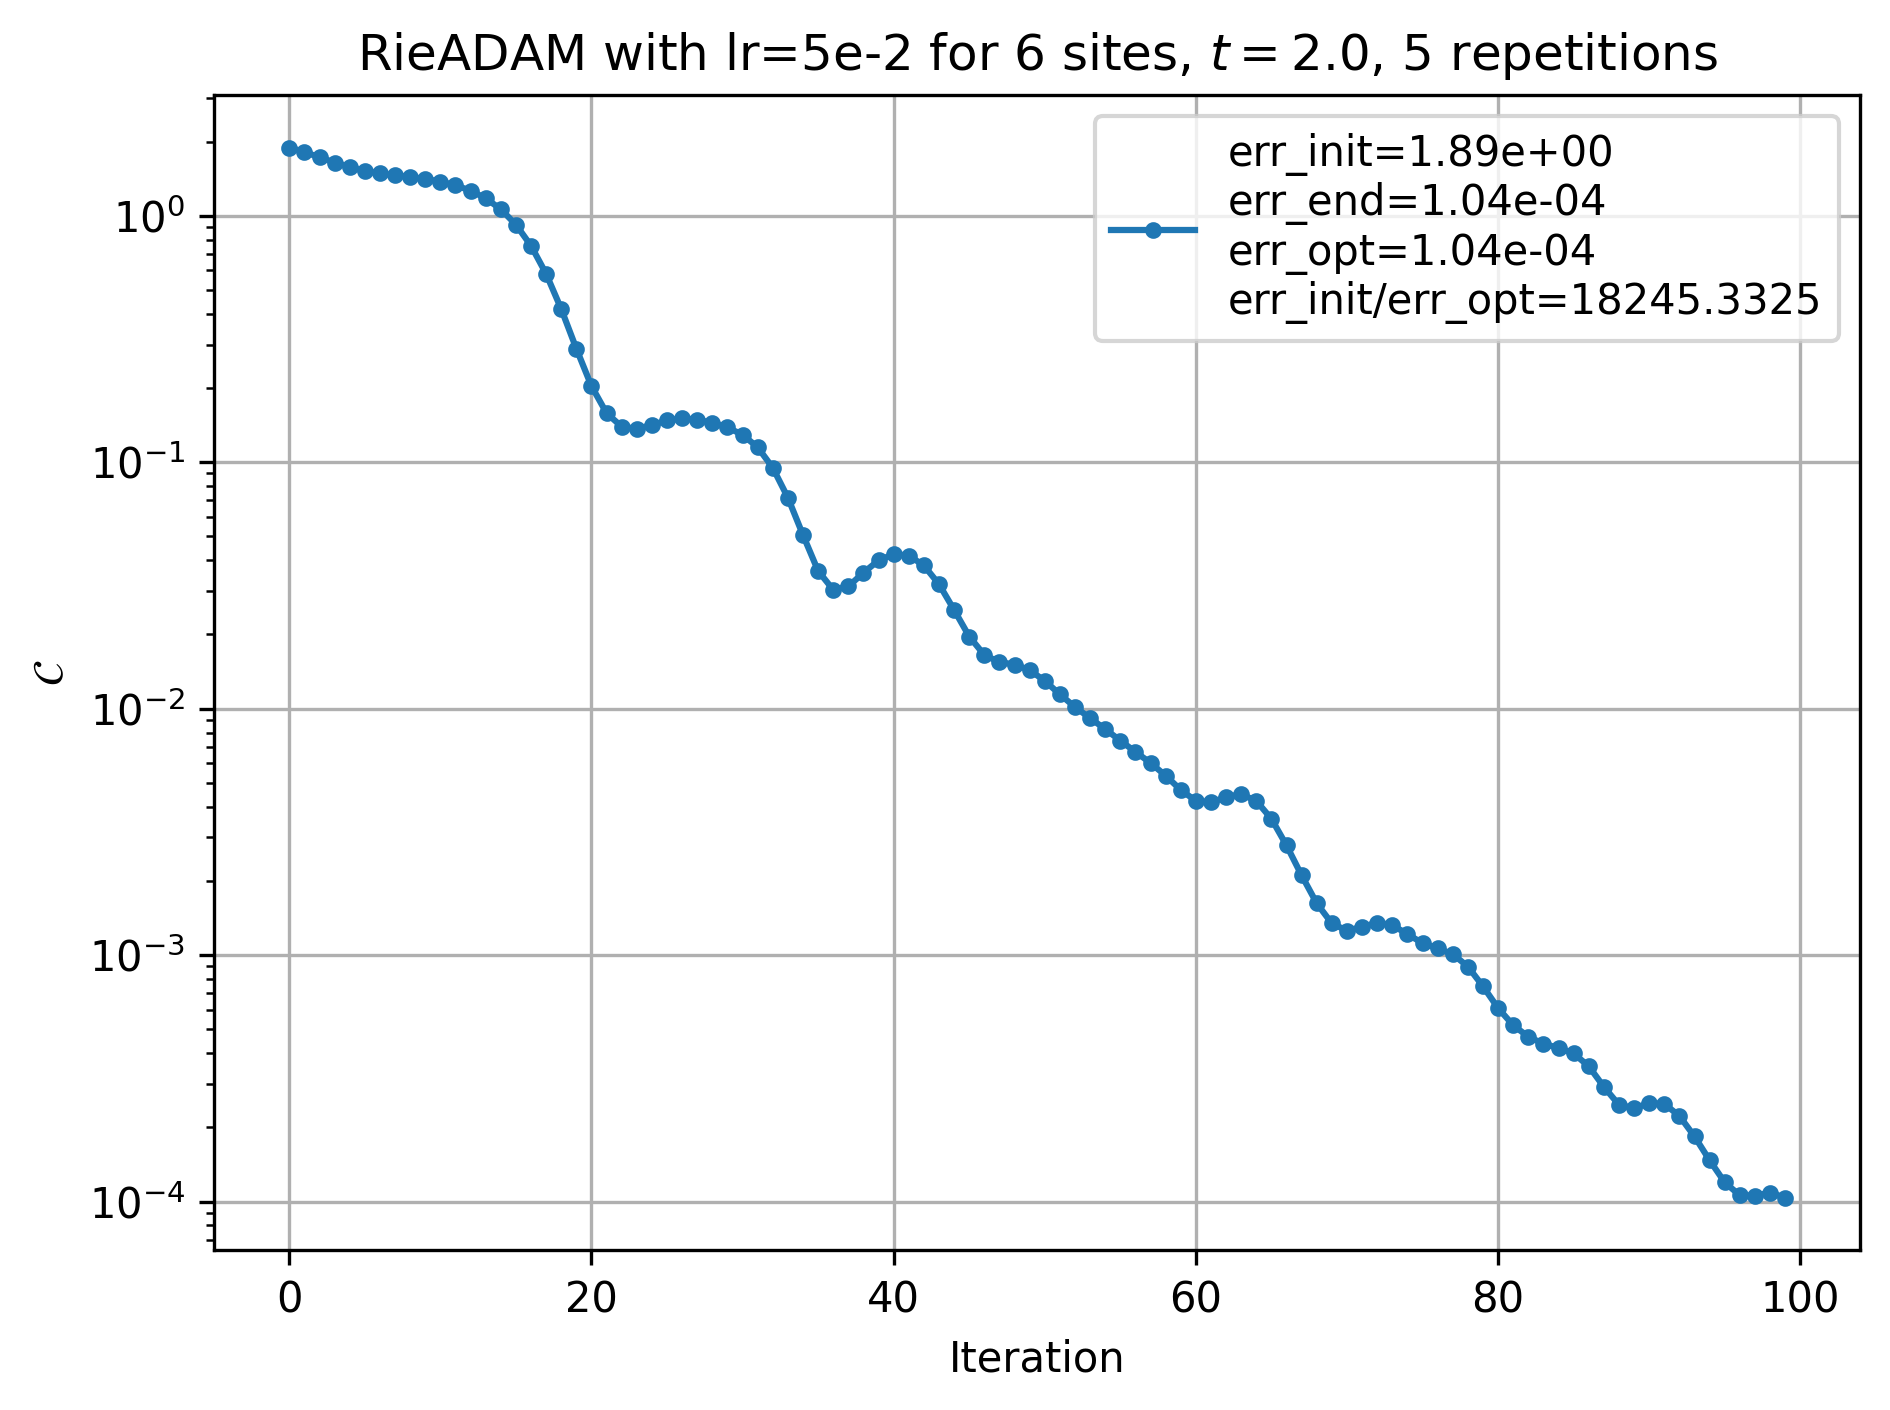

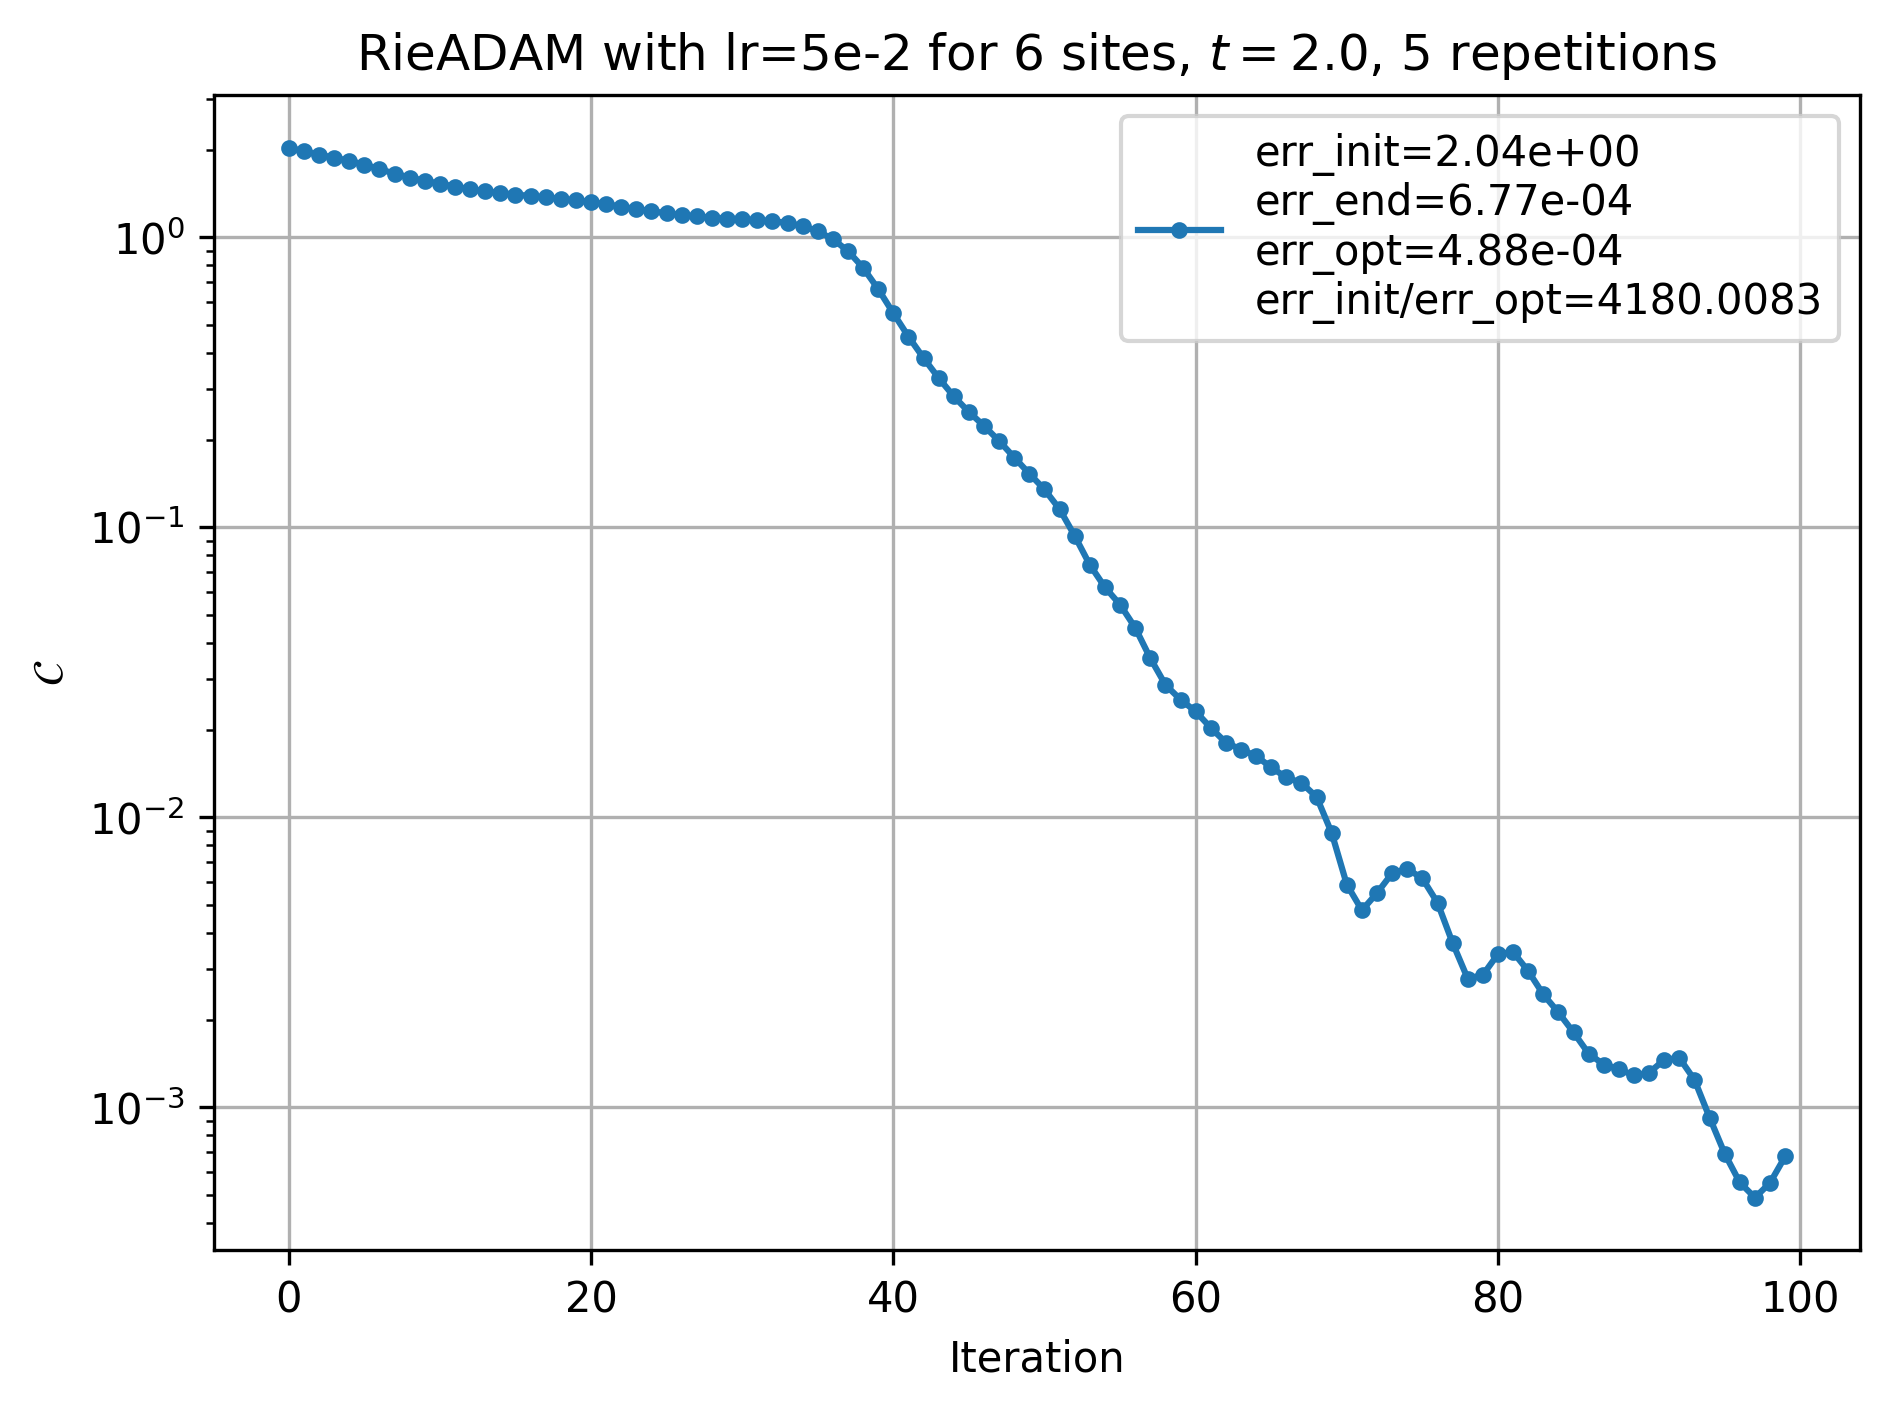

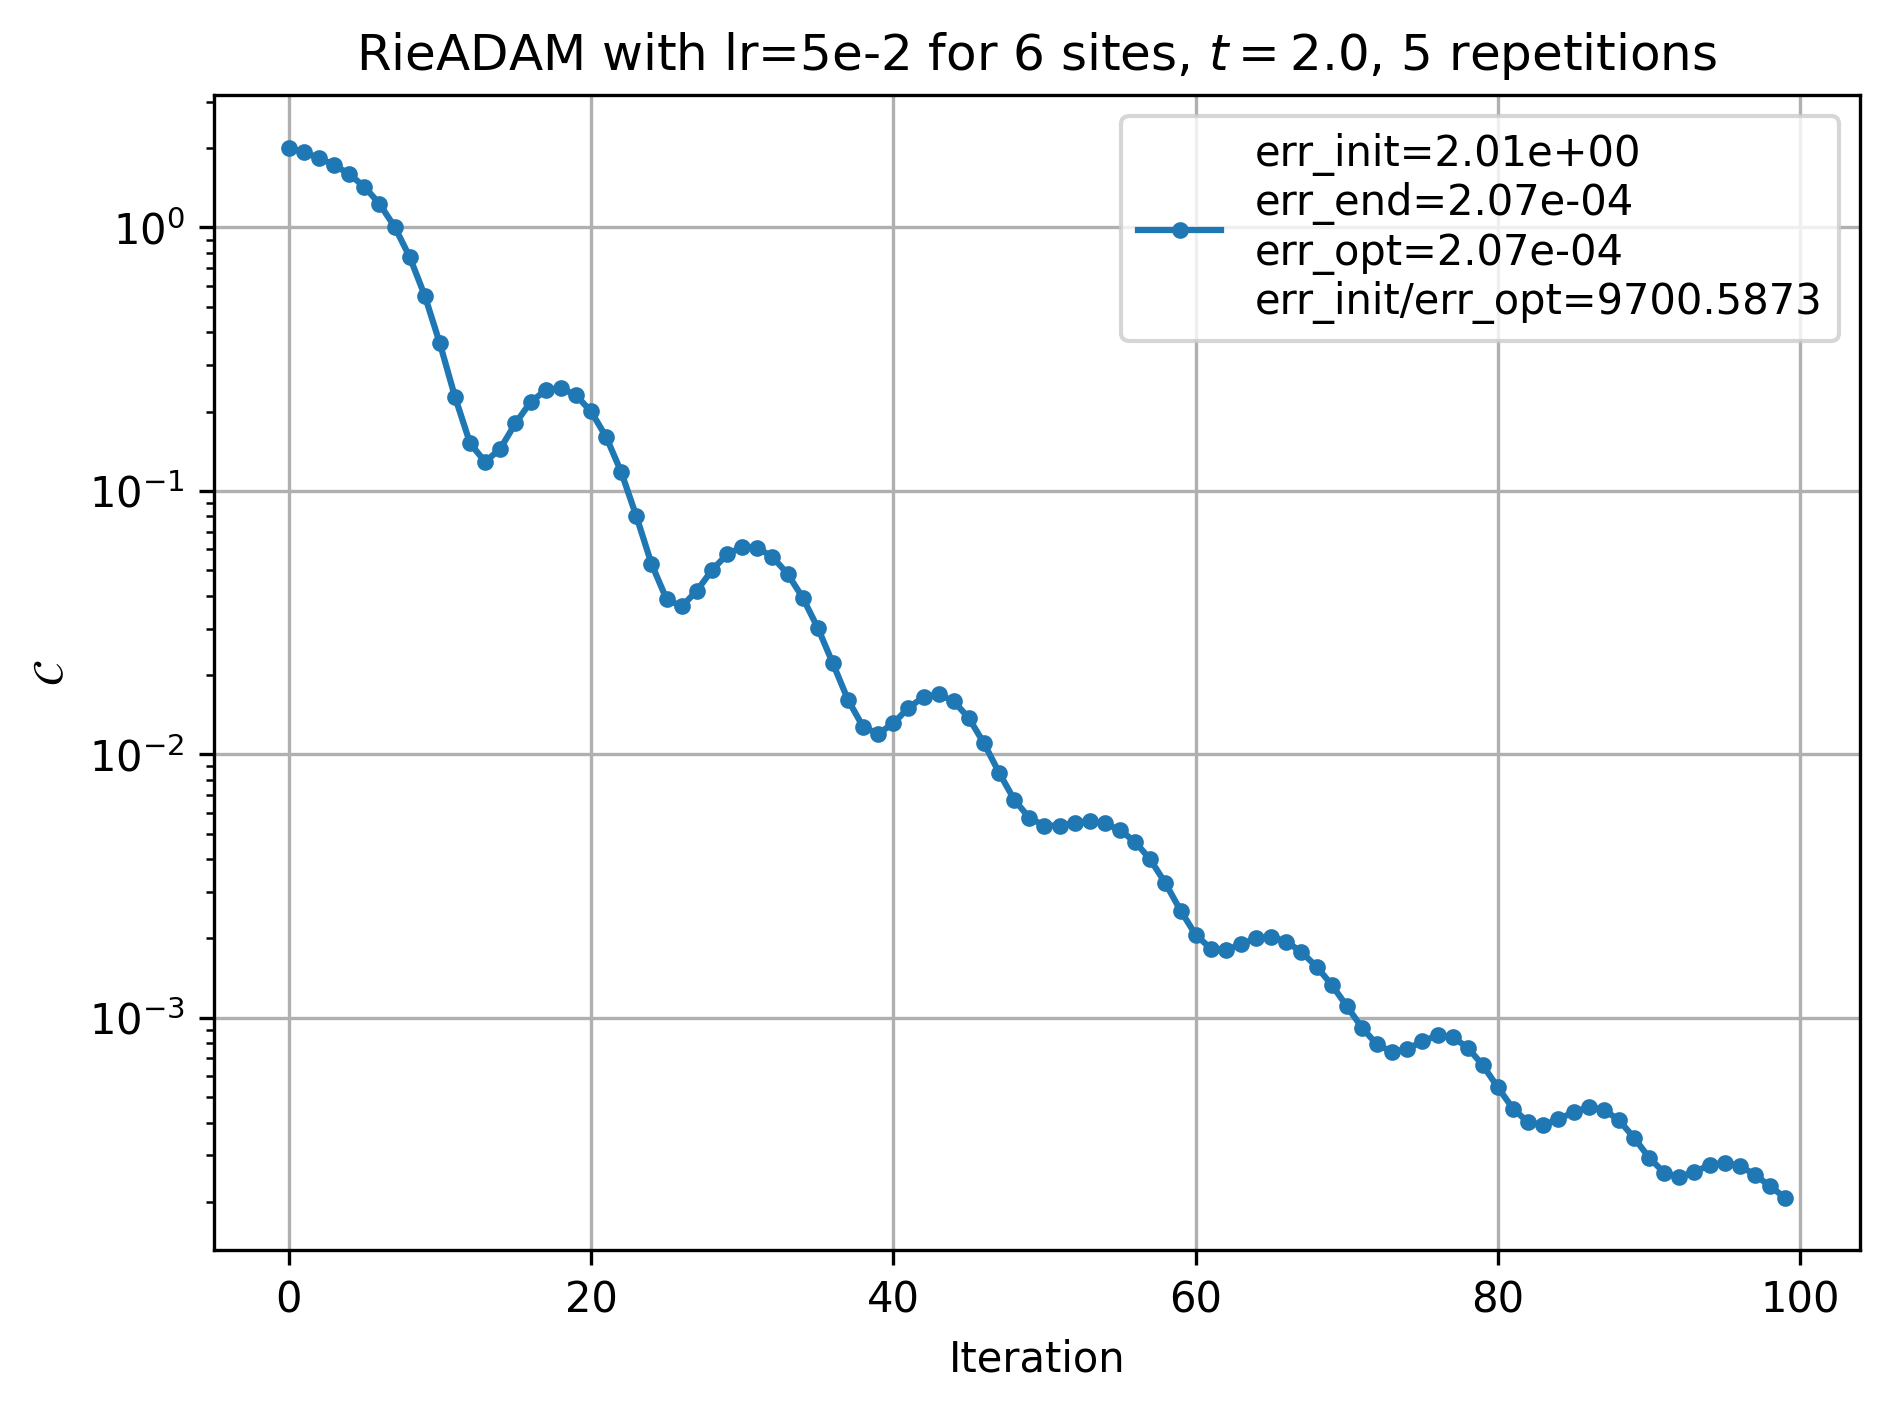

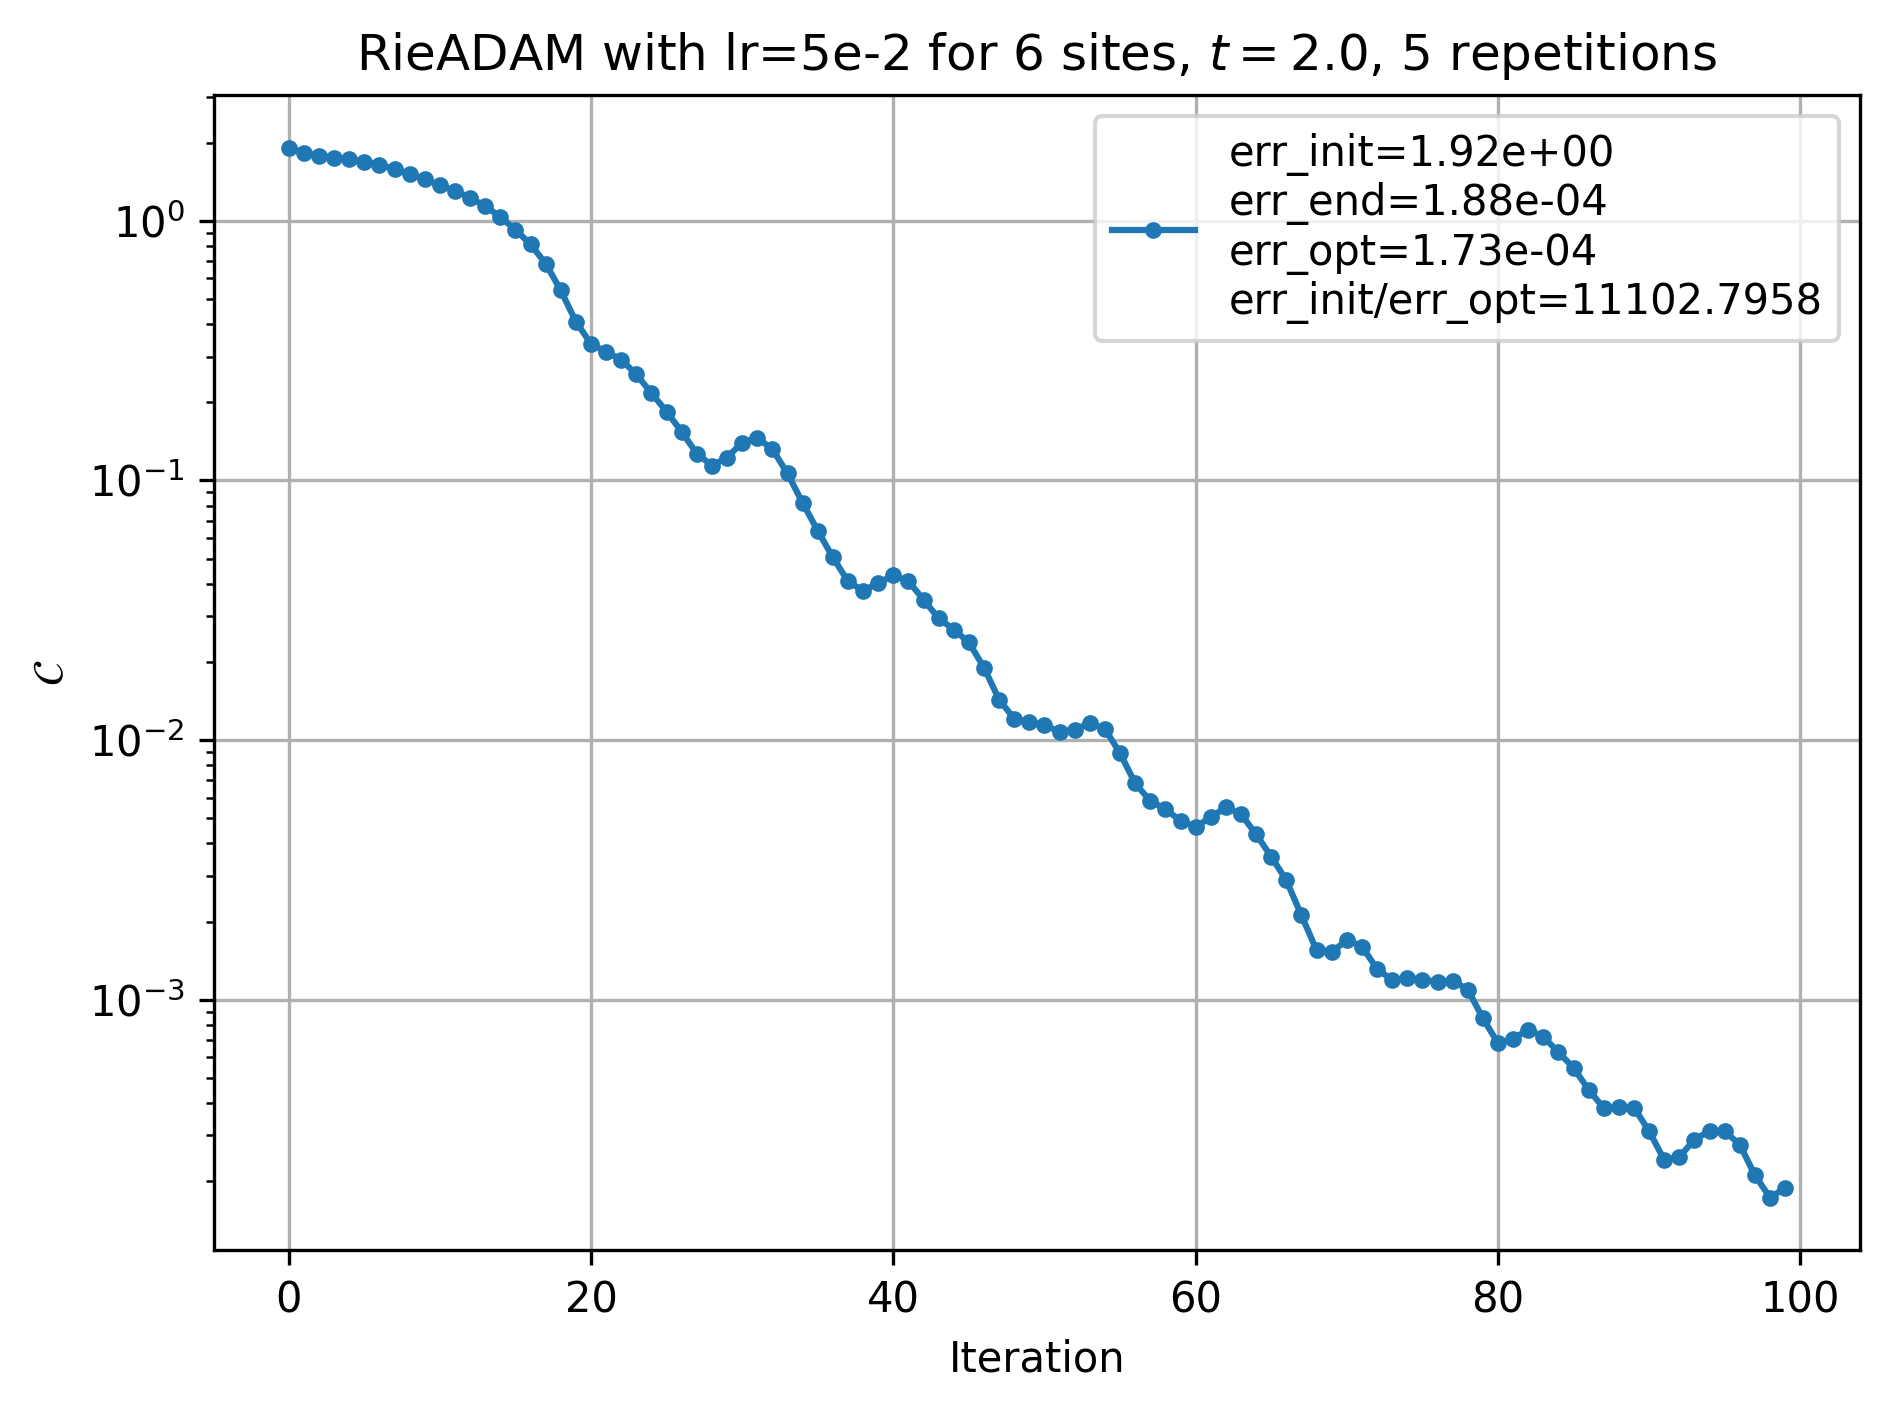

In [56]:
from ropt_aqc.comparison_methods import compress_HS

N_vals = [1,2,3,4,5,6,7,8,9,10]
df_sub = compress_HS(subsequent_gates, config, U_ref_sub, N_vals, qc_initial=None)

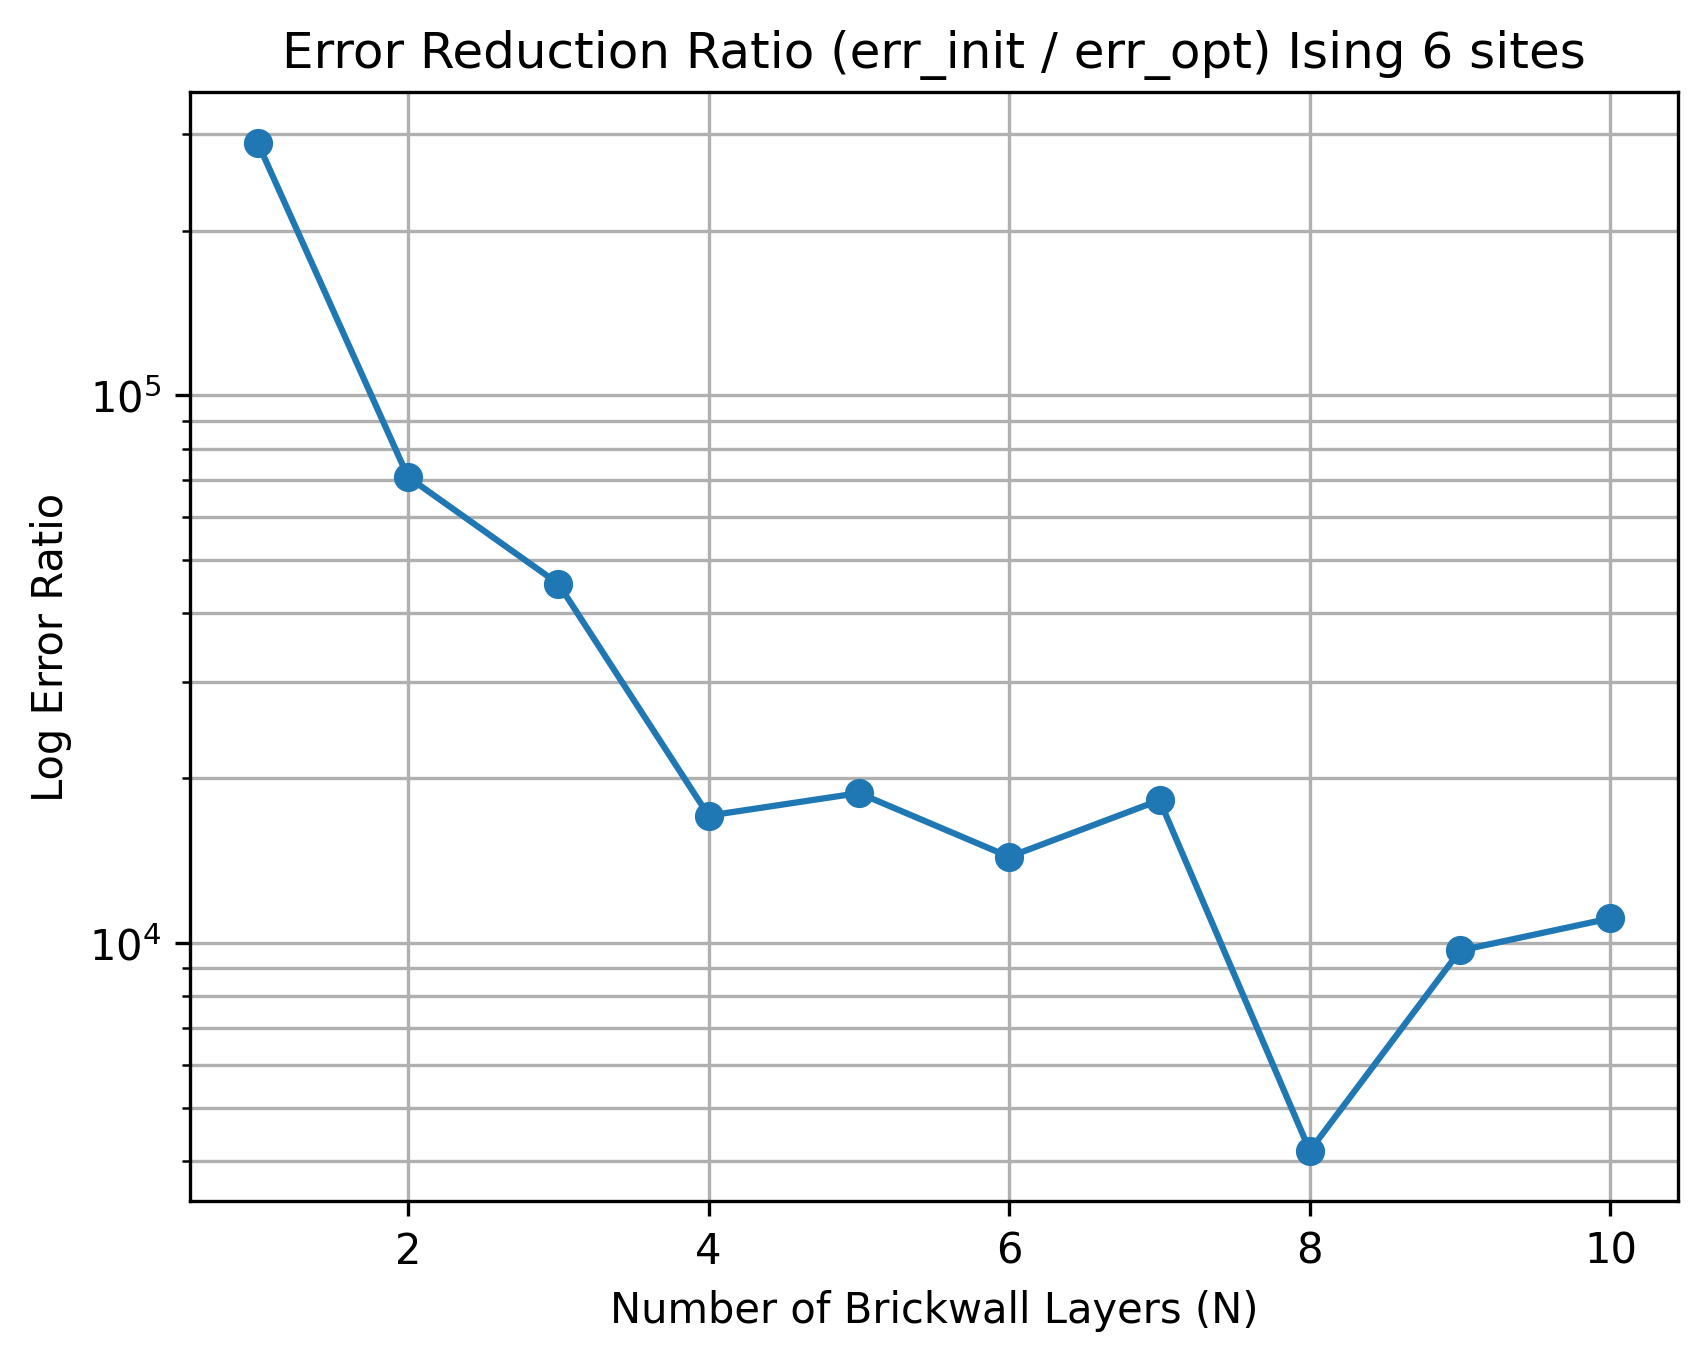

In [57]:
# Plot error ratio (log scale)
plt.figure(dpi=300)
plt.semilogy(df_sub['circuit_layers'], df_sub['err_init/err_opt'], marker='o')
plt.title('Error Reduction Ratio (err_init / err_opt) Ising 6 sites')
plt.xlabel('Number of Brickwall Layers (N)')
plt.ylabel('Log Error Ratio')
plt.grid(True, which='both')
plt.show()

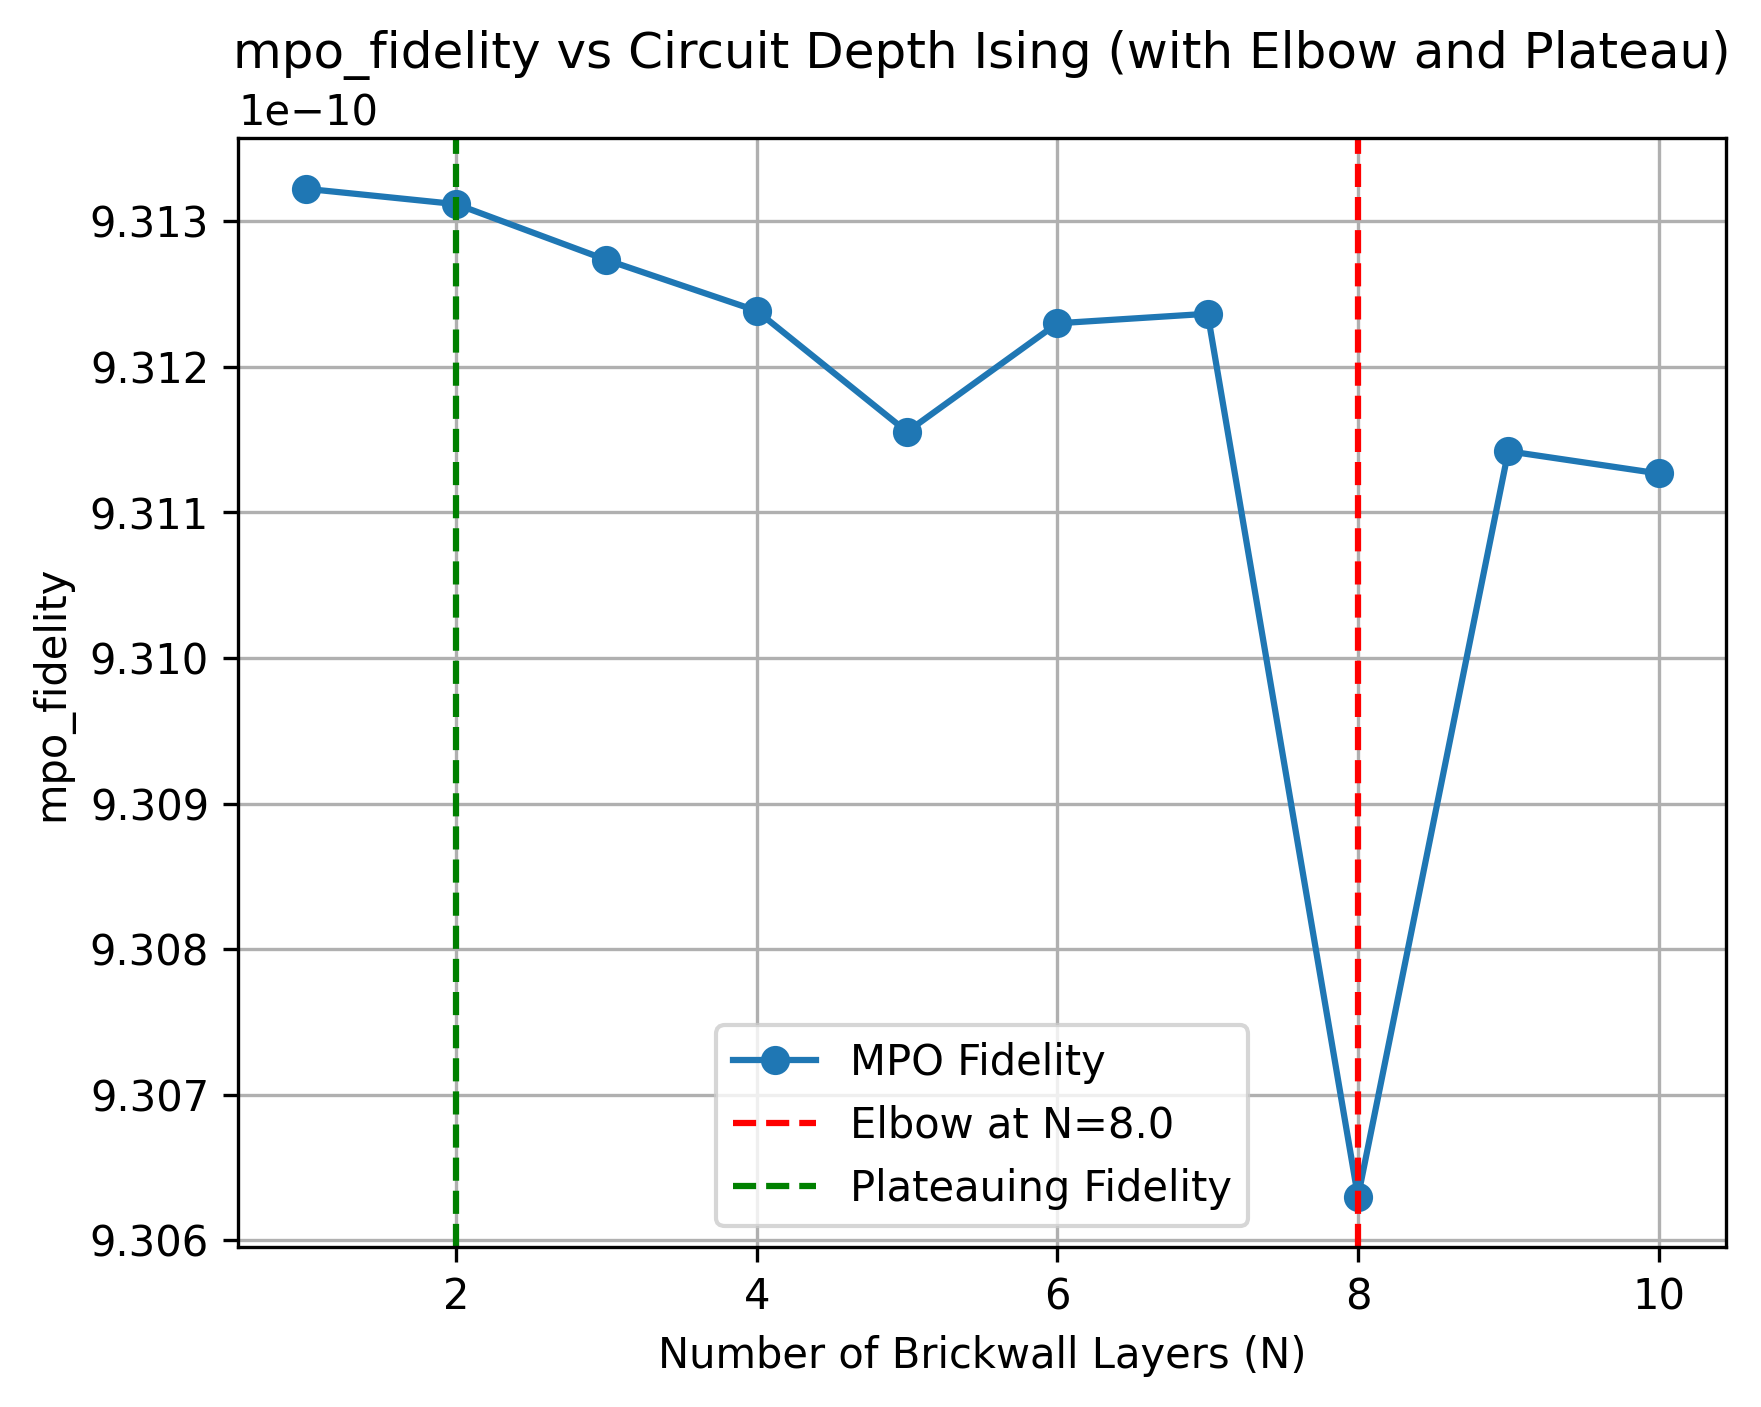


🔍 Suggested optimal compression depth: N = 2.0


In [58]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N, plateau_N = plot_fidelity(df_sub, 'mpo_fidelity', n_repetitions, method, system)

# Heisenberg

In [95]:
# Heisenberg
t = 0.25
h = 0.75
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [54]:
from ropt_aqc.spin_systems import get_brickwall_trotter_gates_spin_chain

gates_heisenberg = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=n_repetitions, hamiltonian=system, degree=degree, J=J, h=h)

In [55]:
# Matrices for qc
from ropt_aqc.brickwall_circuit import get_initial_gates

gates_initial_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=False, J=-J, h=h)
print(np.array(gates_initial_h).shape) 

(28, 4, 4)


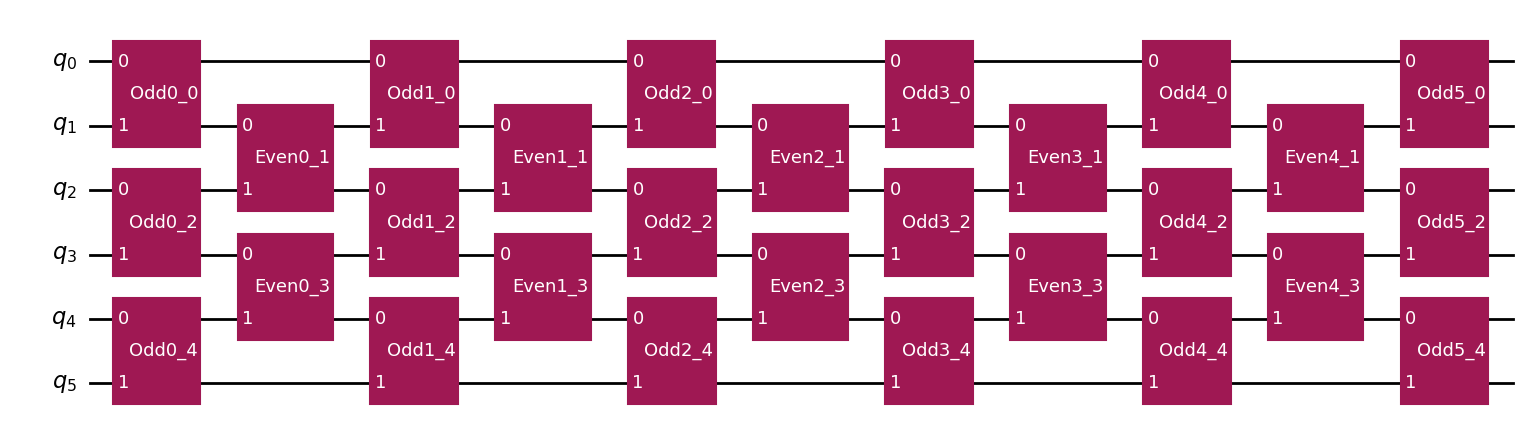

In [57]:
from ropt_aqc.circuit_building import transform_to_bw_qc_unitarygate

qc_initial_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system = system, gates=gates_initial_h, pauli_terms=terms)
qc_initial_h.draw('mpl')

In [58]:
# TN for optimisation
from ropt_aqc.brickwall_circuit import get_initial_gates
gates_h = get_initial_gates(n_sites=num_sites, t=t, n_repetitions=n_repetitions, degree=degree, hamiltonian=system, n_id_layers=n_id_layers, use_TN=True, J=J, h=h)
print(np.array(gates_h).shape)  # Should be (N, 4, 4) for 2-qubit gates

(28, 2, 2, 2, 2)


In [60]:
from ropt_aqc.save_model import load_reference
import os
import yaml
repo_root = "/Users/aag/Documents/ropt-aqc/"
config_file = os.path.join(repo_root, "run", system, "configs", "config.yml") 

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

config['ref_nbr'] = n_repetitions

config['reference_dir'] = f'/Users/aag/Documents/ropt-aqc/run/{system}/reference'

U_ref, t, _, _, _, _, _, _, _, J, h= load_reference(config['reference_dir'], config['n_sites'], config['ref_nbr'])

In [61]:
from ropt_aqc.tn_helpers import left_to_right_QR_sweep

U_ref = left_to_right_QR_sweep(U_ref, get_norm=False, normalize=config['normalize_reference'])
print("U_ref shape:", [m.shape for m in U_ref])

U_ref shape: [(1, 2, 2, 4), (4, 2, 2, 16), (16, 2, 2, 33), (33, 2, 2, 16), (16, 2, 2, 4), (4, 2, 2, 1)]


Start Riemannian ADAM optimization ...
	 0 	Current cost:  3.1528563186888903e-06
	 1 	Current cost:  0.0008704070581657675
	 2 	Current cost:  0.00010205318896394644
	 3 	Current cost:  0.00020570333941272168
	 4 	Current cost:  0.0003747591539728923
	 5 	Current cost:  0.0003463962374810059
	 6 	Current cost:  0.00019490333482496958
	 7 	Current cost:  4.7192160652187454e-05
	 8 	Current cost:  4.02600354267868e-05
	 9 	Current cost:  0.0001544120969343421
	 10 	Current cost:  0.00021672882708201335
	 11 	Current cost:  0.0001511149113468946
	 12 	Current cost:  5.0233636375907054e-05
	 13 	Current cost:  1.6454252889319676e-05
	 14 	Current cost:  5.0094471147899e-05
	 15 	Current cost:  8.743822133450152e-05
	 16 	Current cost:  9.318634349497756e-05
	 17 	Current cost:  7.339485043234006e-05
	 18 	Current cost:  4.255021176136076e-05
	 19 	Current cost:  1.761348321149825e-05
	 20 	Current cost:  1.7393349002414737e-05
	 21 	Current cost:  4.016918793725566e-05
	 22 	Current cost:

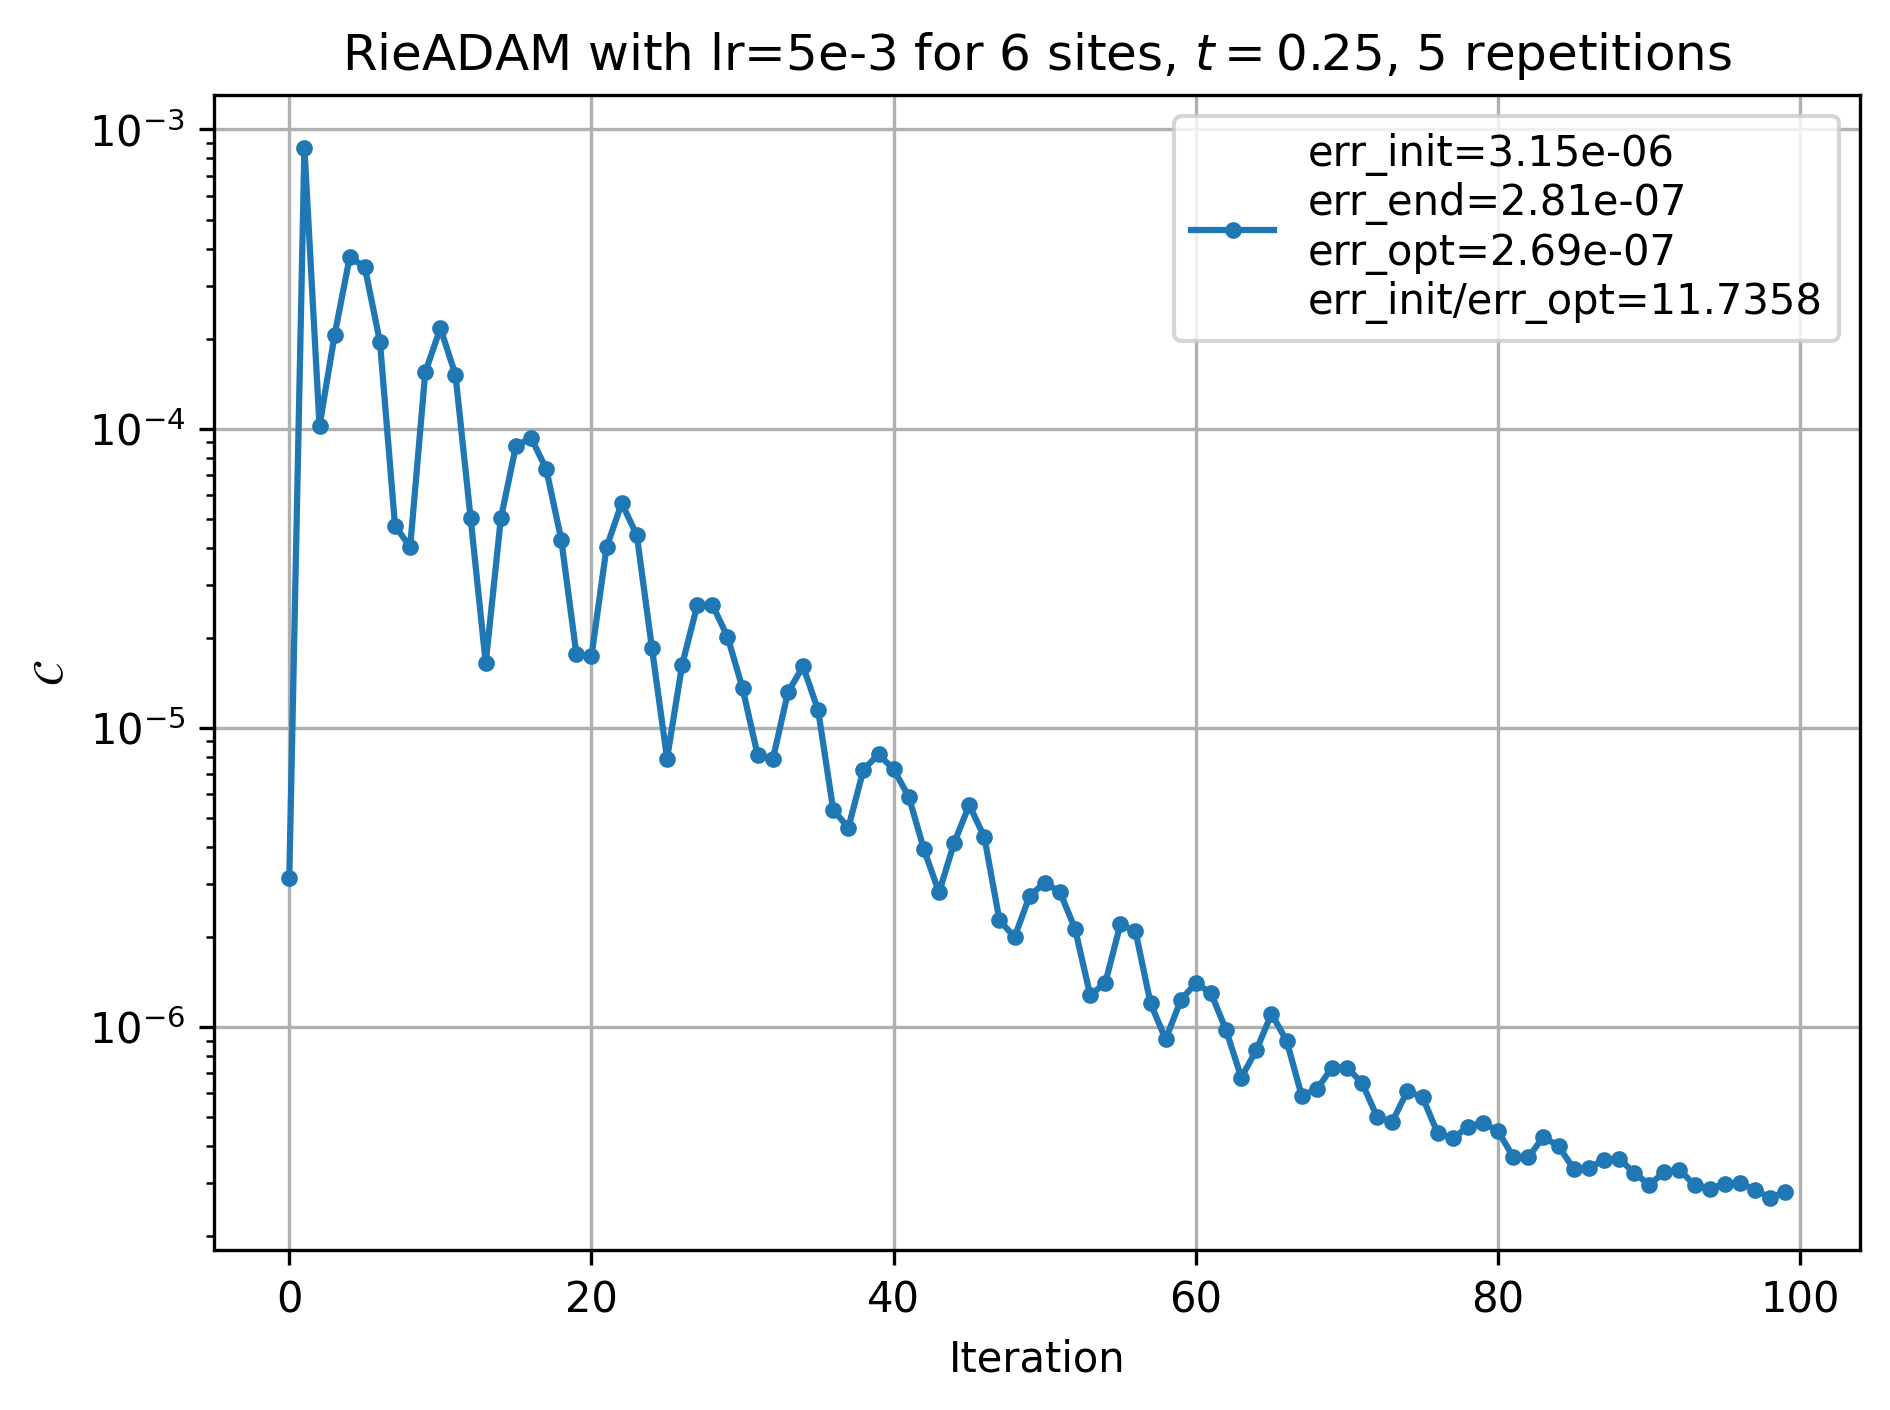

In [74]:
from ropt_aqc.brickwall_opt import optimize_swap_network_circuit_RieADAM
import pdb

gates_optimised_h, err_iter = optimize_swap_network_circuit_RieADAM(config, U_ref, gates_h)

In [75]:
gates_optimised_h = gates_optimised_h.reshape((len(gates_optimised_h), 4, 4))
np.allclose(gates_optimised_h, gates_initial_h)  # Should be False

False

In [76]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_observable
H_sparse_h = hamiltonian_to_sparse_observable(terms_h, num_qubits=num_sites)
print(H_sparse_h)

<SparseObservable with 21 terms on 6 qubits: (1+0j)(X_5 X_4) + (1+0j)(Y_5 Y_4) + (-0.5+0j)(Z_5 Z_4) + (1+0j)(X_4 X_3) + (1+0j)(Y_4 Y_3) + (-0.5+0j)(Z_4 Z_3) + (1+0j)(X_3 X_2) + (1+0j)(Y_3 Y_2) + (-0.5+0j)(Z_3 Z_2) + (1+0j)(X_2 X_1) + (1+0j)(Y_2 Y_1) + (-0.5+0j)(Z_2 Z_1) + (1+0j)(X_1 X_0) + (1+0j)(Y_1 Y_0) + (-0.5+0j)(Z_1 Z_0) + (0.75+0j)(X_5) + (0.75+0j)(X_4) + (0.75+0j)(X_3) + (0.75+0j)(X_2) + (0.75+0j)(X_1) + (0.75+0j)(X_0)>


In [77]:
# one option for reference cirucit
# initial time evolution
# construct initial state
from qiskit import QuantumCircuit

initial_state_h = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state_h.x(i)

from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

# Generate the AQC target circuit (initial segment)
aqc_evolution_time = 0.2
aqc_target_num_trotter_steps = 32

aqc_target_circuit_h = initial_state.copy()
aqc_target_circuit_h.compose(
    generate_time_evolution_circuit(
        H_sparse_h,
        synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [78]:
aqc_comparison_circuit_h = initial_state_h.copy()
aqc_comparison_circuit_h.compose(
    generate_time_evolution_circuit(
        H_sparse_h,
        synthesis=SuzukiTrotter(reps=3),
        time=aqc_evolution_time,
    ),
    inplace=True,
)

In [79]:
# second option for reference circuit 
from ropt_aqc.circuit_building import decompose_unitary_gate
ref_gates_h = get_brickwall_trotter_gates_spin_chain(t=t, n_sites=num_sites, n_repetitions=64,
                                                   hamiltonian=system, degree=degree, J=J, h=h)

ref_circuit_h = transform_to_bw_qc_unitarygate(num_sites=num_sites, system=system, gates=ref_gates_h)
native_ref_circuit_h = decompose_unitary_gate(ref_circuit_h)

In [80]:
import quimb.tensor as qtn
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit import transpile

native_ref_circuit_transpiled_h = transpile(
    native_ref_circuit_h,
    basis_gates=['rx', 'ry', 'rz', 'cx'],
    optimization_level=3
)

simulator_settings = QuimbSimulator(qtn.CircuitMPS, autodiff_backend="jax")
aqc_target_mps_h= tensornetwork_from_circuit(native_ref_circuit_transpiled_h, simulator_settings)


In [ ]:
from ropt_aqc.comparison_methods import compress_HS_AQC

df_h, aqc_final_parameters_h = compress_HS_AQC(gates_optimised, config, simulator_settings, aqc_target_mps, aqc_comparison_circuit, aqc_target_circuit, N_vals)


=== Optimizing with N = 1 layers ===
(3, 4, 4)
Starting fidelity: 0.7598277804703327
AQC Comparison circuit: depth 84
Target circuit:         depth 449
Hybrid ansatz circuit:  depth 3, with 45 parameters
2025-04-16 15:13:41.466526 Intermediate result: Fidelity 0.82357098
2025-04-16 15:13:41.467335 Intermediate result: Fidelity 0.89399596
2025-04-16 15:13:41.467956 Intermediate result: Fidelity 0.92522418
2025-04-16 15:13:41.468571 Intermediate result: Fidelity 0.92564415
2025-04-16 15:13:41.469254 Intermediate result: Fidelity 0.92654473
2025-04-16 15:13:41.469897 Intermediate result: Fidelity 0.92757026
2025-04-16 15:13:41.470487 Intermediate result: Fidelity 0.92967506
2025-04-16 15:13:41.471055 Intermediate result: Fidelity 0.93588138
2025-04-16 15:13:41.472187 Intermediate result: Fidelity 0.93963969
2025-04-16 15:13:41.472776 Intermediate result: Fidelity 0.94473678
2025-04-16 15:13:41.473373 Intermediate result: Fidelity 0.94605872
2025-04-16 15:13:41.473989 Intermediate result:

In [ ]:
import pandas as pd
file_path_heisenberg = '/Users/aag/Documents/ropt-aqc/method_comparison/hybrid_Heisenberg_results.csv'

# df.to_csv(file_path_heisenberg, index=False, header=True)
# df.to_csv(file_path_heisenberg, index=False, mode="a", header=False)

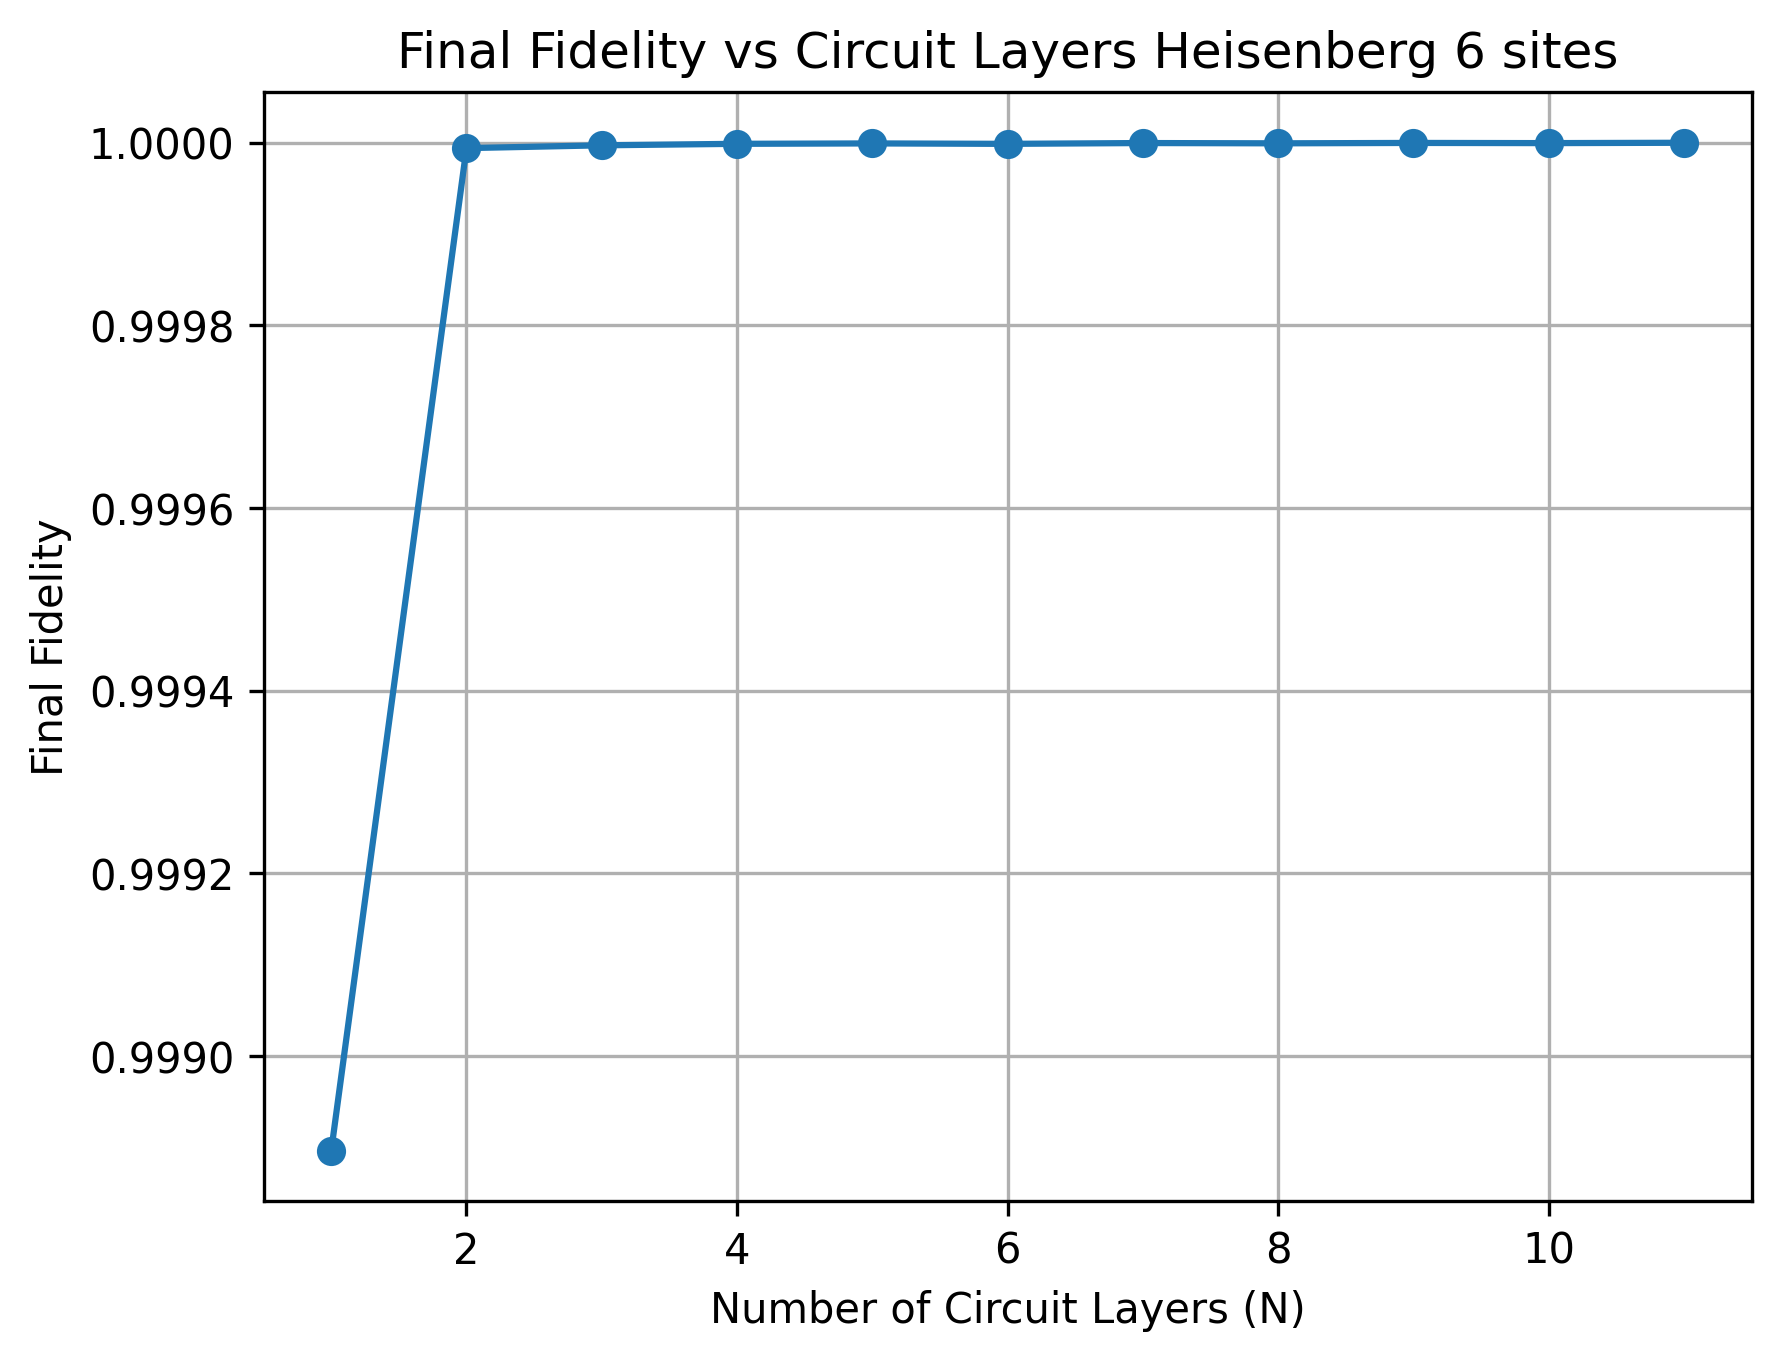

In [97]:
import matplotlib.pyplot as plt
df_h = pd.read_csv(file_path_heisenberg)

# Plot MPO fidelity
plt.figure(dpi=300)
plt.plot(df_h['circuit_layers'], df_h['Final_fidelity'], marker='o')
plt.title('Final Fidelity vs Circuit Layers Heisenberg 6 sites')
plt.xlabel('Number of Circuit Layers (N)')
plt.ylabel('Final Fidelity')
plt.grid(True)
plt.show()

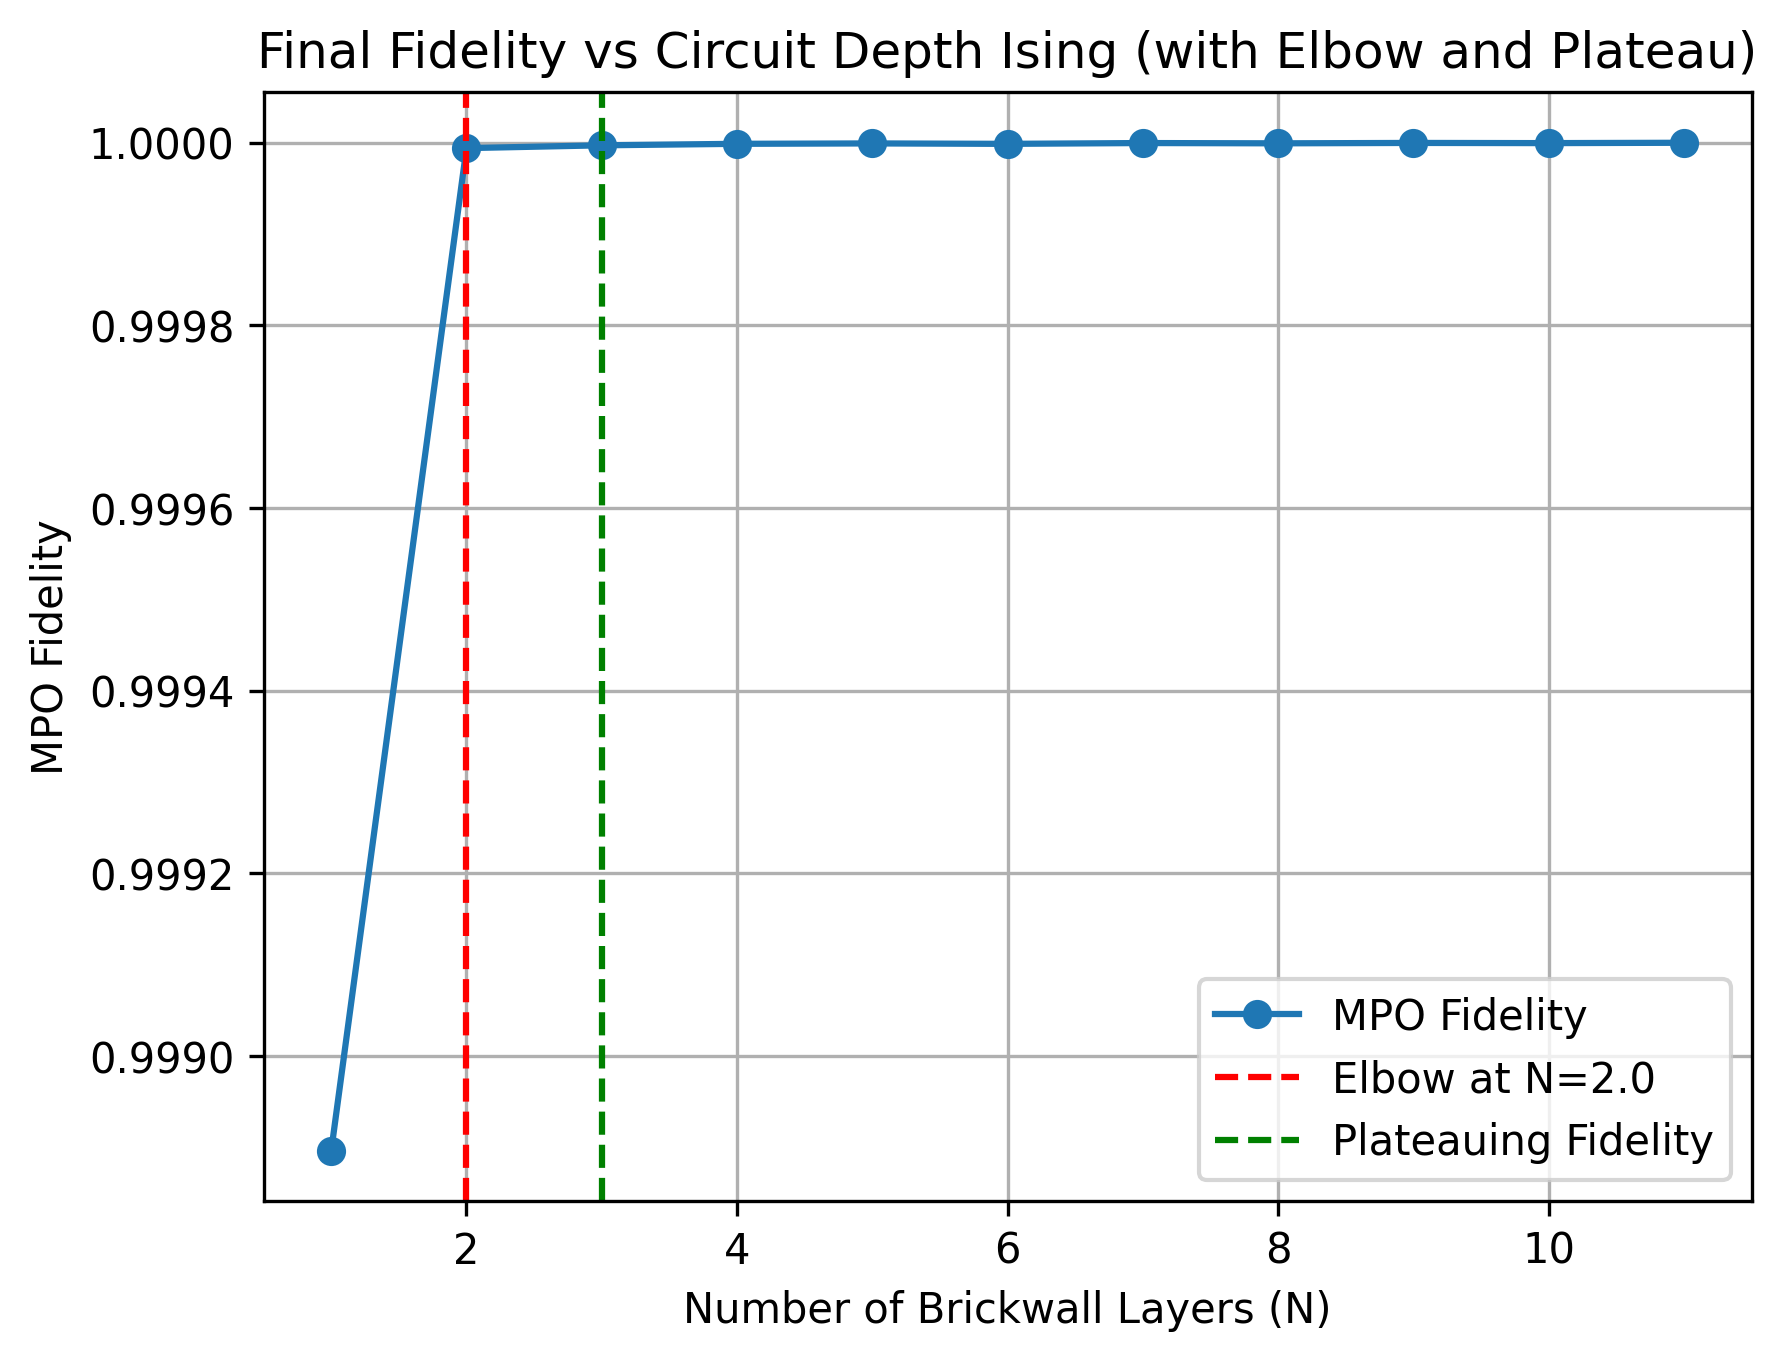


🔍 Suggested optimal compression depth: N = 3.0


In [99]:
from ropt_aqc.brickwall_opt import plot_fidelity

elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', n_repetitions, method, system)

In [ ]:
parameters_h = [float(param) for param in aqc_final_parameters_h]
print("Final parameters:", parameters)

In [ ]:
aqc_final_circuit_h = aqc_ansatz.assign_parameters(aqc_final_parameters_h)
aqc_final_circuit_h.draw("mpl", fold=-1)